<a href="https://colab.research.google.com/github/TRUONGPHANNGOCTRUC/Graduation-Essay/blob/main/TieuLuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nghiên cứu các phương pháp xử lý dữ liệu bị khuyết trong dữ liệu chuỗi thời gian đối với tập dữ liệu về sức khỏe.**


1.   Tập dữ liệu về sức khỏe từ thiết bị theo dõi sữ khỏe fitbit.
2.   Nội dung thực hiện
- Nghiên cứu tình trạng dữ liệu bị khuyết trong chuỗi thời gian và ảnh hưởng của nó đối với độ tin cậy và chính xác của dữ liệu.
- Thực hiện tiền xử lý dữ liệu
- Thực hiện các phương pháp truyền thống và các phương pháp dựa trên mạng nơ-ron: BRITS, Transfomer tích hợp từ PyPots API.
- Thực hiện thử nghiệm và so sánh kết quả
- Phân tích ưu và nhược điểm dựa trên các độ đo MAE, RMSE.
- Kết luận.





**THÔNG TIN TẬP DỮ LIỆU**

⭕**File Citation:**
Andrew Dillon, 2020, "Fitbit_Worker_AllDays_Trimmed_v3-1.tab", Productivity and Health: Alternative Productivity Measures using Physical Activity, https://doi.org/10.7910/DVN/Q023HF/AZXTUI, Harvard Dataverse, V1, UNF:6:/T7XQTir1p+ti/PnjkeAug== [fileUNF]

⭕**Dataset Citation:**
Andrew Dillon, 2020, "Productivity and Health: Alternative Productivity Measures using Physical Activity", https://doi.org/10.7910/DVN/Q023HF, Harvard Dataverse, V1, UNF:6:uIKQuo9yxoim9ci0pDqVLw== [fileUNF]

# **0. Kết nối Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Tiểu luận 2020-2024/Datasets'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Tiểu luận 2020-2024/Datasets


#**1. Tải các cài đặt phụ thuộc**

In [ ]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.5 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29881 sha256=86ad338b6c745f7dbabef6e33be211d3b022c93a224aaf4b24cfd03e8f1bb0c6
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=e2335a51db98ec3d8123f9697857af73a875b9e8ac5b9916076b14aa8bd80184
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
# install pypots >=0.4
! pip install pypots>=0.4

# **2. Nhập các thư viện**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer
from fancyimpute import KNN
from pypots.optim import Adam
from pypots.imputation import BRITS
from pypots.utils.metrics import calc_mae
from datetime import datetime, timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
import numpy as np
import time
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from pypots.imputation import Transformer
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import gc
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from pygrinder import mcar, masked_fill
import os
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_mse
from pypots.utils.metrics import calc_rmse

# **3. Tải tập dữ liệu**

In [ ]:
df = pd.read_csv("Fitbit_Worker_AllDays_Trimmed_public-1.tab",sep='\t')


In [ ]:
print(df)

      plantation_id_n  productivity_date  gang  work     Date  daily_amount  \
0                31.0                NaN   1.0   NaN  19458.0           NaN   
1               349.0                NaN   4.0   NaN  19440.0           NaN   
2               462.0            19454.0   5.0   1.0  19454.0        940.80   
3               509.0                NaN   6.0   NaN  19450.0           NaN   
4                69.0            19448.0   1.0   0.0  19448.0          0.00   
...               ...                ...   ...   ...      ...           ...   
4939            143.0            19430.0   2.0   1.0  19430.0       1404.48   
4940            639.0            19435.0   7.0   1.0  19435.0       1120.00   
4941            181.0            19452.0   2.0   1.0  19452.0       1008.00   
4942             23.0                NaN   1.0   NaN  19420.0           NaN   
4943            219.0            19422.0   3.0   1.0  19422.0        649.60   

      daily_rods  haemo        bmi  edyrs  ...   hr

# **4. Tính toán dữ liệu bị khuyết**

In [ ]:
def calculate_missing_data(df):
    # Tính toán tần suất dữ liệu bị khuyết
    missing_values_dfcp = df.isnull().sum()

    # Tính toán phần trăm dữ liệu bị khuyết
    total_cells_dfcp = np.product(df.shape)
    total_missing_dfcp = missing_values_dfcp.sum()

    percent_missing_dfcp = (total_missing_dfcp / total_cells_dfcp) * 100
    percent_missing_per_column = (missing_values_dfcp / df.shape[0]) * 100

    print("Tần suất dữ liệu bị khuyết:\n", missing_values_dfcp)
    print("\nTổng phần trăm dữ liệu bị khuyết: {:.2f}%".format(percent_missing_dfcp))
    print("\nPhần trăm dữ liệu bị khuyết của từng cột:\n", percent_missing_per_column)

    return {
        'missing_values_dfcp': missing_values_dfcp,
        'percent_missing_dfcp': percent_missing_dfcp,
        'percent_missing_per_column': percent_missing_per_column
    }

result = calculate_missing_data(df)


Tần suất dữ liệu bị khuyết:
 plantation_id_n           0
productivity_date      1782
gang                      0
work                   1782
Date                      0
daily_amount           1782
daily_rods             1782
haemo                  1782
bmi                    1782
edyrs                  1857
health_int_date         336
hr_active              1782
hr_fair_very           1782
hr_sedentary           1782
hr_total               1782
hr_light               1782
hr_fair                1782
hr_very                1782
daily_amount_cond      3300
work_allday              17
daily_amount_allday      17
daily_rods_allday        17
rdtp                      0
rods_per_AD            1799
intweek                 336
outlier                   0
dtype: int64

Tổng phần trăm dữ liệu bị khuyết: 24.00%

Phần trăm dữ liệu bị khuyết của từng cột:
 plantation_id_n         0.000000
productivity_date      36.043689
gang                    0.000000
work                   36.043689
Date        

<ipython-input-7-c5307dd13be2>:22: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  result = calculate_missing_data(df)


In [ ]:
def plot_missing_data(df):
    # Tính tỷ lệ dữ liệu khuyết cho mỗi cột
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Vẽ biểu đồ cột cho tỷ lệ dữ liệu khuyết
    plt.figure(figsize=(12, 6))
    missing_percentage.plot(kind='bar')
    plt.title('Tỷ lệ dữ liệu khuyết theo cột')
    plt.xlabel('Tên cột')
    plt.ylabel('Tỷ lệ dữ liệu khuyết (%)')
    plt.xticks(rotation=90)

    plt.show()

    return missing_percentage




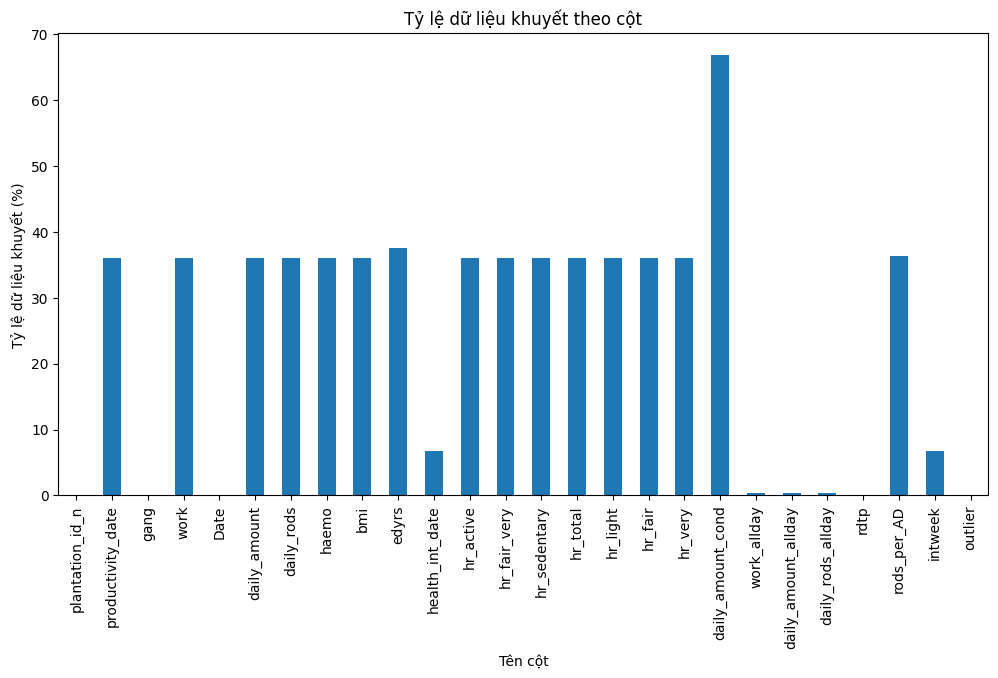

In [ ]:
missing_percentage = plot_missing_data(df)

In [ ]:
df.describe()

,plantation_id_n,productivity_date,gang,work,Date,daily_amount,daily_rods,haemo,bmi,edyrs,...,hr_fair,hr_very,daily_amount_cond,work_allday,daily_amount_allday,daily_rods_allday,rdtp,rods_per_AD,intweek,outlier
count,4944.000000,3162.00000,4944.000000,3162.000000,4944.000000,3162.000000,3162.000000,3162.000000,3162.000000,3087.000000,...,3162.000000,3162.000000,1644.000000,4927.000000,4927.000000,4927.000000,4944.000000,3145.000000,4608.000000,4944.000000
mean,348.150081,19430.35136,3.990291,0.519924,19433.505663,641.417160,286.594244,13.776818,22.661619,8.896663,...,2.109430,0.433887,1233.674611,0.477573,564.711577,252.265476,0.283172,409.561661,9.039497,0.152710
std,198.060191,15.96406,1.941046,0.499682,16.162423,1101.797846,492.035530,1.191145,2.456178,5.184541,...,1.725813,0.511115,1266.673171,0.499547,986.732234,440.639858,0.450585,3465.626034,0.844139,0.359744
min,17.000000,19406.00000,1.000000,0.000000,19406.000000,0.000000,0.000000,10.100000,15.241579,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000
25%,191.000000,19416.00000,2.000000,0.000000,19420.000000,0.000000,0.000000,13.100000,21.066744,5.000000,...,0.466667,0.016667,604.800000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000
50%,339.000000,19429.00000,4.000000,1.000000,19434.000000,246.400000,110.000000,13.900000,22.587835,12.000000,...,1.991667,0.266667,985.600000,0.000000,0.000000,0.000000,0.000000,14.224138,9.000000,0.000000
75%,509.000000,19443.00000,6.000000,1.000000,19447.250000,1008.000000,451.500000,14.500000,24.167162,12.000000,...,3.433333,0.683333,1546.000000,1.000000,907.200000,405.000000,1.000000,83.571434,10.000000,0.000000
max,695.000000,19461.00000,7.000000,1.000000,19461.000000,22108.800000,9870.000000,16.200000,29.031792,13.000000,...,7.650000,5.266667,22108.800000,1.000000,22108.800000,9870.000000,1.000000,157199.980000,11.000000,1.000000


#**5. Tiền xử lý dữ liệu**

In [ ]:
"""
  # Đổi datetime cho các cột Date, productivity_date, health_int_date
epoch_start = datetime(1970, 1, 1)
df['Date'] = epoch_start + pd.to_timedelta(df['Date'], unit='D')
df['productivity_date'] = epoch_start + pd.to_timedelta(df['productivity_date'], unit='D')
df['health_int_date']= epoch_start + pd.to_timedelta(df['health_int_date'], unit='D')

df['Date'] = pd.to_datetime(df['Date'])
df['productivity_date'] = pd.to_datetime(df['productivity_date'], errors='coerce')
df['health_int_date'] = pd.to_datetime(df['health_int_date'], errors='coerce')

# Tạo một danh sách các ngày trong cột 'Date'
dates = df['Date'].dt.date.unique()

# Tính toán trung bình số bản ghi mỗi ngày
average_records_per_day = len(df) / len(dates)

# Tạo một DataFrame mới với đầy đủ các ngày
full_dates = pd.DataFrame({'Date': pd.to_datetime(dates)})

# Chuyển đổi cột 'Date' trong full_dates thành datetime64[ns]
full_dates['Date'] = pd.to_datetime(full_dates['Date'])

# Sử dụng groupby và count để đếm số bản ghi cho mỗi ngày
records_per_day = df.groupby(df['Date'].dt.date).size()
# Đặt tên cho Series 'Records'
records_per_day.name = 'Records'
records_per_day.index = pd.to_datetime(records_per_day.index)

# Kết hợp DataFrame mới với số bản ghi mỗi ngày
full_dates = full_dates.merge(records_per_day, left_on='Date', right_index=True, how='left').fillna(0)
full_dates.columns = ['Date', 'Records']

# Tạo một danh sách các ngày thiếu bản ghi
missing_dates = full_dates[full_dates['Records'] < average_records_per_day]['Date'].dt.date

# Tạo các bản ghi mới cho các ngày thiếu
for date in missing_dates:
    # Tạo một DataFrame với các giá trị mặc định cho các cột cần thiết
    new_record = pd.DataFrame({'Date': [pd.to_datetime(date)],
                              'plantation_id_n': [0],
                              'productivity_date': [0],
                              'gang': [0],
                              # Thêm các cột cần thiết khác vào đây
                              'work': [0],
                              'daily_amount': [0],
                              'daily_rods': [0],
                              'haemo': [0],
                              'bmi': [0],
                              'edyrs': [0],
                              'health_int_date': [0],
                              'hr_active': [0],
                              'hr_fair_very': [0],
                              'hr_sedentary': [0],
                              'hr_total': [0],
                              'hr_light': [0],
                              'hr_fair': [0],
                              'hr_very': [0],
                              'daily_amount_cond': [0],
                              'work_allday': [0],
                              'daily_amount_allday': [0],
                              'daily_rods_allday': [0],
                              'rdtp': [0],
                              'rods_per_AD': [0],
                              'intweek': [0],
                              'outlier': [0]})

    # Nối bản ghi mới vào DataFrame ban đầu
    df = pd.concat([df, new_record], ignore_index=True)

# Sắp xếp lại DataFrame theo cột 'Date'
df = df.sort_values('Date')
"""
def add_Records(df):
    # Đổi datetime cho các cột Date, productivity_date, health_int_date
    epoch_start = datetime(1970, 1, 1)
    df['Date'] = epoch_start + pd.to_timedelta(df['Date'], unit='D')
    df['health_int_date'] = epoch_start + pd.to_timedelta(df['health_int_date'], unit='D')

    df['Date'] = pd.to_datetime(df['Date'])
    df['health_int_date'] = pd.to_datetime(df['health_int_date'], errors='coerce')

    # Tạo một danh sách các ngày trong cột 'Date'
    dates = df['Date'].dt.date.unique()

    # Tính toán số bản ghi lớn nhất trong một ngày
    max_records_per_day = df.groupby(df['Date'].dt.date).size().max()

    # Tạo một DataFrame mới với đầy đủ các ngày
    full_dates = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), end=df['Date'].max())})

    # Sử dụng groupby và count để đếm số bản ghi cho mỗi ngày
    records_per_day = df.groupby(df['Date'].dt.date).size()
    # Đặt tên cho Series 'Records'
    records_per_day.name = 'Records'
    records_per_day.index = pd.to_datetime(records_per_day.index)

    # Kết hợp DataFrame mới với số bản ghi mỗi ngày
    full_dates = full_dates.merge(records_per_day, left_on='Date', right_index=True, how='left').fillna(0)
    full_dates.columns = ['Date', 'Records']

    # Tạo một danh sách các ngày thiếu bản ghi
    missing_dates = full_dates[full_dates['Records'] < max_records_per_day]['Date'].dt.date

    # Tạo các bản ghi mới cho các ngày thiếu
    for date in missing_dates:
        records_on_date = full_dates[full_dates['Date'] == pd.to_datetime(date)]['Records'].values
        if len(records_on_date) > 0:
            num_records_to_add = max_records_per_day - records_on_date[0]
            new_records = []
            for _ in range(int(num_records_to_add)):
                # Tạo một DataFrame với các giá trị mặc định cho các cột cần thiết
                new_record = {
                    'Date': pd.to_datetime(date),
                    'plantation_id_n': np.nan,
                    'productivity_date': pd.NaT,
                    'gang': np.nan,
                    'work': np.nan,
                    'daily_amount': np.nan,
                    'daily_rods': np.nan,
                    'haemo': np.nan,
                    'bmi': np.nan,
                    'edyrs': np.nan,
                    'health_int_date': pd.NaT,
                    'hr_active': np.nan,
                    'hr_fair_very': np.nan,
                    'hr_sedentary': np.nan,
                    'hr_total': np.nan,
                    'hr_light': np.nan,
                    'hr_fair': np.nan,
                    'hr_very': np.nan,
                    'daily_amount_cond': np.nan,
                    'work_allday': np.nan,
                    'daily_amount_allday': np.nan,
                    'daily_rods_allday': np.nan,
                    'rdtp': np.nan,
                    'rods_per_AD': np.nan,
                    'intweek': np.nan,
                    'outlier': np.nan
                }
                new_records.append(new_record)
            # Nối các bản ghi mới vào DataFrame ban đầu
            df = pd.concat([df, pd.DataFrame(new_records)], ignore_index=True)

    # Sắp xếp lại DataFrame theo cột 'Date'
    df = df.sort_values('Date').reset_index(drop=True)

    return df

df = add_Records(df)

In [ ]:
def preprocess_data(df):
   # Chọn các cột liên quan đến sức khoẻ
    #selected_columns = ['Date', 'health_int_date', 'haemo', 'bmi', 'hr_active', 'hr_fair_very', 'hr_sedentary',
    #                    'hr_total', 'hr_light', 'hr_fair', 'hr_very']

    # Loại bỏ các cột không cần thiết
    #columns_to_drop = [col for col in df.columns if col not in selected_columns]
    #df = df.drop(columns=columns_to_drop)

    # Đổi datetime cho các cột Date, productivity_date, health_int_date
    #epoch_start = datetime(1970, 1, 1)
    #df['Date'] = epoch_start + pd.to_timedelta(df['Date'], unit='D')
    #df['productivity_date'] = epoch_start + pd.to_timedelta(df['productivity_date'], unit='D')
    #df['health_int_date']= epoch_start + pd.to_timedelta(df['health_int_date'], unit='D')

    df['Date'] = pd.to_datetime(df['Date'])
    #df['productivity_date'] = pd.to_datetime(df['productivity_date'], errors='coerce')
    df['health_int_date'] = pd.to_datetime(df['health_int_date'], errors='coerce')

    # Các cột còn lại nếu trống thì thay bằng NaN
    df = df.replace('', np.nan)

    # Chuẩn hóa dữ liệu
    columns_to_scale = ['daily_amount', 'daily_rods', 'haemo', 'bmi', 'hr_active', 'hr_fair_very', 'hr_sedentary',
                        'hr_total', 'hr_light', 'hr_fair', 'hr_very', 'work_allday', 'daily_amount_allday',
                        'daily_rods_allday', 'rdtp', 'rods_per_AD']
    scaler = MinMaxScaler()

    # Điền NaN tạm thời để chuẩn hóa, sau đó giữ nguyên NaN sau chuẩn hóa
    df[columns_to_scale] = df[columns_to_scale].apply(lambda x: x.fillna(x.mean()), axis=0)
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    df[columns_to_scale] = df[columns_to_scale].mask(df[columns_to_scale].isnull(), np.nan)

    return df

# Định dạng cột 'Date'
#epoch_start = datetime(1970, 1, 1)
#df['Date'] = epoch_start + pd.to_timedelta(df['Date'], unit='D')
#df['productivity_date'] = epoch_start + pd.to_timedelta(df['productivity_date'], unit='D')
#df['health_int_date']= epoch_start + pd.to_timedelta(df['health_int_date'], unit='D')

# Tiền xử lý dữ liệu
df_processed = preprocess_data(df)

"""
def preprocess_data(df):
    if 'daily_amount_cond' in df.columns:
        df.drop(columns=['daily_amount_cond'], inplace=True)

    # Đổi datetime cho các cột Date, productivity_date, health_int_date
    epoch_start = datetime(1970, 1, 1)
    df['Date'] = epoch_start + pd.to_timedelta(df['Date'], unit='D')
    df['productivity_date'] = epoch_start + pd.to_timedelta(df['productivity_date'], unit='D')
    df['health_int_date'] = epoch_start + pd.to_timedelta(df['health_int_date'], unit='D')

    df['Date'] = pd.to_datetime(df['Date'])
    df['productivity_date'] = pd.to_datetime(df['productivity_date'], errors='coerce')
    df['health_int_date'] = pd.to_datetime(df['health_int_date'], errors='coerce')

    # Các cột còn lại nếu trống thì thay bằng NaN
    df = df.replace('', np.nan)

    # Nhóm dữ liệu theo ngày và tính toán trung bình cho các cột định lượng
    df_grouped = df.groupby('Date').mean().reset_index()

    # Điền các giá trị thời gian bị thiếu
    def fill_missing_dates(df_temp):
        df_temp = df_temp.set_index('Date').asfreq('D').reset_index()
        return df_temp

    df_grouped = fill_missing_dates(df_grouped)

    # Chuẩn hóa dữ liệu
    columns_to_scale = ['daily_amount', 'daily_rods', 'haemo', 'bmi', 'hr_active', 'hr_fair_very', 'hr_sedentary',
                        'hr_total', 'hr_light', 'hr_fair', 'hr_very', 'work_allday', 'daily_amount_allday',
                        'daily_rods_allday', 'rdtp', 'rods_per_AD']
    scaler = MinMaxScaler()

    # Điền NaN tạm thời để chuẩn hóa, sau đó giữ nguyên NaN sau chuẩn hóa
    df_grouped[columns_to_scale] = df_grouped[columns_to_scale].apply(lambda x: x.fillna(x.mean()), axis=0)
    df_grouped[columns_to_scale] = scaler.fit_transform(df_grouped[columns_to_scale])
    df_grouped[columns_to_scale] = df_grouped[columns_to_scale].mask(df_grouped[columns_to_scale].isnull(), np.nan)

    return df_grouped

# Tiền xử lý dữ liệu
df_processed = preprocess_data(df)
"""

"\ndef preprocess_data(df):\n    if 'daily_amount_cond' in df.columns:\n        df.drop(columns=['daily_amount_cond'], inplace=True)\n\n    # Đổi datetime cho các cột Date, productivity_date, health_int_date\n    epoch_start = datetime(1970, 1, 1)\n    df['Date'] = epoch_start + pd.to_timedelta(df['Date'], unit='D')\n    df['productivity_date'] = epoch_start + pd.to_timedelta(df['productivity_date'], unit='D')\n    df['health_int_date'] = epoch_start + pd.to_timedelta(df['health_int_date'], unit='D')\n\n    df['Date'] = pd.to_datetime(df['Date'])\n    df['productivity_date'] = pd.to_datetime(df['productivity_date'], errors='coerce')\n    df['health_int_date'] = pd.to_datetime(df['health_int_date'], errors='coerce')\n\n    # Các cột còn lại nếu trống thì thay bằng NaN\n    df = df.replace('', np.nan)\n\n    # Nhóm dữ liệu theo ngày và tính toán trung bình cho các cột định lượng\n    df_grouped = df.groupby('Date').mean().reset_index()\n\n    # Điền các giá trị thời gian bị thiếu\n    de

In [ ]:
print(df_processed.tail(10))
print('Processed dataframe shape:', df_processed.shape)

      plantation_id_n productivity_date  gang  work       Date  daily_amount  \
4974            247.0           19461.0   3.0   0.0 2023-04-14      0.000000   
4975            216.0           19461.0   3.0   0.0 2023-04-14      0.000000   
4976            547.0           19461.0   6.0   0.0 2023-04-14      0.000000   
4977            413.0               NaN   5.0   NaN 2023-04-14      0.029012   
4978            675.0               NaN   7.0   NaN 2023-04-14      0.029012   
4979            438.0               NaN   5.0   NaN 2023-04-14      0.029012   
4980            240.0               NaN   3.0   NaN 2023-04-14      0.029012   
4981            287.0               NaN   3.0   NaN 2023-04-14      0.029012   
4982            611.0               NaN   7.0   NaN 2023-04-14      0.029012   
4983              NaN               NaN   NaN   NaN 2023-04-14      0.029012   

      daily_rods     haemo       bmi  edyrs  ...   hr_fair   hr_very  \
4974    0.000000  0.868852  0.488010   13.0  ..

#**6. Khám phá dữ liệu**

##**Phân phối tần suất thời gian**

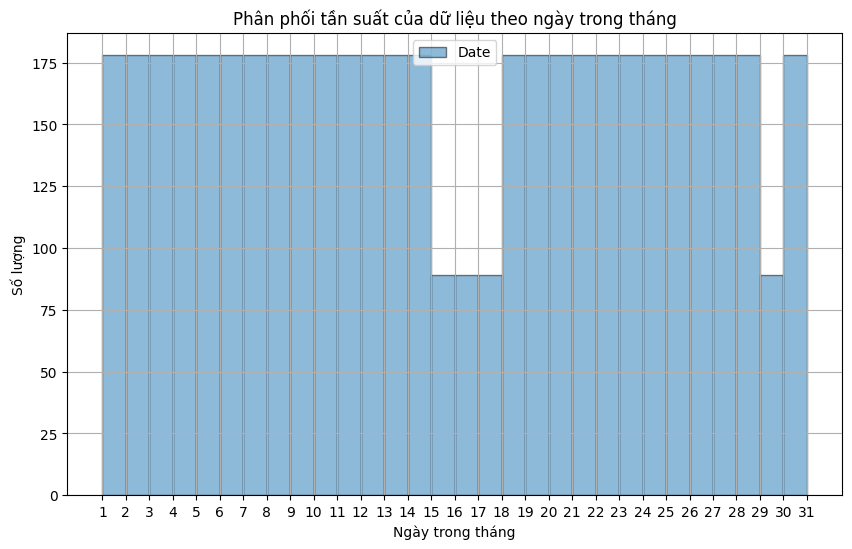

In [ ]:
"""
def dayOfMonthGraph(datasets):
    # Khởi tạo figure
    plt.figure(figsize=(10, 6))

    # Lặp qua từng bộ dữ liệu và tên cột thời gian
    for dataset, date_column in datasets:
        # Chuyển đổi cột ngày sang định dạng datetime
        date_data = pd.to_datetime(dataset[date_column])
        # Trích xuất ngày trong tháng từ các đối tượng datetime
        days_of_month = [date.day for date in date_data]
        # Vẽ biểu đồ histogram
        plt.hist(days_of_month, bins=range(1, 32), edgecolor='black', alpha=0.5, label=date_column)

    # Thiết lập tiêu đề và nhãn trục
    plt.xlabel('Ngày trong tháng')
    plt.ylabel('Số lượng')
    plt.title('Phân phối tần suất của dữ liệu theo ngày trong tháng')
    plt.xticks(range(1, 32))
    plt.grid(True)
    plt.legend()  # Hiển thị chú thích về tên của mỗi bộ dữ liệu
    plt.show()

# Gọi hàm dayOfMonthGraph với DataFrame của bạn
dayOfMonthGraph([(df, 'Date')])
"""
def dayOfMonthGraph(datasets):
    # Khởi tạo figure
    plt.figure(figsize=(10, 6))

    # Lặp qua từng bộ dữ liệu và tên cột thời gian
    for dataset, date_column in datasets:
        # Chuyển đổi cột ngày sang định dạng datetime
        date_data = pd.to_datetime(dataset[date_column])
        # Trích xuất ngày trong tháng từ các đối tượng datetime
        days_of_month = [date.day for date in date_data]
        # Vẽ biểu đồ histogram
        plt.hist(days_of_month, bins=range(1, 32), edgecolor='black', alpha=0.5, label=date_column)

    # Thiết lập tiêu đề và nhãn trục
    plt.xlabel('Ngày trong tháng')
    plt.ylabel('Số lượng')
    plt.title('Phân phối tần suất của dữ liệu theo ngày trong tháng')
    plt.xticks(range(1, 32))
    plt.grid(True)
    plt.legend()  # Hiển thị chú thích về tên của mỗi bộ dữ liệu
    plt.show()

# Gọi hàm dayOfMonthGraph với DataFrame của bạn
dayOfMonthGraph([(df_processed, 'Date')])

##**Tính time step**

In [ ]:
def find_time_steps(dataset):
  dataset['Date'] = dataset['Date'].sort_values()
  time_differences = dataset['Date'].diff()
  if all(time_differences == time_differences[0]):
      time_step = time_differences[0]
      print(f"Time step: {time_step}")
  else:
      print("Không có time step cố định.")
      average_time_step = time_differences.mean()
      print(f"Average time step: {average_time_step}")

In [ ]:
find_time_steps(df)

Không có time step cố định.
Average time step: 0 days 00:15:53.642384105


##**Trend, Cycle**

###**Hồi quy tuyến tính và ACF**

In [ ]:
def calculate_trend(data):
    # Xử lý giá trị NaN: Loại bỏ các dòng chứa giá trị NaN
    data_cleaned = data.dropna()

    # Giữ lại cột Date nếu có và sử dụng nó làm chỉ số thời gian
    if 'Date' in data_cleaned.columns:
        data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])
        data_cleaned = data_cleaned.sort_values('Date')  # Sắp xếp theo cột Date
        data_cleaned.set_index('Date', inplace=True)

    # Loại bỏ các cột không cần thiết nếu tồn tại
    for col in ['productivity_date', 'health_int_date', 'daily_amount_cond']:
        if col in data_cleaned.columns:
            data_cleaned = data_cleaned.drop([col], axis=1)

    column_names = list(data_cleaned.columns)
    num_subplots = len(column_names)  # Số lượng subplot bằng số cột dữ liệu

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

    # Vẽ biểu đồ dữ liệu và đường trend cho từng thuộc tính
    for idx, col in enumerate(column_names):
        if 'Date' in data_cleaned.index.names:
            X = np.array((data_cleaned.index - data_cleaned.index[0]).days).reshape(-1, 1)
        else:
            X = np.array(range(len(data_cleaned))).reshape(-1, 1)

        y = data_cleaned[col].values.reshape(-1, 1)

        # Khởi tạo và fit mô hình hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X, y)
        trend = model.coef_[0][0]  # Hệ số góc của đường trend

        # Vẽ dữ liệu
        axes[idx].plot(data_cleaned.index, data_cleaned[col], label=col)
        # Vẽ trend line
        axes[idx].plot(data_cleaned.index, model.predict(X), label=f'Trend of {col}', linestyle='--')

        # Xác định xu hướng và tạo dòng thông báo
        if trend > 0:
            trend_text = 'Xu hướng tăng'
        else:
            trend_text = 'Xu hướng giảm'

        axes[idx].set_xlabel('Date' if 'Date' in data_cleaned.index.names else 'Index')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Trend of {col} - {trend_text}')
        axes[idx].legend(loc="best")

    plt.tight_layout()  # Đảm bảo không gian giữa các subplot
    plt.show()

<ipython-input-17-8258872961c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])


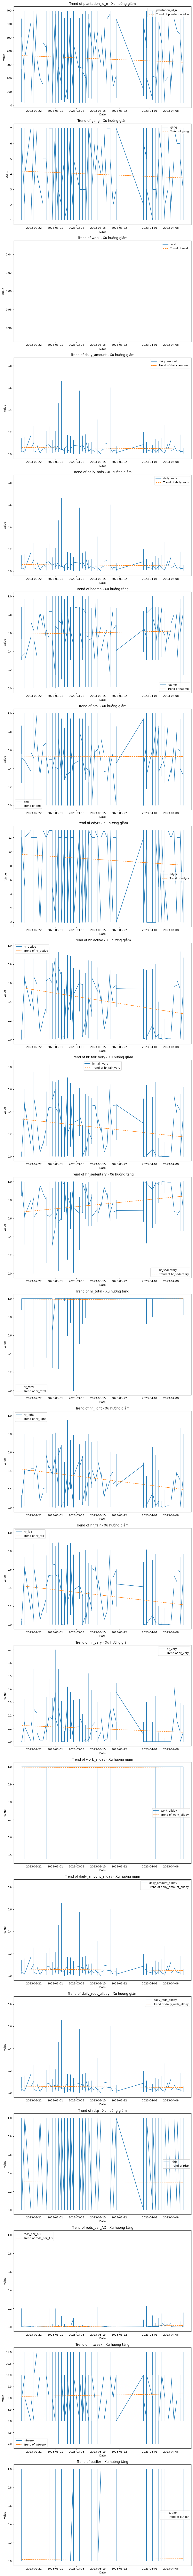

None


In [ ]:
trend = calculate_trend(df_processed)
print(trend)

In [ ]:
def find_cycle(data, column, lags=50):
    """
    Hàm tính chu kỳ của dữ liệu chuỗi thời gian dựa trên hàm tự tương quan (ACF).

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    column : str
        Tên cột chứa dữ liệu chuỗi thời gian cần tính chu kỳ.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycle : int
        Chu kỳ của dữ liệu chuỗi thời gian.
    comment : str
        Lời nhận xét về chu kỳ của cột dữ liệu.
    """
    # Xóa các giá trị thiếu
    data_cleaned = data.dropna(subset=[column])

    # Tính toán ACF
    acf_values = acf(data_cleaned[column], nlags=lags)

    # Tìm độ trễ (lag) tại đó ACF đạt cực đại (bỏ qua độ trễ 0)
    cycle = np.argmax(acf_values[1:]) + 1

    # Vẽ biểu đồ ACF
    plt.figure(figsize=(10, 6))
    plot_acf(data_cleaned[column], lags=lags)
    plt.title(f'Autocorrelation Function for {column}')
    plt.show()

    # Lời nhận xét
    if cycle == 1:
        comment = "Cột này có thể không có chu kỳ rõ ràng hoặc chu kỳ ngắn."
    elif cycle > 1 and cycle <= 10:
        comment = "Cột này thể hiện một chu kỳ ngắn."
    elif cycle > 10 and cycle <= 30:
        comment = "Cột này thể hiện một chu kỳ vừa."
    else:
        comment = "Cột này thể hiện một chu kỳ dài."

    return cycle, comment

def find_cycles_for_all_columns(data, lags=50):
    """
    Hàm tính chu kỳ và cung cấp lời nhận xét cho tất cả các cột trong DataFrame.

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycles_info : dict
        Từ điển chứa thông tin chu kỳ và lời nhận xét của mỗi cột trong DataFrame.
    """
    cycles_info = {}
    for column in data.columns:
        if np.issubdtype(data[column].dtype, np.number):  # Chỉ tính chu kỳ cho các cột số
            cycle, comment = find_cycle(data, column, lags)

            cycles_info[column] = {'cycle': cycle, 'comment': comment}
        else:
            cycles_info[column] = {'cycle': None, 'comment': "Không phải cột dữ liệu số."}

    return cycles_info



<Figure size 1000x600 with 0 Axes>

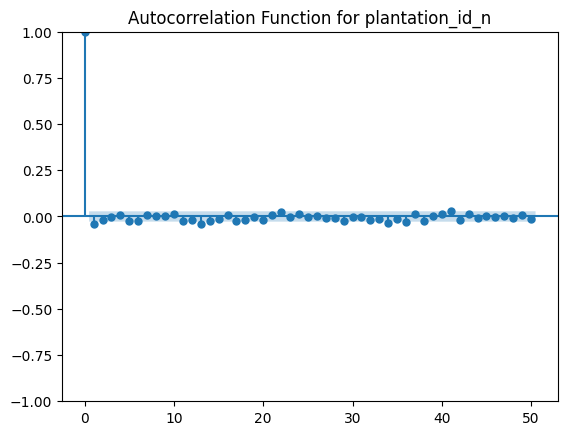

<Figure size 1000x600 with 0 Axes>

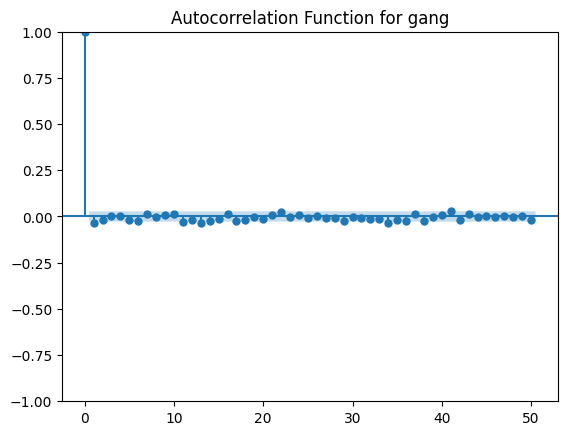

<Figure size 1000x600 with 0 Axes>

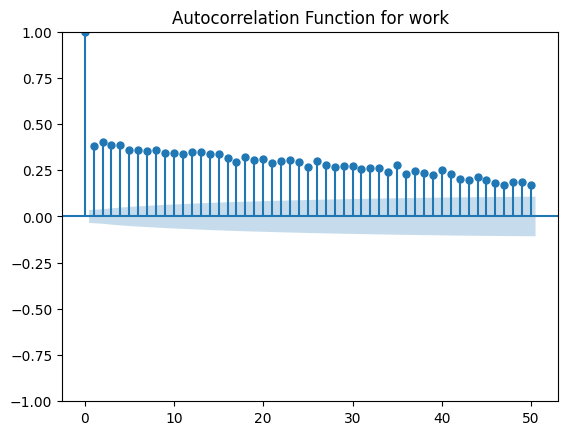

<Figure size 1000x600 with 0 Axes>

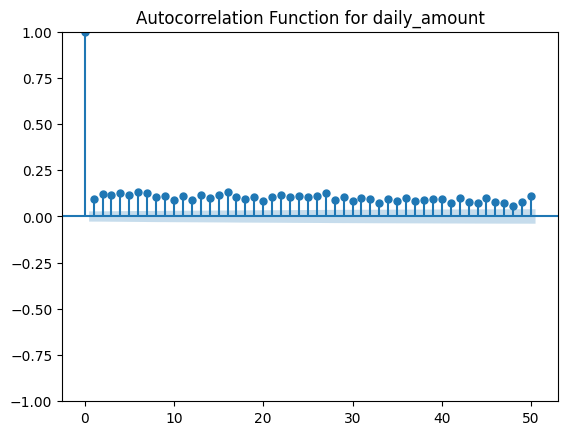

<Figure size 1000x600 with 0 Axes>

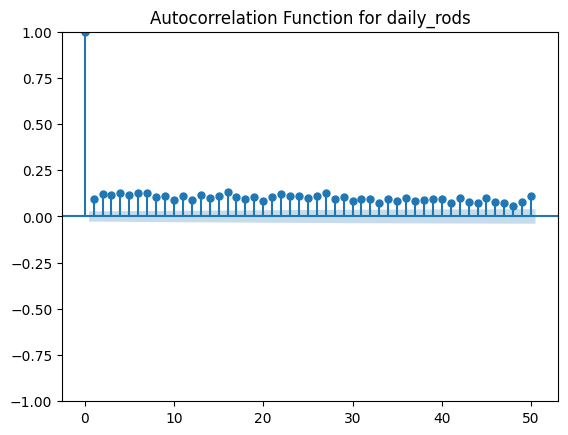

<Figure size 1000x600 with 0 Axes>

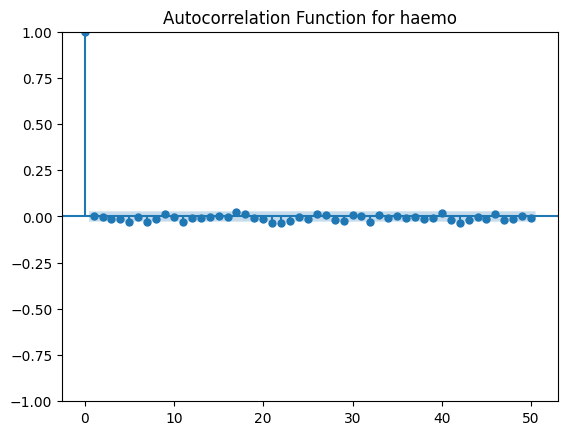

<Figure size 1000x600 with 0 Axes>

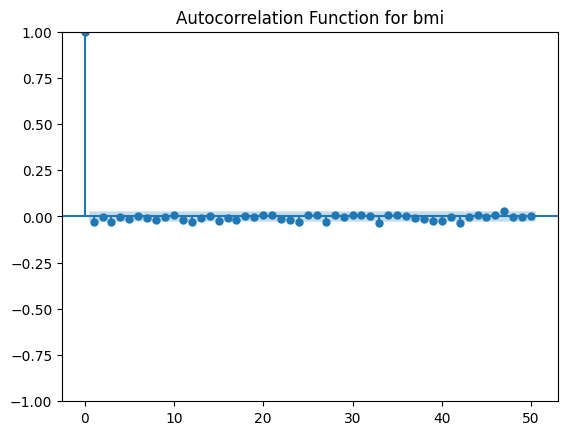

<Figure size 1000x600 with 0 Axes>

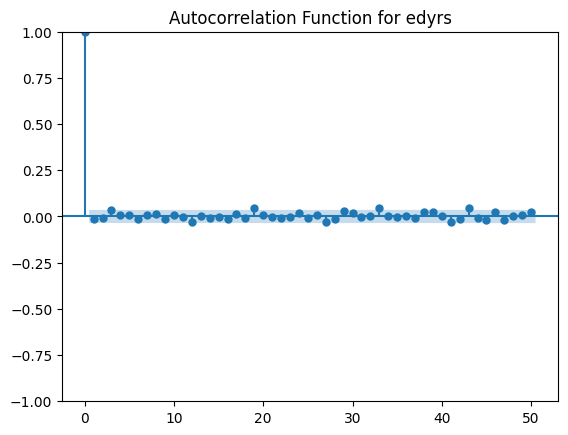

<Figure size 1000x600 with 0 Axes>

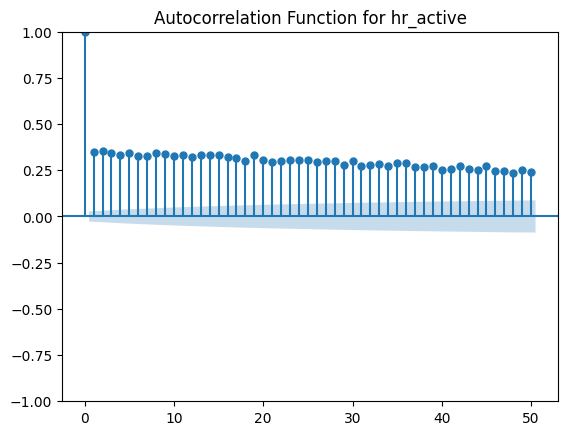

<Figure size 1000x600 with 0 Axes>

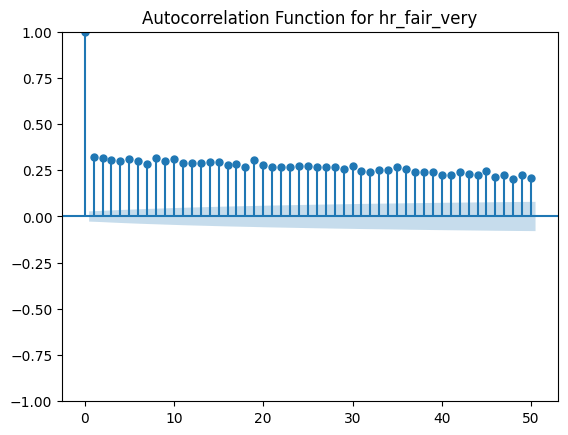

<Figure size 1000x600 with 0 Axes>

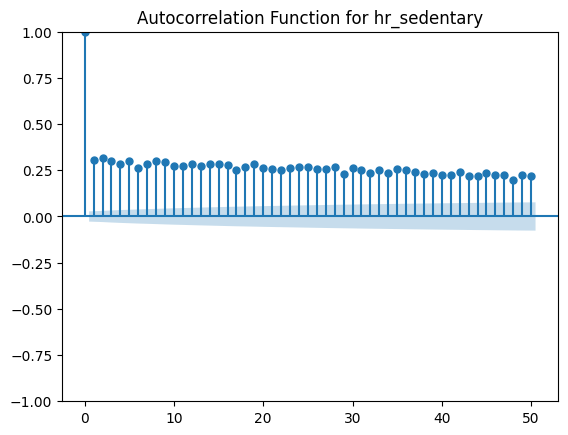

<Figure size 1000x600 with 0 Axes>

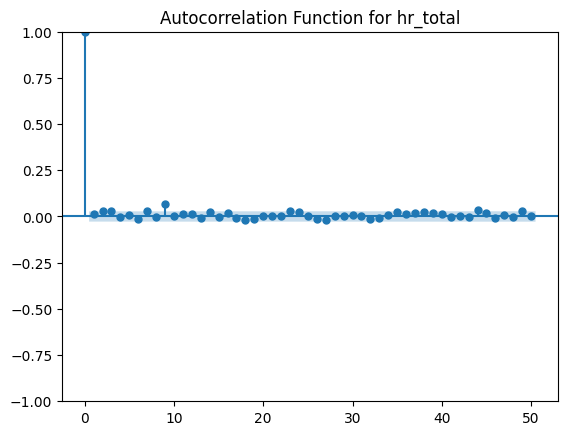

<Figure size 1000x600 with 0 Axes>

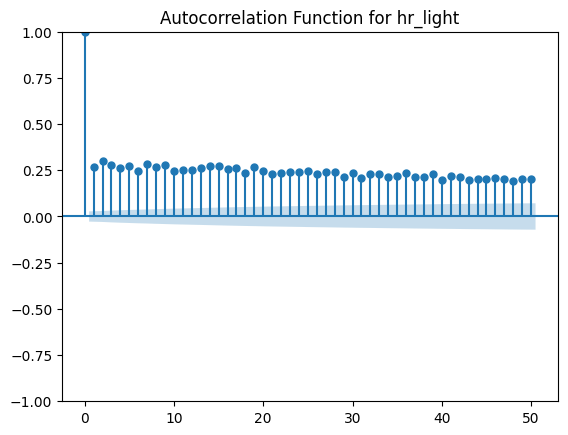

<Figure size 1000x600 with 0 Axes>

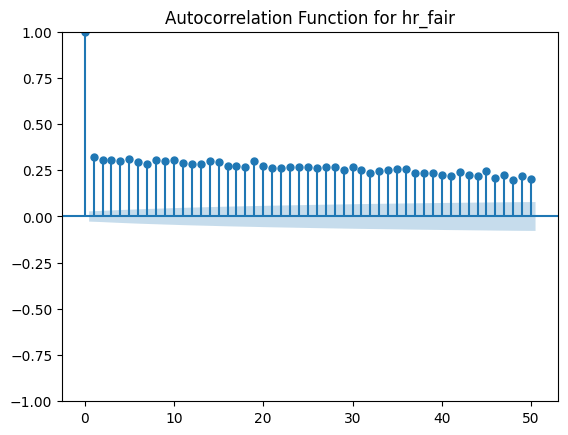

<Figure size 1000x600 with 0 Axes>

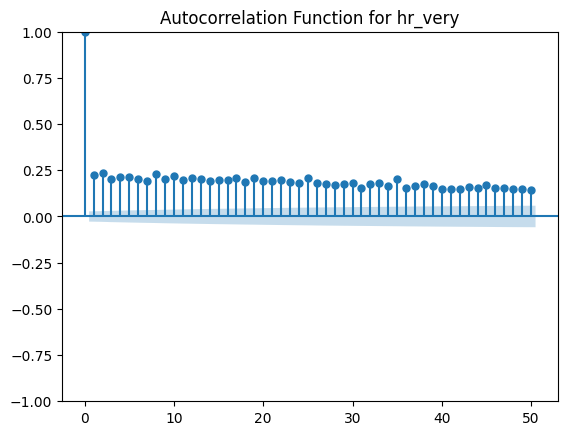

<Figure size 1000x600 with 0 Axes>

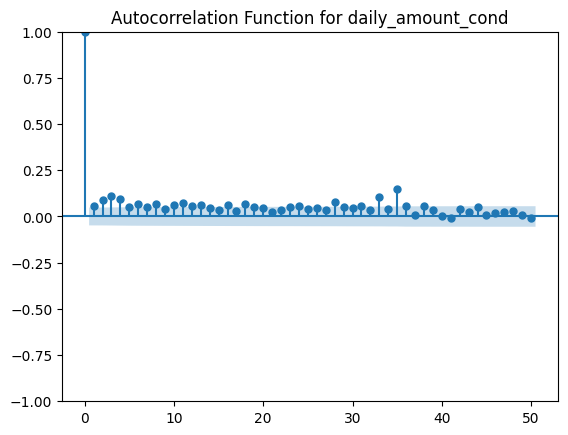

<Figure size 1000x600 with 0 Axes>

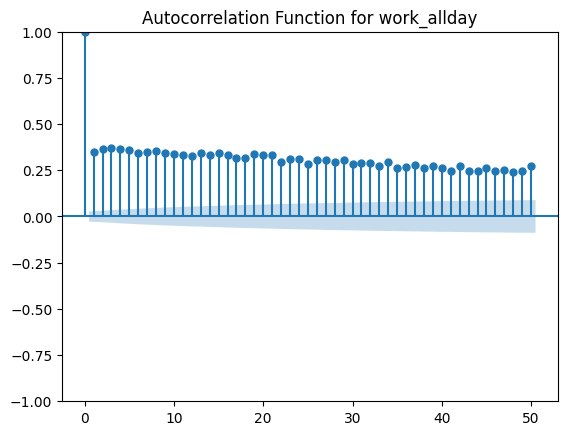

<Figure size 1000x600 with 0 Axes>

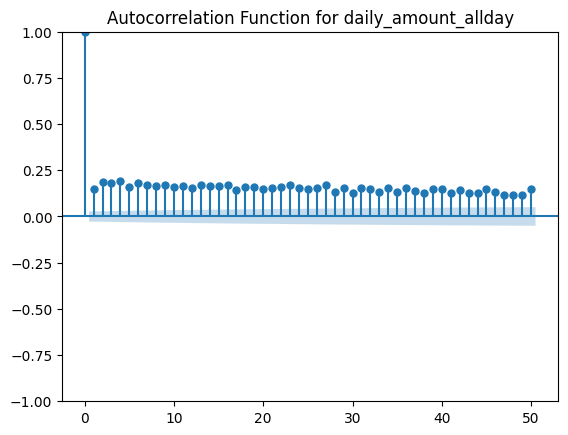

<Figure size 1000x600 with 0 Axes>

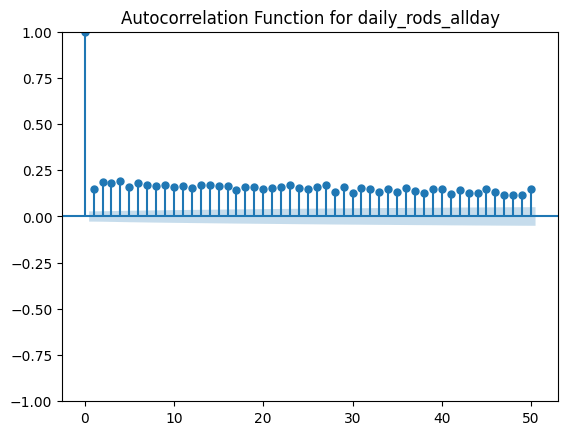

<Figure size 1000x600 with 0 Axes>

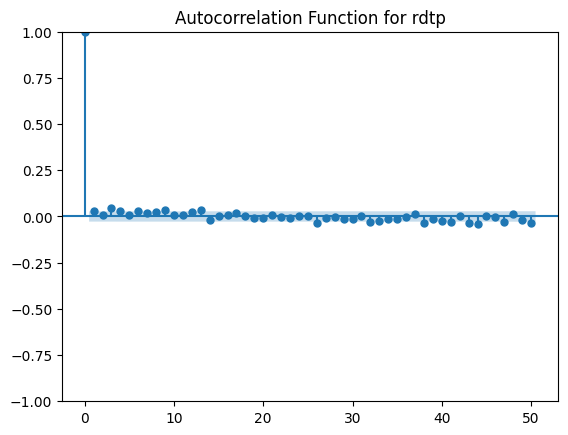

<Figure size 1000x600 with 0 Axes>

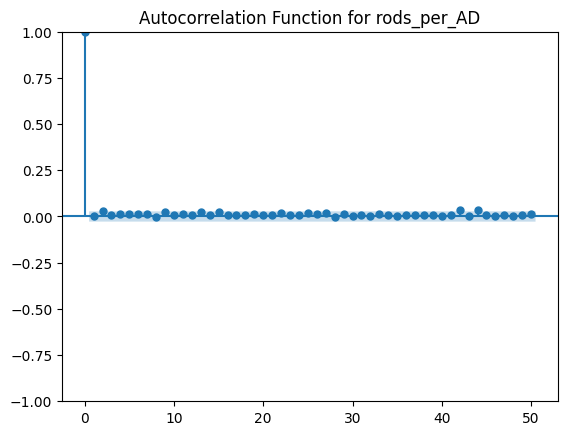

<Figure size 1000x600 with 0 Axes>

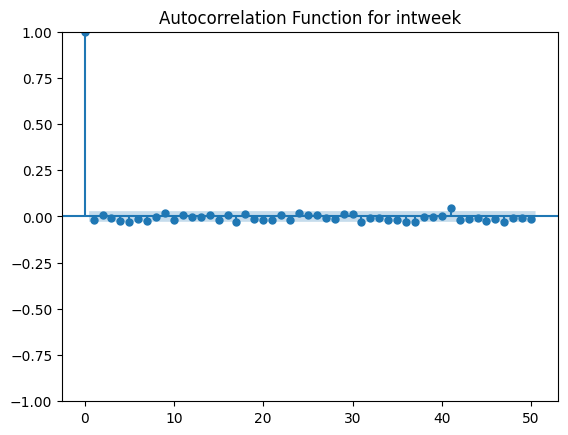

<Figure size 1000x600 with 0 Axes>

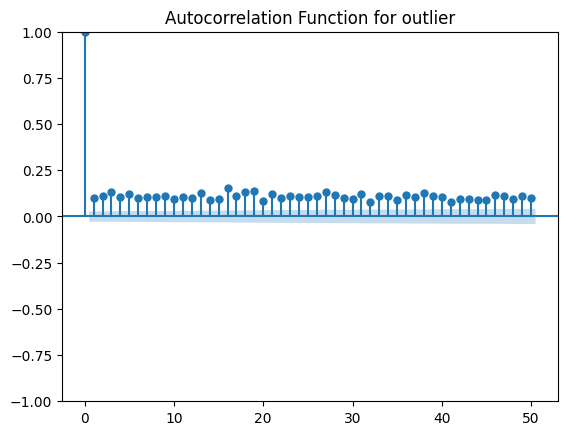

Column 'plantation_id_n': Cycle = 41. Cột này thể hiện một chu kỳ dài.
Column 'productivity_date': Cycle = None. Không phải cột dữ liệu số.
Column 'gang': Cycle = 41. Cột này thể hiện một chu kỳ dài.
Column 'work': Cycle = 2. Cột này thể hiện một chu kỳ ngắn.
Column 'Date': Cycle = None. Không phải cột dữ liệu số.
Column 'daily_amount': Cycle = 16. Cột này thể hiện một chu kỳ vừa.
Column 'daily_rods': Cycle = 16. Cột này thể hiện một chu kỳ vừa.
Column 'haemo': Cycle = 17. Cột này thể hiện một chu kỳ vừa.
Column 'bmi': Cycle = 47. Cột này thể hiện một chu kỳ dài.
Column 'edyrs': Cycle = 43. Cột này thể hiện một chu kỳ dài.
Column 'health_int_date': Cycle = None. Không phải cột dữ liệu số.
Column 'hr_active': Cycle = 2. Cột này thể hiện một chu kỳ ngắn.
Column 'hr_fair_very': Cycle = 1. Cột này có thể không có chu kỳ rõ ràng hoặc chu kỳ ngắn.
Column 'hr_sedentary': Cycle = 2. Cột này thể hiện một chu kỳ ngắn.
Column 'hr_total': Cycle = 9. Cột này thể hiện một chu kỳ ngắn.
Column 'hr_lig

In [ ]:
# Sử dụng hàm find_cycles_for_all_columns để tính toán chu kỳ và lời nhận xét cho các cột
cycles_info = find_cycles_for_all_columns(df_processed)

# In ra kết quả
for column, info in cycles_info.items():
    print(f"Column '{column}': Cycle = {info['cycle']}. {info['comment']}")

###**Arima và Sarima** (dữ liệu không đủ để thực hiện)

In [ ]:
'''
def calculate_trend(data, columns, order=(1, 1, 1)):
    trends = pd.DataFrame(index=data.index)
    for column in columns:
        column_data = data[column].dropna()
        if len(column_data) > 0:  # Kiểm tra nếu có dữ liệu sau khi loại bỏ NaN
            model = ARIMA(column_data, order=order)
            model_fit = model.fit()
            trend = model_fit.predict(typ='levels')
            trends[column + '_Trend'] = trend.reindex(data.index, fill_value=np.nan)
    return trends
    '''
def calculate_trend(data, columns, order=(1, 1, 1)):
    trends = pd.DataFrame(index=data.index)
    for column in columns:
        column_data = data[column].dropna()
        if len(column_data) > 5:  # Kiểm tra nếu có đủ dữ liệu sau khi loại bỏ NaN
            try:
                model = ARIMA(column_data, order=order)
                model_fit = model.fit()
                trend = model_fit.predict(typ='levels')
                trends[column + '_Trend'] = trend.reindex(data.index, method='nearest')
            except Exception as e:
                print(f"Error fitting ARIMA for column {column}: {e}")
    return trends

In [ ]:
def fit_sarima(data, seasonal_order=(0, 0, 0, 0)):
    sarima_model = SARIMAX(data, order=(1, 1, 1), seasonal_order=seasonal_order)
    try:
        fitted_model = sarima_model.fit(maxiter=200, disp=False, method='powell')  # Tăng số lần lặp tối đa và sử dụng phương pháp Powell
    except Exception as e:
        print(f"Error fitting SARIMA: {e}")
        fitted_model = None
    return fitted_model

In [ ]:
def set_frequency(data, frequency):
    data = data.set_index('Date')
    data = data.sort_index()
    data = data.asfreq(frequency)
    if data.isnull().values.any():
        data = data.interpolate(method='spline', limit_direction='forward')  # Hoặc sử dụng phương pháp 'nearest', 'polynomial', 'spline'
        data = data.dropna()
    return data

In [ ]:
# Áp dụng hàm set_frequency và in ra kết quả
 # Loại bỏ các bản ghi trùng lặp
df_copy = df_copy.drop_duplicates(subset='Date')

df_copy = set_frequency(df_copy, frequency)
print(df_copy.head())  # In ra một số dòng đầu của df_copy để kiểm tra


Empty DataFrame
Columns: [plantation_id_n, productivity_date, gang, work, daily_amount, daily_rods, haemo, bmi, edyrs, health_int_date, hr_active, hr_fair_very, hr_sedentary, hr_total, hr_light, hr_fair, hr_very, work_allday, daily_amount_allday, daily_rods_allday, rdtp, rods_per_AD, intweek, outlier, daily_amount_cond]
Index: []

[0 rows x 25 columns]


In [ ]:
'''
def calculate_seasonal_cycles(data, columns, period):
    seasonal_cycles = pd.DataFrame(index=data.index)
    for column in columns:
        column_data = data[column].dropna()
        if len(column_data) > 0:
            sarima_model = fit_sarima(column_data, seasonal_order=(0, 1, 1, period))
            fitted_values = sarima_model.fittedvalues
            seasonal_cycle = column_data - fitted_values
            seasonal_cycles[column + '_Seasonal'] = seasonal_cycle.reindex(data.index, fill_value=np.nan)
    return seasonal_cycles

def calculate_seasonal_cycles(data, columns, period):
    seasonal_cycles = pd.DataFrame(index=data.index)
    for column in columns:
        column_data = data[column].dropna()
        if len(column_data) > period:  # Kiểm tra nếu có đủ dữ liệu
            sarima_model = fit_sarima(column_data, seasonal_order=(0, 1, 1, period))
            fitted_values = sarima_model.fittedvalues
            seasonal_cycle = column_data - fitted_values
            seasonal_cycles[column + '_Seasonal'] = seasonal_cycle.reindex(data.index, method='nearest')
    return seasonal_cycles
    '''
def calculate_seasonal_cycles(data, columns, period):
    seasonal_cycles = pd.DataFrame(index=data.index)
    for column in columns:
        column_data = data[column].dropna()
        if len(column_data) > period:  # Kiểm tra nếu có đủ dữ liệu
            sarima_model = fit_sarima(column_data, seasonal_order=(0, 1, 1, period))
            if sarima_model is not None:
                fitted_values = sarima_model.fittedvalues
                seasonal_cycle = column_data - fitted_values
                seasonal_cycles[column + '_Seasonal'] = seasonal_cycle.reindex(data.index, method='nearest')
    return seasonal_cycles

In [ ]:
def plot_trends_and_cycles(original_data, trend_data, cycle_data, columns):
    plt.figure(figsize=(12, 20))
    for i, column in enumerate(columns):
        plt.subplot(len(columns), 1, i + 1)
        plt.plot(original_data[column], label='Original', color='blue')
        if column + '_Trend' in trend_data:
            plt.plot(trend_data[column + '_Trend'], label='Trend', color='green')
        if column + '_Seasonal' in cycle_data:
            plt.plot(cycle_data[column + '_Seasonal'], label='Seasonal Cycle', color='orange')
        plt.title(f'{column}')
        plt.legend()
    plt.tight_layout()
    plt.show()


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
['plantation_id_n', 'gang', 'work', 'daily_amount', 'daily_rods', 'haemo', 'bmi', 'edyrs', 'hr_active', 'hr_fair_very', 'hr_sedentary', 'hr_total', 'hr_light', 'hr_fair', 'hr_very', 'work_allday', 'daily_amount_allday', 'daily_rods_allday', 'rdtp', 'rods_per_AD', 'intweek', 'outlier', 'daily_amount_cond']


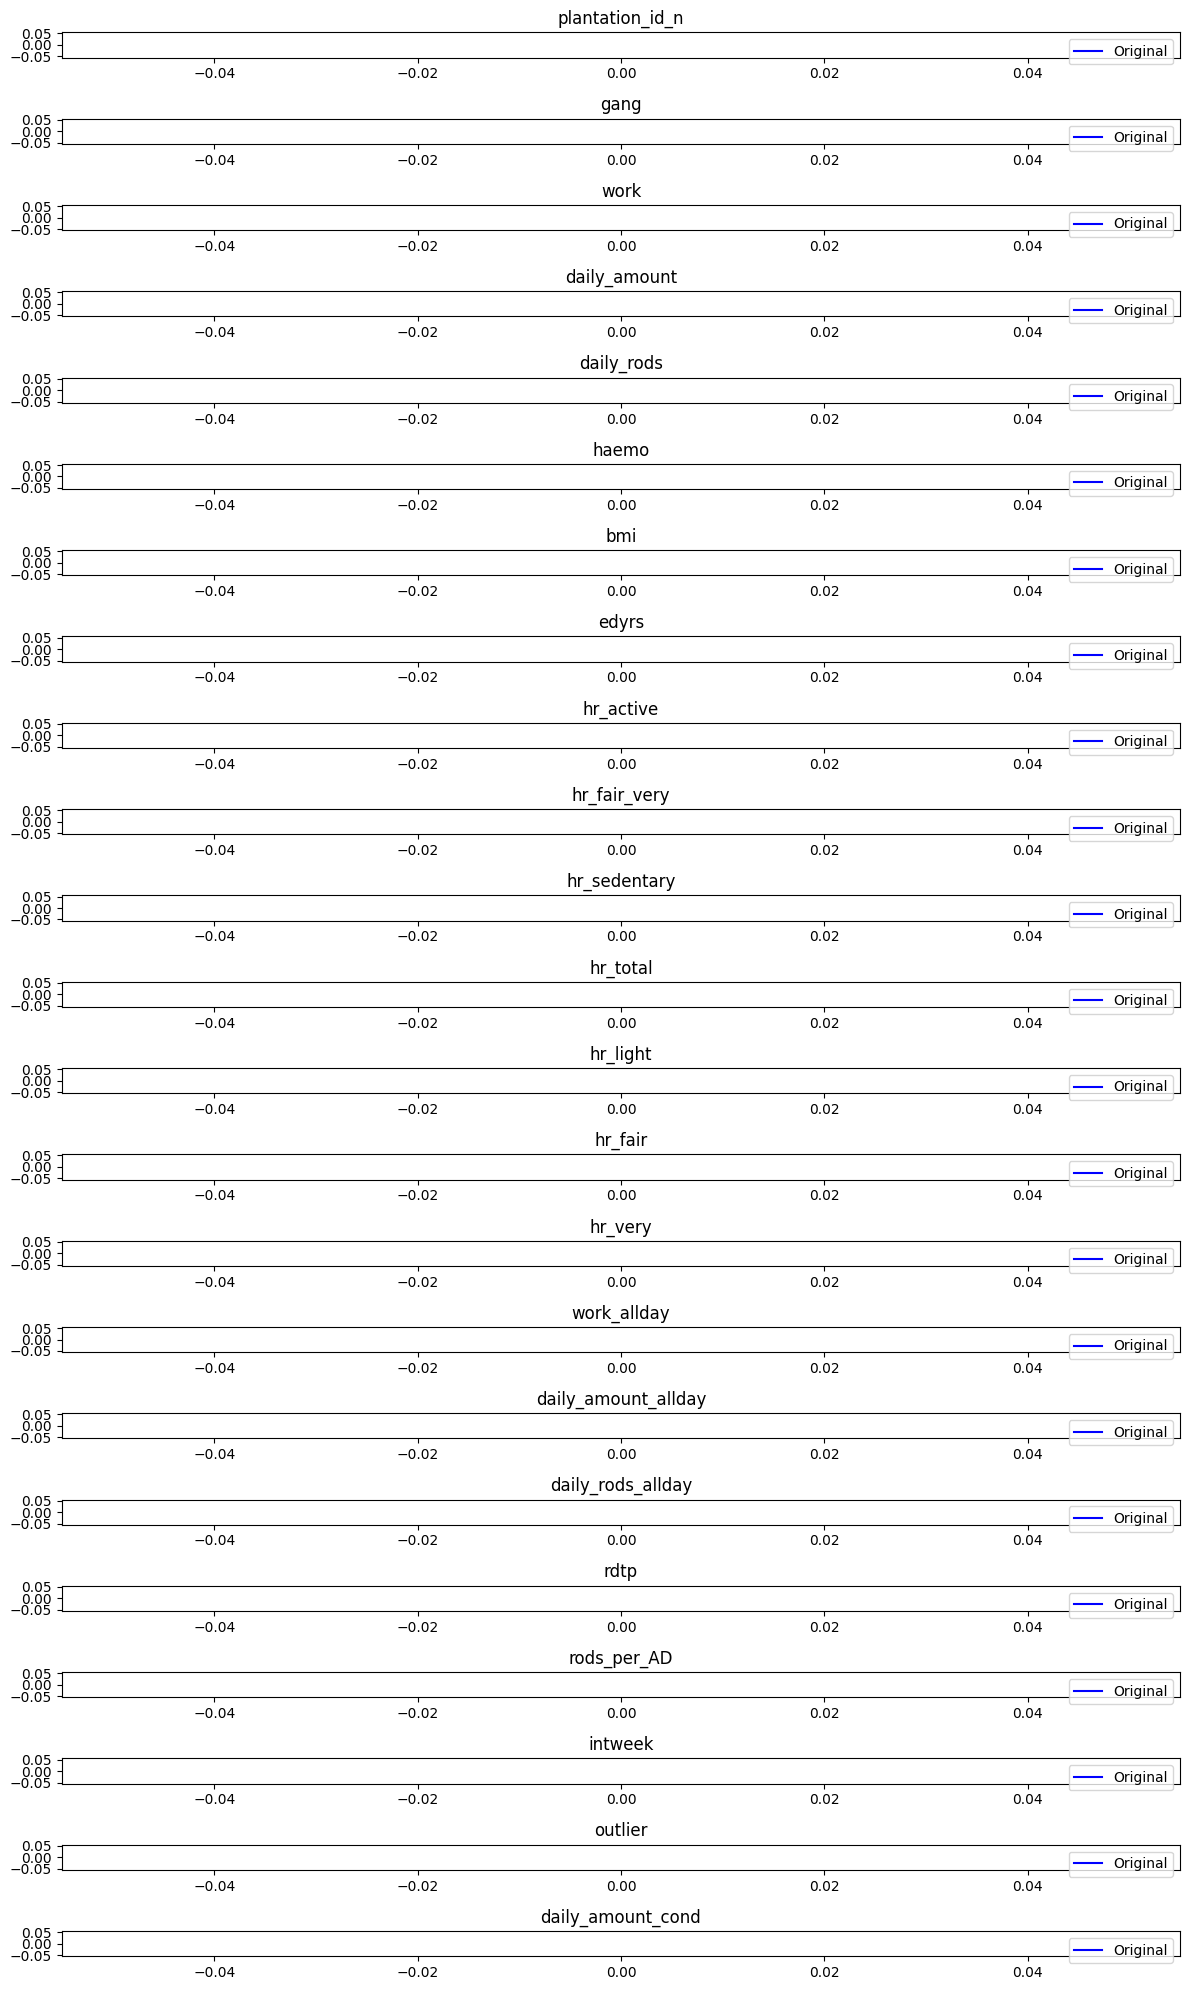

      plantation_id_n    productivity_date  gang  work       Date  \
2649             45.0                  NaT   1.0   NaN 2023-02-18   
3910            641.0                  NaT   7.0   NaN 2023-02-18   
2309            482.0  2023-02-18 00:00:00   5.0   0.0 2023-02-18   
3908            273.0  2023-02-18 00:00:00   3.0   0.0 2023-02-18   
3162            463.0                  NaT   5.0   NaN 2023-02-18   

      daily_amount  daily_rods  haemo        bmi  edyrs  ...   hr_fair  \
2649           NaN         NaN    NaN        NaN    NaN  ...       NaN   
3910           NaN         NaN    NaN        NaN    NaN  ...       NaN   
2309           0.0         0.0   15.4  23.889463   12.0  ...  0.216667   
3908           0.0         0.0   12.8  24.419281    0.0  ...  2.216667   
3162           NaN         NaN    NaN        NaN    NaN  ...       NaN   

       hr_very  work_allday  daily_amount_allday  daily_rods_allday  rdtp  \
2649       NaN          0.0                  0.0               

In [ ]:
def process_data(df_copy, frequency='15T', period=96):
    # Loại bỏ các bản ghi trùng lặp
    #df_copy = df_copy.drop_duplicates(subset='Date')

    # Sắp xếp lại chỉ mục theo thứ tự thời gian
    # Hàm set_frequency phải được định nghĩa chính xác
    df_copy = set_frequency(df_copy, frequency)

    columns_to_calculate = df_copy.columns.tolist()
    columns_to_calculate = [col for col in columns_to_calculate if col not in ['productivity_date', 'health_int_date']]

    # Tính toán trend cho các cột cụ thể
    trend_df = calculate_trend(df_copy, columns_to_calculate, order=(1, 1, 1))

    # In ra một số dòng đầu của trend_df để kiểm tra
    print(trend_df.head())

    # Giải phóng bộ nhớ không cần thiết
    gc.collect()

    # Thêm các cột trend vào DataFrame gốc
    df_copy = df_copy.join(trend_df)

    # Xác định chu kỳ
    seasonal_cycles_df = calculate_seasonal_cycles(df_copy, columns_to_calculate, period)

    # In ra một số dòng đầu của seasonal_cycles_df để kiểm tra
    print(seasonal_cycles_df.head())

    # Giải phóng bộ nhớ không cần thiết
    gc.collect()

    # Thêm các cột chu kỳ vào DataFrame gốc
    df_copy = df_copy.join(seasonal_cycles_df)

    # In ra danh sách các cột
    print(columns_to_calculate)

    # Vẽ biểu đồ xu hướng và chu kỳ
    plot_trends_and_cycles(df_copy, trend_df, seasonal_cycles_df, columns_to_calculate)

    return df_copy

if __name__ == "__main__":
    # Giả sử df_copy là DataFrame đã được tải vào từ trước
    # df_copy = pd.read_csv('your_file.csv') # hoặc tải từ dataset khác

    # Ví dụ về sử dụng:
    frequency = '15T'  # Điều chỉnh giá trị này nếu cần
    period = 96  # Điều chỉnh giá trị này nếu cần

    # Gọi hàm process_data với các tham số tương ứng
    processed_df = process_data(df_copy, frequency=frequency, period=period)

    # Lưu DataFrame kết quả vào file CSV
    processed_df.to_csv('output.csv')

    # In ra một số dòng đầu của df_copy để kiểm tra
    print(df_copy.head())

In [ ]:
# Hiển thị kết quả
print(trend_df.head())
print(seasonal_cycles_df.head())

NameError: name 'trend_df' is not defined

In [ ]:
print(df.shape)

(56, 66)


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def calculate_trend(ts, period):
    decomposition = seasonal_decompose(ts, model='additive', period=period)
    trend = decomposition.trend
    return trend

In [ ]:
# Hàm tính toán xu hướng (Trend)
def calculate_trend(ts):
    decomposition = seasonal_decompose(ts, model='additive', period=96)  # 96 periods for 24 hours with 15-minute intervals
    trend = decomposition.trend
    return trend

# Đảm bảo cột 'Date' là chỉ mục và có kiểu dữ liệu datetime
df_processed['Date'] = pd.to_datetime(df_processed['Date'])
df_processed.set_index('Date', inplace=True)

# Đảm bảo rằng chỉ mục của DataFrame có kiểu datetime
df_processed.index = pd.to_datetime(df_processed.index)

# Sử dụng cột 'daily_amount' làm chuỗi thời gian và đặt tần số (frequency) thành 15 phút
ts = df_processed['daily_amount'].asfreq('15T', method='pad')  # Pad giá trị để có dữ liệu liên tục

# Tính toán xu hướng
trend = calculate_trend(ts)

# Thêm xu hướng vào DataFrame gốc
df_processed['Trend'] = trend

# Kết quả cuối cùng
print(df_processed[['daily_amount', 'Trend']])


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# Tính trend của tập dữ liệu khi loại bỏ các giá trị bị thiếu
def calculate_trend(data):
    # Xử lý giá trị NaN: Loại bỏ các dòng chứa giá trị NaN
    data_cleaned = data.dropna()

    # Loại bỏ các cột không cần thiết nếu tồn tại
    for col in ['time', 'station', 'Unnamed: 0', 'date', 'Date']:
        if col in data_cleaned.columns:
            data_cleaned = data_cleaned.drop([col], axis=1)

    column_names = list(data_cleaned.columns)
    num_subplots = len(column_names)  # Số lượng subplot bằng số cột dữ liệu

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

    # Vẽ biểu đồ dữ liệu và đường trend cho từng thuộc tính
    for idx, col in enumerate(column_names):
        X = np.array(range(len(data_cleaned))).reshape(-1, 1)
        y = data_cleaned[col].values.reshape(-1, 1)

        # Khởi tạo và fit mô hình hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X, y)

        # Vẽ dữ liệu
        axes[idx].plot(data_cleaned[col], label=col)
        # Vẽ trend line
        axes[idx].plot(model.predict(X), label=f'Trend of {col}', linestyle='--')

        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Trend of {col}')
        axes[idx].legend(loc="best")

    plt.tight_layout()  # Đảm bảo không gian giữa các subplot
    plt.show()

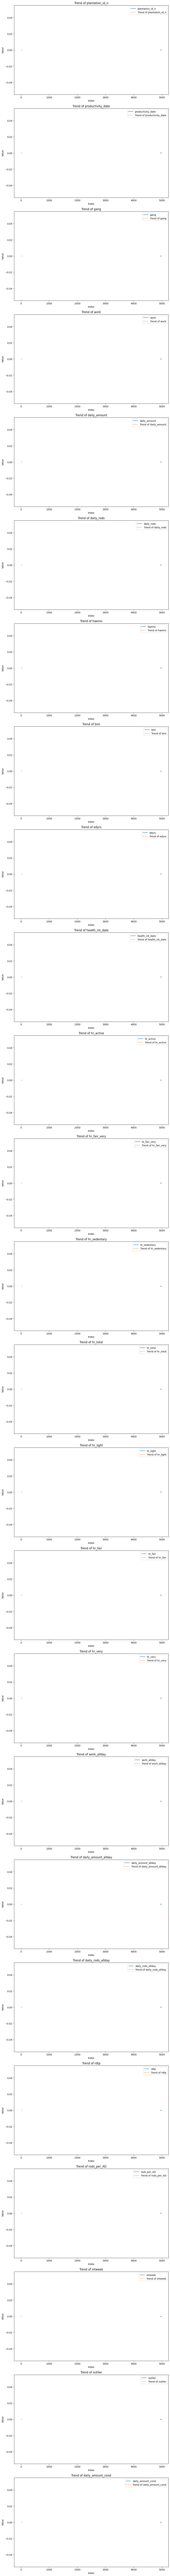

In [ ]:
calculate_trend(df)

#**6. Chuẩn bị dữ liệu thiếu**

In [ ]:
def generate_artifical_missing(data, missing_rate):
    X_intact = data.copy()
    missing_mask = np.random.rand(*data.shape) < missing_rate
    indicating_mask = np.random.rand(*data.shape) < missing_rate
    data[missing_mask] = np.nan
    return X_intact, data, missing_mask, indicating_mask

In [ ]:
def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):

    train_X = train_data.drop(['Date', 'productivity_date', 'health_int_date'], axis=1)
    val_X = val_data.drop(['Date', 'productivity_date', 'health_int_date'], axis=1)
    test_X = test_data.drop(['Date', 'productivity_date', 'health_int_date'], axis=1)

    # Check for NaN values and remove rows with NaNs
    train_X = train_X.dropna()
    val_X = val_X.dropna()
    test_X = test_X.dropna()

    train_X, val_X, test_X = (
        train_X.to_numpy(),
        val_X.to_numpy(),
        test_X.to_numpy(),
    )

    # Normalize the data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    test_X = scaler.transform(test_X)

    # Calculate the number of samples
    num_samples_train = train_X.shape[0] // n_steps
    num_samples_val = val_X.shape[0] // n_steps
    num_samples_test = test_X.shape[0] // n_steps

    # Reshape the arrays
    train_X = train_X[:num_samples_train * n_steps].reshape(num_samples_train, n_steps, -1)
    val_X = val_X[:num_samples_val * n_steps].reshape(num_samples_val, n_steps, -1)
    test_X = test_X[:num_samples_test * n_steps].reshape(num_samples_test, n_steps, -1)

    # Generate artificial missing data
    val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
    test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

    data = {
        "n_steps": n_steps,
        "n_features": train_X.shape[-1],
        "train_X": train_X,
        "val_X": val_X,
        "test_X": test_X,
        "scaler": scaler,
        "val_X_intact": val_X_intact,
        "val_X_indicating_mask": val_X_indicating_mask,
        "test_X_intact": test_X_intact,
        "test_X_indicating_mask": test_X_indicating_mask,
    }

    return data

#**7. Chuẩn bị mô hình huấn luyện**

##**Mô hình huấn luyện các phương pháp truyền thống**

In [ ]:
def split_train_test_fitbit(dataset, train_ratio=0.7, val_ratio=0.2):
    # Chuyển đổi cột 'time' sang định dạng datetime nếu chưa chuyển
    if dataset['Date'].dtype == 'O':  # Kiểm tra nếu cột 'time' là kiểu object (chuỗi)
        dataset['Date'] = pd.to_datetime(dataset['Date'])

    # Xác định thời gian bắt đầu và kết thúc trong dữ liệu
    start_time = dataset['Date'].min()
    end_time = dataset['Date'].max()

    print(f"Dữ liệu bắt đầu từ {start_time} đến {end_time}")

    # Tính tổng khoảng thời gian
    total_duration = end_time - start_time

    # Xác định thời gian kết thúc của tập huấn luyện và tập kiểm định
    train_end = start_time + timedelta(seconds=total_duration.total_seconds() * train_ratio)
    val_end = train_end + timedelta(seconds=total_duration.total_seconds() * val_ratio)

    print(f"Train end time: {train_end}")
    print(f"Validation end time: {val_end}")

    # Chia dữ liệu thành các tập con
    train_data = dataset[dataset['Date'] <= train_end]
    val_data = dataset[(dataset['Date'] > train_end) & (dataset['Date'] <= val_end)]
    test_data = dataset[dataset['Date'] > val_end]

    # Sắp xếp lại các tập con theo thời gian
    train_data = train_data.sort_values('Date')
    val_data = val_data.sort_values('Date')
    test_data = test_data.sort_values('Date')

    return train_data, val_data, test_data

train_data, val_data, test_data = split_train_test_fitbit(df_processed)

print(f"Tập huấn luyện có {len(train_data)} mẫu")
print(f"Tập kiểm định có {len(val_data)} mẫu")
print(f"Tập kiểm tra có {len(test_data)} mẫu")


Dữ liệu bắt đầu từ 2023-02-18 00:00:00 đến 2023-04-14 00:00:00
Train end time: 2023-03-28 12:00:00
Validation end time: 2023-04-08 12:00:00
Tập huấn luyện có 3471 mẫu
Tập kiểm định có 979 mẫu
Tập kiểm tra có 534 mẫu


##**Mô hình huấn luyện cho các phương pháp dựa trên mạng nơ-ron [pypots tutorial](https://colab.research.google.com/drive/1HEFjylEy05-r47jRy0H9jiS_WhD0UWmQ)**

In [ ]:
def get_train_val_test_pypots(data):
  dataset_for_training = {
    "X": data['train_X'],
  }

  dataset_for_validating = {
    "X": data['val_X'],
    "X_ori": data['val_X_intact'],
    "indicating_mask": data['val_X_indicating_mask'],
  }

  dataset_for_testing = {
    "X": data['test_X'],
  }
  return dataset_for_training, dataset_for_validating, dataset_for_testing


# **8. Điền giá trị bị khuyết bằng phương pháp truyền thống**

## **8.1 MEAN(giá trị trung bình)**

In [ ]:
def imputeByMean(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmean(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## **8.2 MEDIAN (trung vị)**

In [ ]:
def imputeByMedian(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmedian(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## **8.3 MICE**

In [ ]:
def imputeByMICE(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  mice_imputer = IterativeImputer(max_iter=5, verbose=1)
  mice_imputer.fit(train_X)
  X_imputed = mice_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

##**8.4 KNN**

In [ ]:
def imputeByKNN(data, k_values):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  best_k = k_values[0]
  best_score = float('inf')
  X_imputed_best = None
  total_time = 0

  for k in k_values:
    start = time.time()*1000 #in milliseconds
    knn_imputer = KNNImputer(n_neighbors=k, weights="uniform")
    knn_imputer.fit(train_X)
    X_imputed = knn_imputer.transform(test_X)
    running_time = (time.time()*1000 - start)
    total_time += running_time

    # Assuming we have the ground truth for test_X to evaluate
    if 'test_X_ground_truth' in data:
      test_X_ground_truth = data['test_X_ground_truth'].reshape(test_X.shape[0], -1)
      score = mean_squared_error(test_X_ground_truth, X_imputed)
      if score < best_score:
        best_score = score
        best_k = k
        X_imputed_best = X_imputed
    else:
      # If no ground truth is available, we use the first imputation
      if X_imputed_best is None:
        X_imputed_best = X_imputed

  X_imputed_best = X_imputed_best.reshape(X_imputed_best.shape[0], data['n_steps'], -1)
  return X_imputed_best, total_time, best_k, best_score


#**9. Điền giá trị bị khuyết bằng phương pháp dựa trên mạng nơ-ron**

##**6.1 BRITS**

In [ ]:
class BritsWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_steps=4, n_features=1, learning_rate=1e-3, batch_size=32, patience=3, epochs=10):
        self.n_steps = n_steps
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.patience = patience
        self.epochs = epochs
        self.model = None

    def fit(self, X, y=None):
        self.model = BRITS(
            n_steps=self.n_steps,
            n_features=self.n_features,
            rnn_hidden_size=128,
            batch_size=self.batch_size,
            epochs=self.epochs,
            patience=self.patience,
            optimizer=Adam(lr=self.learning_rate),
            num_workers=0,
            device=None,
            saving_path="path_to_save_results",
            model_saving_strategy="best",
        )
        dataset_for_training, dataset_for_validating, _ = get_train_val_test_pypots(X)
        self.model.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        dataset_for_testing, _, _ = get_train_val_test_pypots(X)
        return self.model.predict(dataset_for_testing)['imputation']


In [ ]:
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters(train_sequences, n_features, param_grid):
    """
    Tìm bộ hyperparameters tốt nhất cho mô hình BRITS.

    Parameters:
    train_sequences (numpy array): Dữ liệu train để tìm hyperparameters.
    n_features (int): Số lượng đặc trưng.
    param_grid (dict): Grid các hyperparameters cần thử nghiệm.

    Returns:
    dict: Bộ hyperparameters tốt nhất.
    """
    # Tạo wrapper cho mô hình BRITS
    brits_wrapper = BritsWrapper(n_steps=4, n_features=n_features)

    # Sử dụng GridSearchCV để tìm bộ hyperparameters tốt nhất
    grid_search = GridSearchCV(estimator=brits_wrapper, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
    grid_search.fit(train_sequences)

    # Trả về bộ hyperparameters tốt nhất
    return grid_search.best_params_

In [ ]:
def apply_BRITS(data): #data: dict generated from prepare_train_val_test
  brits = BRITS(n_steps=data['n_steps'], n_features=data['n_features'],  rnn_hidden_size=128,batch_size=32, patience=3, epochs=10,num_workers=0,
                device='cpu', saving_path="Fitbit/BRITS", model_saving_strategy="best")

  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  brits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = brits.impute(dataset_for_testing)
  running_time = (time.time()*1000 - start)
  return imputation, running_time

##**6.2 Transformer**

In [ ]:
def apply_Transformer(data): #data: dict generated from prepare_train_val_test
  trans = Transformer(n_steps=data['n_steps'], n_features=data['n_features'],n_layers=6,
    d_model=512,
    d_ffn=256,
    n_heads=4,
    d_k=128,
    d_v=128,
    dropout=0.1,
    attn_dropout=0,
    ORT_weight=1,
    MIT_weight=1,
    batch_size=32,
    epochs=10,
    patience=3,
    optimizer=Adam(lr=1e-3),
    num_workers=0,
    device='cpu', saving_path="Fitbit/TRANSFORMER", model_saving_strategy="best")

  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  trans.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = trans.impute(dataset_for_testing)
  running_time = (time.time()*1000 - start)
  return imputation, running_time

#**10. Đánh giá chất lượng điền khuyết**

In [ ]:
def export_metrics(imputation, X_intact, indicating_mask):
  mae = calc_mae(imputation, X_intact, indicating_mask)
  mse = calc_mse(imputation, X_intact, indicating_mask)
  rmse = calc_rmse(imputation, X_intact, indicating_mask)
  return mae, mse, rmse

In [ ]:
def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
    data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
    if method == 'mean':
        imputation, running_time = imputeByMean(data)
    elif method == 'median':
        imputation, running_time = imputeByMedian(data)
    elif method == 'knn':
        k_values = [3, 5, 7]
        imputation, running_time, best_k, best_score = imputeByKNN(data, k_values)
    elif method == 'mice':
        imputation, running_time = imputeByMICE(data)
    elif method == 'transformer':
        imputation, running_time = apply_Transformer(data)
    elif method == 'brits':
       imputation, running_time = apply_BRITS(data)
    else:
        raise Exception("Sorry, method is unsupported!")
    result = {
        "imputation": imputation,
        "running_time": running_time,
        "scaler": data['scaler'],
    }
    if compute_metrics:
        mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
        result["mae"] = mae
        result["mse"] = mse
        result["rmse"] = rmse
    return result

In [ ]:
def run_experiment(df_processed, missing_rates, methods, n_steps=30, N=10):
    # Generate dataframe columns
    COLUMN_NAMES = ["Artificial missing rate"]
    for method in methods:
        COLUMN_NAMES.extend([method, method+'_STD'])

    df_mae = pd.DataFrame(columns=COLUMN_NAMES)
    df_mse = pd.DataFrame(columns=COLUMN_NAMES)
    df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
    df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

    train_data, val_data, test_data = split_train_test_fitbit(df_processed)

    for rate in missing_rates:
        list_rate_mae = [rate]
        list_rate_mse = [rate]
        list_rate_rmse = [rate]
        list_rate_running_time = [rate]

        for method in methods:
            running_time_avg = []
            mae_avg = []
            mse_avg = []
            rmse_avg = []

            for i in range(N):
                print('Rate:', rate, 'Method:', method, 'N:', i)
                result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
                mae_avg.append(result['mae'])
                mse_avg.append(result['mse'])
                rmse_avg.append(result['rmse'])
                running_time_avg.append(result['running_time'])

            list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
            list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
            list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
            list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

        df_mae.loc[len(df_mae.index)] = list_rate_mae
        df_mse.loc[len(df_mse.index)] = list_rate_mse
        df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
        df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

    os.makedirs('result', exist_ok=True)

    df_mae.to_excel('result/MAE'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_mse.to_excel('result/MSE'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_rmse.to_excel('result/RMSE'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_running_time.to_excel('result/RunningTime'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')

    return df_mae, df_mse, df_rmse, df_running_time

In [ ]:
n_steps = 30
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
#missing_rates = [0.1, 0.2]
methods = ['median','mean','knn', 'mice','transformer','brits' ]

In [ ]:
df_mae, df_mse, df_rmse, df_running_time = run_experiment(df_processed, missing_rates, methods)

Dữ liệu bắt đầu từ 2023-02-18 00:00:00 đến 2023-04-14 00:00:00
Train end time: 2023-03-28 12:00:00
Validation end time: 2023-04-08 12:00:00
Rate: 0.1 Method: median N: 0
Rate: 0.1 Method: median N: 1
Rate: 0.1 Method: median N: 2
Rate: 0.1 Method: median N: 3
Rate: 0.1 Method: median N: 4
Rate: 0.1 Method: median N: 5
Rate: 0.1 Method: median N: 6
Rate: 0.1 Method: median N: 7
Rate: 0.1 Method: median N: 8
Rate: 0.1 Method: median N: 9
Rate: 0.1 Method: mean N: 0
Rate: 0.1 Method: mean N: 1
Rate: 0.1 Method: mean N: 2
Rate: 0.1 Method: mean N: 3
Rate: 0.1 Method: mean N: 4
Rate: 0.1 Method: mean N: 5
Rate: 0.1 Method: mean N: 6
Rate: 0.1 Method: mean N: 7
Rate: 0.1 Method: mean N: 8
Rate: 0.1 Method: mean N: 9
Rate: 0.1 Method: knn N: 0
Rate: 0.1 Method: knn N: 1
Rate: 0.1 Method: knn N: 2
Rate: 0.1 Method: knn N: 3
Rate: 0.1 Method: knn N: 4
Rate: 0.1 Method: knn N: 5
Rate: 0.1 Method: knn N: 6
Rate: 0.1 Method: knn N: 7
Rate: 0.1 Method: knn N: 8
Rate: 0.1 Method: knn N: 9
Rate: 0.1 

2024-06-27 13:32:40 [INFO]: Using the given device: cpu


[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556603983 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (4, 690)
Rate: 0.1 Method: transformer N: 0


2024-06-27 13:32:40 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133240
2024-06-27 13:32:40 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133240/tensorboard
2024-06-27 13:32:40 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 13:32:44 [INFO]: Epoch 001 - training loss: 2.7146, validation loss: 1.8148
2024-06-27 13:32:45 [INFO]: Epoch 002 - training loss: 2.0252, validation loss: 1.3647
2024-06-27 13:32:46 [INFO]: Epoch 003 - training loss: 1.4742, validation loss: 1.2935
2024-06-27 13:32:48 [INFO]: Epoch 004 - training loss: 1.3874, validation loss: 1.3451
2024-06-27 13:32:49 [INFO]: Epoch 005 - training loss: 1.3136, validation loss: 1.3343
2024-06-27 13:32:50 [INFO]: Epoch 006 - training loss: 1.3318, validation loss: 1.3796
2024-06-27 13:32:50 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:32:50 [INFO]: Finished training. 

Rate: 0.1 Method: transformer N: 1


2024-06-27 13:32:52 [INFO]: Epoch 001 - training loss: 2.6482, validation loss: 3.1705
2024-06-27 13:32:54 [INFO]: Epoch 002 - training loss: 2.0652, validation loss: 1.3963
2024-06-27 13:32:56 [INFO]: Epoch 003 - training loss: 1.5662, validation loss: 1.4743
2024-06-27 13:32:57 [INFO]: Epoch 004 - training loss: 1.3132, validation loss: 1.5186
2024-06-27 13:32:58 [INFO]: Epoch 005 - training loss: 1.3283, validation loss: 1.5560
2024-06-27 13:32:58 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:32:58 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:32:59 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133250/Transformer.pypots
2024-06-27 13:32:59 [INFO]: Using the given device: cpu
2024-06-27 13:32:59 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133259
2024-06-27 13:32:59 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133259/tensorboard
2024-06-27 13:32:59 [INFO]:

Rate: 0.1 Method: transformer N: 2


2024-06-27 13:33:00 [INFO]: Epoch 001 - training loss: 2.6606, validation loss: 2.9232
2024-06-27 13:33:01 [INFO]: Epoch 002 - training loss: 2.1407, validation loss: 2.1425
2024-06-27 13:33:03 [INFO]: Epoch 003 - training loss: 1.5331, validation loss: 1.9183
2024-06-27 13:33:04 [INFO]: Epoch 004 - training loss: 1.3719, validation loss: 1.6303
2024-06-27 13:33:06 [INFO]: Epoch 005 - training loss: 1.3325, validation loss: 1.4664
2024-06-27 13:33:07 [INFO]: Epoch 006 - training loss: 1.2983, validation loss: 1.6153
2024-06-27 13:33:09 [INFO]: Epoch 007 - training loss: 1.2747, validation loss: 1.6683
2024-06-27 13:33:11 [INFO]: Epoch 008 - training loss: 1.2548, validation loss: 1.7423
2024-06-27 13:33:11 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:33:11 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:33:11 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133259/Transformer.pypots
2024-06-27 13:33:11 [INFO

Rate: 0.1 Method: transformer N: 3


2024-06-27 13:33:13 [INFO]: Epoch 001 - training loss: 2.6571, validation loss: 3.3492
2024-06-27 13:33:14 [INFO]: Epoch 002 - training loss: 2.2415, validation loss: 1.1289
2024-06-27 13:33:15 [INFO]: Epoch 003 - training loss: 1.5753, validation loss: 1.3105
2024-06-27 13:33:17 [INFO]: Epoch 004 - training loss: 1.3500, validation loss: 1.4152
2024-06-27 13:33:18 [INFO]: Epoch 005 - training loss: 1.3598, validation loss: 1.2642
2024-06-27 13:33:18 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:33:18 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:33:18 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133311/Transformer.pypots
2024-06-27 13:33:18 [INFO]: Using the given device: cpu
2024-06-27 13:33:18 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133318
2024-06-27 13:33:18 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133318/tensorboard
2024-06-27 13:33:18 [INFO]:

Rate: 0.1 Method: transformer N: 4


2024-06-27 13:33:20 [INFO]: Epoch 001 - training loss: 2.6584, validation loss: 2.2187
2024-06-27 13:33:22 [INFO]: Epoch 002 - training loss: 2.0017, validation loss: 1.6736
2024-06-27 13:33:23 [INFO]: Epoch 003 - training loss: 1.5111, validation loss: 1.3316
2024-06-27 13:33:25 [INFO]: Epoch 004 - training loss: 1.3253, validation loss: 1.3066
2024-06-27 13:33:26 [INFO]: Epoch 005 - training loss: 1.3095, validation loss: 1.2791
2024-06-27 13:33:28 [INFO]: Epoch 006 - training loss: 1.2989, validation loss: 1.2915
2024-06-27 13:33:29 [INFO]: Epoch 007 - training loss: 1.2491, validation loss: 1.3542
2024-06-27 13:33:30 [INFO]: Epoch 008 - training loss: 1.2572, validation loss: 1.4054
2024-06-27 13:33:30 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:33:30 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:33:31 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133318/Transformer.pypots
2024-06-27 13:33:31 [INFO

Rate: 0.1 Method: transformer N: 5


2024-06-27 13:33:32 [INFO]: Epoch 001 - training loss: 2.5977, validation loss: 2.9057
2024-06-27 13:33:33 [INFO]: Epoch 002 - training loss: 2.2729, validation loss: 1.7644
2024-06-27 13:33:35 [INFO]: Epoch 003 - training loss: 1.6226, validation loss: 1.4215
2024-06-27 13:33:37 [INFO]: Epoch 004 - training loss: 1.3359, validation loss: 1.3811
2024-06-27 13:33:40 [INFO]: Epoch 005 - training loss: 1.2961, validation loss: 1.4655
2024-06-27 13:33:42 [INFO]: Epoch 006 - training loss: 1.2660, validation loss: 1.4479
2024-06-27 13:33:43 [INFO]: Epoch 007 - training loss: 1.2710, validation loss: 1.3934
2024-06-27 13:33:43 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:33:43 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:33:43 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133331/Transformer.pypots
2024-06-27 13:33:43 [INFO]: Using the given device: cpu
2024-06-27 13:33:43 [INFO]: Model files will be saved to

Rate: 0.1 Method: transformer N: 6


2024-06-27 13:33:44 [INFO]: Epoch 001 - training loss: 2.6495, validation loss: 1.9587
2024-06-27 13:33:46 [INFO]: Epoch 002 - training loss: 2.0509, validation loss: 1.9340
2024-06-27 13:33:47 [INFO]: Epoch 003 - training loss: 1.5626, validation loss: 1.8081
2024-06-27 13:33:48 [INFO]: Epoch 004 - training loss: 1.3543, validation loss: 1.9184
2024-06-27 13:33:49 [INFO]: Epoch 005 - training loss: 1.3204, validation loss: 1.6071
2024-06-27 13:33:51 [INFO]: Epoch 006 - training loss: 1.2786, validation loss: 1.4933
2024-06-27 13:33:52 [INFO]: Epoch 007 - training loss: 1.3026, validation loss: 1.5964
2024-06-27 13:33:54 [INFO]: Epoch 008 - training loss: 1.2708, validation loss: 1.7589
2024-06-27 13:33:56 [INFO]: Epoch 009 - training loss: 1.2397, validation loss: 1.9304
2024-06-27 13:33:56 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:33:56 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:33:56 [INFO]: Saved the mo

Rate: 0.1 Method: transformer N: 7


2024-06-27 13:33:58 [INFO]: Epoch 001 - training loss: 2.7596, validation loss: 2.2425
2024-06-27 13:33:59 [INFO]: Epoch 002 - training loss: 2.1101, validation loss: 2.1516
2024-06-27 13:34:01 [INFO]: Epoch 003 - training loss: 1.4410, validation loss: 1.8258
2024-06-27 13:34:02 [INFO]: Epoch 004 - training loss: 1.3621, validation loss: 1.8719
2024-06-27 13:34:03 [INFO]: Epoch 005 - training loss: 1.3307, validation loss: 2.1312
2024-06-27 13:34:05 [INFO]: Epoch 006 - training loss: 1.3260, validation loss: 2.2222
2024-06-27 13:34:05 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:34:05 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:34:05 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133357/Transformer.pypots
2024-06-27 13:34:05 [INFO]: Using the given device: cpu
2024-06-27 13:34:05 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133405
2024-06-27 13:34:05 [INFO]: Tensorboard file will 

Rate: 0.1 Method: transformer N: 8


2024-06-27 13:34:06 [INFO]: Epoch 001 - training loss: 2.5732, validation loss: 3.2131
2024-06-27 13:34:08 [INFO]: Epoch 002 - training loss: 2.0553, validation loss: 1.4063
2024-06-27 13:34:10 [INFO]: Epoch 003 - training loss: 1.4956, validation loss: 1.5595
2024-06-27 13:34:12 [INFO]: Epoch 004 - training loss: 1.3341, validation loss: 1.6964
2024-06-27 13:34:13 [INFO]: Epoch 005 - training loss: 1.2748, validation loss: 1.6601
2024-06-27 13:34:13 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:34:13 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:34:13 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133405/Transformer.pypots
2024-06-27 13:34:13 [INFO]: Using the given device: cpu
2024-06-27 13:34:13 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133413
2024-06-27 13:34:13 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133413/tensorboard
2024-06-27 13:34:14 [INFO]:

Rate: 0.1 Method: transformer N: 9


2024-06-27 13:34:15 [INFO]: Epoch 001 - training loss: 2.6386, validation loss: 4.0796
2024-06-27 13:34:16 [INFO]: Epoch 002 - training loss: 2.1619, validation loss: 1.6481
2024-06-27 13:34:17 [INFO]: Epoch 003 - training loss: 1.7036, validation loss: 1.9173
2024-06-27 13:34:19 [INFO]: Epoch 004 - training loss: 1.4145, validation loss: 1.9344
2024-06-27 13:34:20 [INFO]: Epoch 005 - training loss: 1.3969, validation loss: 1.5086
2024-06-27 13:34:21 [INFO]: Epoch 006 - training loss: 1.3203, validation loss: 1.5081
2024-06-27 13:34:23 [INFO]: Epoch 007 - training loss: 1.3223, validation loss: 1.6223
2024-06-27 13:34:25 [INFO]: Epoch 008 - training loss: 1.2629, validation loss: 1.7662
2024-06-27 13:34:27 [INFO]: Epoch 009 - training loss: 1.2954, validation loss: 1.8494
2024-06-27 13:34:27 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:34:27 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:34:27 [INFO]: Saved the mo

Rate: 0.1 Method: brits N: 0


2024-06-27 13:34:28 [INFO]: Epoch 001 - training loss: 1.3873, validation loss: 1.7410
2024-06-27 13:34:28 [INFO]: Epoch 002 - training loss: 1.3483, validation loss: 1.7264
2024-06-27 13:34:28 [INFO]: Epoch 003 - training loss: 1.3103, validation loss: 1.7083
2024-06-27 13:34:29 [INFO]: Epoch 004 - training loss: 1.3130, validation loss: 1.6891
2024-06-27 13:34:29 [INFO]: Epoch 005 - training loss: 1.2845, validation loss: 1.6672
2024-06-27 13:34:30 [INFO]: Epoch 006 - training loss: 1.2738, validation loss: 1.6443
2024-06-27 13:34:30 [INFO]: Epoch 007 - training loss: 1.2523, validation loss: 1.6172
2024-06-27 13:34:31 [INFO]: Epoch 008 - training loss: 1.2400, validation loss: 1.5823
2024-06-27 13:34:31 [INFO]: Epoch 009 - training loss: 1.2301, validation loss: 1.5405
2024-06-27 13:34:31 [INFO]: Epoch 010 - training loss: 1.2333, validation loss: 1.4923
2024-06-27 13:34:31 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:34:31 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 1


2024-06-27 13:34:32 [INFO]: Epoch 001 - training loss: 1.4019, validation loss: 1.2330
2024-06-27 13:34:32 [INFO]: Epoch 002 - training loss: 1.3371, validation loss: 1.2091
2024-06-27 13:34:33 [INFO]: Epoch 003 - training loss: 1.3192, validation loss: 1.1835
2024-06-27 13:34:33 [INFO]: Epoch 004 - training loss: 1.2993, validation loss: 1.1540
2024-06-27 13:34:34 [INFO]: Epoch 005 - training loss: 1.3009, validation loss: 1.1220
2024-06-27 13:34:34 [INFO]: Epoch 006 - training loss: 1.2626, validation loss: 1.0903
2024-06-27 13:34:34 [INFO]: Epoch 007 - training loss: 1.2570, validation loss: 1.0581
2024-06-27 13:34:35 [INFO]: Epoch 008 - training loss: 1.2444, validation loss: 1.0201
2024-06-27 13:34:35 [INFO]: Epoch 009 - training loss: 1.2318, validation loss: 0.9794
2024-06-27 13:34:35 [INFO]: Epoch 010 - training loss: 1.2371, validation loss: 0.9376
2024-06-27 13:34:35 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:34:35 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 2


2024-06-27 13:34:36 [INFO]: Epoch 001 - training loss: 1.3786, validation loss: 1.1356
2024-06-27 13:34:36 [INFO]: Epoch 002 - training loss: 1.3462, validation loss: 1.1168
2024-06-27 13:34:37 [INFO]: Epoch 003 - training loss: 1.3247, validation loss: 1.1048
2024-06-27 13:34:37 [INFO]: Epoch 004 - training loss: 1.3540, validation loss: 1.0927
2024-06-27 13:34:38 [INFO]: Epoch 005 - training loss: 1.2881, validation loss: 1.0774
2024-06-27 13:34:38 [INFO]: Epoch 006 - training loss: 1.2873, validation loss: 1.0631
2024-06-27 13:34:39 [INFO]: Epoch 007 - training loss: 1.3064, validation loss: 1.0453
2024-06-27 13:34:39 [INFO]: Epoch 008 - training loss: 1.2864, validation loss: 1.0161
2024-06-27 13:34:40 [INFO]: Epoch 009 - training loss: 1.2727, validation loss: 0.9771
2024-06-27 13:34:40 [INFO]: Epoch 010 - training loss: 1.2443, validation loss: 0.9333
2024-06-27 13:34:40 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:34:40 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 3


2024-06-27 13:34:41 [INFO]: Epoch 001 - training loss: 1.3571, validation loss: 1.2139
2024-06-27 13:34:41 [INFO]: Epoch 002 - training loss: 1.3323, validation loss: 1.2053
2024-06-27 13:34:42 [INFO]: Epoch 003 - training loss: 1.3206, validation loss: 1.1918
2024-06-27 13:34:42 [INFO]: Epoch 004 - training loss: 1.3060, validation loss: 1.1780
2024-06-27 13:34:42 [INFO]: Epoch 005 - training loss: 1.2772, validation loss: 1.1666
2024-06-27 13:34:43 [INFO]: Epoch 006 - training loss: 1.2900, validation loss: 1.1539
2024-06-27 13:34:43 [INFO]: Epoch 007 - training loss: 1.2577, validation loss: 1.1306
2024-06-27 13:34:43 [INFO]: Epoch 008 - training loss: 1.2529, validation loss: 1.0962
2024-06-27 13:34:44 [INFO]: Epoch 009 - training loss: 1.2264, validation loss: 1.0560
2024-06-27 13:34:44 [INFO]: Epoch 010 - training loss: 1.2282, validation loss: 1.0144
2024-06-27 13:34:44 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:34:44 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 4


2024-06-27 13:34:45 [INFO]: Epoch 001 - training loss: 1.3850, validation loss: 1.4897
2024-06-27 13:34:45 [INFO]: Epoch 002 - training loss: 1.3774, validation loss: 1.4666
2024-06-27 13:34:46 [INFO]: Epoch 003 - training loss: 1.3385, validation loss: 1.4434
2024-06-27 13:34:46 [INFO]: Epoch 004 - training loss: 1.3340, validation loss: 1.4197
2024-06-27 13:34:46 [INFO]: Epoch 005 - training loss: 1.3054, validation loss: 1.3966
2024-06-27 13:34:47 [INFO]: Epoch 006 - training loss: 1.2941, validation loss: 1.3749
2024-06-27 13:34:47 [INFO]: Epoch 007 - training loss: 1.2763, validation loss: 1.3516
2024-06-27 13:34:48 [INFO]: Epoch 008 - training loss: 1.2701, validation loss: 1.3246
2024-06-27 13:34:48 [INFO]: Epoch 009 - training loss: 1.2663, validation loss: 1.2904
2024-06-27 13:34:48 [INFO]: Epoch 010 - training loss: 1.2264, validation loss: 1.2500
2024-06-27 13:34:48 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:34:48 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 5


2024-06-27 13:34:49 [INFO]: Epoch 001 - training loss: 1.3705, validation loss: 1.2838
2024-06-27 13:34:49 [INFO]: Epoch 002 - training loss: 1.3624, validation loss: 1.2695
2024-06-27 13:34:50 [INFO]: Epoch 003 - training loss: 1.3311, validation loss: 1.2516
2024-06-27 13:34:50 [INFO]: Epoch 004 - training loss: 1.3065, validation loss: 1.2311
2024-06-27 13:34:51 [INFO]: Epoch 005 - training loss: 1.3335, validation loss: 1.2090
2024-06-27 13:34:52 [INFO]: Epoch 006 - training loss: 1.2924, validation loss: 1.1845
2024-06-27 13:34:52 [INFO]: Epoch 007 - training loss: 1.2693, validation loss: 1.1613
2024-06-27 13:34:53 [INFO]: Epoch 008 - training loss: 1.2526, validation loss: 1.1367
2024-06-27 13:34:53 [INFO]: Epoch 009 - training loss: 1.2362, validation loss: 1.1008
2024-06-27 13:34:54 [INFO]: Epoch 010 - training loss: 1.2141, validation loss: 1.0524
2024-06-27 13:34:54 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:34:54 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 6


2024-06-27 13:34:55 [INFO]: Epoch 001 - training loss: 1.3560, validation loss: 1.4137
2024-06-27 13:34:55 [INFO]: Epoch 002 - training loss: 1.3616, validation loss: 1.4033
2024-06-27 13:34:56 [INFO]: Epoch 003 - training loss: 1.3315, validation loss: 1.3951
2024-06-27 13:34:56 [INFO]: Epoch 004 - training loss: 1.3419, validation loss: 1.3836
2024-06-27 13:34:57 [INFO]: Epoch 005 - training loss: 1.3270, validation loss: 1.3669
2024-06-27 13:34:57 [INFO]: Epoch 006 - training loss: 1.2977, validation loss: 1.3435
2024-06-27 13:34:57 [INFO]: Epoch 007 - training loss: 1.2532, validation loss: 1.3165
2024-06-27 13:34:58 [INFO]: Epoch 008 - training loss: 1.2551, validation loss: 1.2865
2024-06-27 13:34:58 [INFO]: Epoch 009 - training loss: 1.2434, validation loss: 1.2517
2024-06-27 13:34:59 [INFO]: Epoch 010 - training loss: 1.2415, validation loss: 1.2127
2024-06-27 13:34:59 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:34:59 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 7


2024-06-27 13:34:59 [INFO]: Epoch 001 - training loss: 1.3610, validation loss: 1.4763
2024-06-27 13:34:59 [INFO]: Epoch 002 - training loss: 1.3716, validation loss: 1.4571
2024-06-27 13:35:00 [INFO]: Epoch 003 - training loss: 1.3082, validation loss: 1.4382
2024-06-27 13:35:00 [INFO]: Epoch 004 - training loss: 1.3193, validation loss: 1.4193
2024-06-27 13:35:00 [INFO]: Epoch 005 - training loss: 1.3072, validation loss: 1.3936
2024-06-27 13:35:01 [INFO]: Epoch 006 - training loss: 1.2695, validation loss: 1.3643
2024-06-27 13:35:01 [INFO]: Epoch 007 - training loss: 1.2724, validation loss: 1.3284
2024-06-27 13:35:02 [INFO]: Epoch 008 - training loss: 1.2635, validation loss: 1.2781
2024-06-27 13:35:02 [INFO]: Epoch 009 - training loss: 1.2401, validation loss: 1.2131
2024-06-27 13:35:02 [INFO]: Epoch 010 - training loss: 1.2368, validation loss: 1.1449
2024-06-27 13:35:02 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:35:02 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 8


2024-06-27 13:35:03 [INFO]: Epoch 001 - training loss: 1.3513, validation loss: 1.2753
2024-06-27 13:35:03 [INFO]: Epoch 002 - training loss: 1.3332, validation loss: 1.2493
2024-06-27 13:35:04 [INFO]: Epoch 003 - training loss: 1.3138, validation loss: 1.2279
2024-06-27 13:35:04 [INFO]: Epoch 004 - training loss: 1.2998, validation loss: 1.2091
2024-06-27 13:35:04 [INFO]: Epoch 005 - training loss: 1.2731, validation loss: 1.1890
2024-06-27 13:35:05 [INFO]: Epoch 006 - training loss: 1.2918, validation loss: 1.1639
2024-06-27 13:35:05 [INFO]: Epoch 007 - training loss: 1.2638, validation loss: 1.1300
2024-06-27 13:35:05 [INFO]: Epoch 008 - training loss: 1.2608, validation loss: 1.0857
2024-06-27 13:35:06 [INFO]: Epoch 009 - training loss: 1.2338, validation loss: 1.0322
2024-06-27 13:35:06 [INFO]: Epoch 010 - training loss: 1.2376, validation loss: 0.9780
2024-06-27 13:35:06 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:35:06 [INFO]: Saved the model to Fit

Rate: 0.1 Method: brits N: 9


2024-06-27 13:35:07 [INFO]: Epoch 001 - training loss: 1.3441, validation loss: 1.6097
2024-06-27 13:35:08 [INFO]: Epoch 002 - training loss: 1.3235, validation loss: 1.5964
2024-06-27 13:35:08 [INFO]: Epoch 003 - training loss: 1.3135, validation loss: 1.5822
2024-06-27 13:35:09 [INFO]: Epoch 004 - training loss: 1.3297, validation loss: 1.5638
2024-06-27 13:35:10 [INFO]: Epoch 005 - training loss: 1.2922, validation loss: 1.5430
2024-06-27 13:35:10 [INFO]: Epoch 006 - training loss: 1.2825, validation loss: 1.5206
2024-06-27 13:35:10 [INFO]: Epoch 007 - training loss: 1.2726, validation loss: 1.4919
2024-06-27 13:35:11 [INFO]: Epoch 008 - training loss: 1.2449, validation loss: 1.4527
2024-06-27 13:35:11 [INFO]: Epoch 009 - training loss: 1.2366, validation loss: 1.4069
2024-06-27 13:35:11 [INFO]: Epoch 010 - training loss: 1.2293, validation loss: 1.3576
2024-06-27 13:35:11 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:35:11 [INFO]: Saved the model to Fit

Rate: 0.2 Method: median N: 0
Rate: 0.2 Method: median N: 1
Rate: 0.2 Method: median N: 2
Rate: 0.2 Method: median N: 3
Rate: 0.2 Method: median N: 4
Rate: 0.2 Method: median N: 5
Rate: 0.2 Method: median N: 6
Rate: 0.2 Method: median N: 7
Rate: 0.2 Method: median N: 8
Rate: 0.2 Method: median N: 9
Rate: 0.2 Method: mean N: 0
Rate: 0.2 Method: mean N: 1
Rate: 0.2 Method: mean N: 2
Rate: 0.2 Method: mean N: 3
Rate: 0.2 Method: mean N: 4
Rate: 0.2 Method: mean N: 5
Rate: 0.2 Method: mean N: 6
Rate: 0.2 Method: mean N: 7
Rate: 0.2 Method: mean N: 8
Rate: 0.2 Method: mean N: 9
Rate: 0.2 Method: knn N: 0
Rate: 0.2 Method: knn N: 1
Rate: 0.2 Method: knn N: 2
Rate: 0.2 Method: knn N: 3
Rate: 0.2 Method: knn N: 4
Rate: 0.2 Method: knn N: 5
Rate: 0.2 Method: knn N: 6
Rate: 0.2 Method: knn N: 7
Rate: 0.2 Method: knn N: 8
Rate: 0.2 Method: knn N: 9
Rate: 0.2 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (41, 690)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556

2024-06-27 13:37:23 [INFO]: Using the given device: cpu
2024-06-27 13:37:23 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133723
2024-06-27 13:37:23 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133723/tensorboard


[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556603983 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (4, 690)
Rate: 0.2 Method: transformer N: 0


2024-06-27 13:37:23 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 13:37:24 [INFO]: Epoch 001 - training loss: 2.5558, validation loss: 3.8883
2024-06-27 13:37:26 [INFO]: Epoch 002 - training loss: 2.3346, validation loss: 2.7562
2024-06-27 13:37:28 [INFO]: Epoch 003 - training loss: 1.5515, validation loss: 2.3208
2024-06-27 13:37:30 [INFO]: Epoch 004 - training loss: 1.4333, validation loss: 1.9900
2024-06-27 13:37:31 [INFO]: Epoch 005 - training loss: 1.3796, validation loss: 2.1983
2024-06-27 13:37:32 [INFO]: Epoch 006 - training loss: 1.3207, validation loss: 2.3380
2024-06-27 13:37:34 [INFO]: Epoch 007 - training loss: 1.2807, validation loss: 2.4877
2024-06-27 13:37:34 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:37:34 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:37:34 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133723/T

Rate: 0.2 Method: transformer N: 1


2024-06-27 13:37:35 [INFO]: Epoch 001 - training loss: 2.7179, validation loss: 2.6685
2024-06-27 13:37:37 [INFO]: Epoch 002 - training loss: 2.0767, validation loss: 1.3727
2024-06-27 13:37:38 [INFO]: Epoch 003 - training loss: 1.5761, validation loss: 1.3263
2024-06-27 13:37:39 [INFO]: Epoch 004 - training loss: 1.3700, validation loss: 1.3243
2024-06-27 13:37:41 [INFO]: Epoch 005 - training loss: 1.3092, validation loss: 1.3142
2024-06-27 13:37:43 [INFO]: Epoch 006 - training loss: 1.2789, validation loss: 1.2586
2024-06-27 13:37:45 [INFO]: Epoch 007 - training loss: 1.2829, validation loss: 1.2491
2024-06-27 13:37:46 [INFO]: Epoch 008 - training loss: 1.3217, validation loss: 1.2747
2024-06-27 13:37:47 [INFO]: Epoch 009 - training loss: 1.2610, validation loss: 1.2557
2024-06-27 13:37:49 [INFO]: Epoch 010 - training loss: 1.2583, validation loss: 1.2203
2024-06-27 13:37:49 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:37:49 [INFO]: Saved the model to Fit

Rate: 0.2 Method: transformer N: 2


2024-06-27 13:37:50 [INFO]: Epoch 001 - training loss: 2.5978, validation loss: 3.5701
2024-06-27 13:37:52 [INFO]: Epoch 002 - training loss: 2.1057, validation loss: 1.1747
2024-06-27 13:37:53 [INFO]: Epoch 003 - training loss: 1.6423, validation loss: 1.6282
2024-06-27 13:37:54 [INFO]: Epoch 004 - training loss: 1.4130, validation loss: 1.5107
2024-06-27 13:37:56 [INFO]: Epoch 005 - training loss: 1.3052, validation loss: 1.4022
2024-06-27 13:37:56 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:37:56 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:37:56 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133749/Transformer.pypots
2024-06-27 13:37:56 [INFO]: Using the given device: cpu
2024-06-27 13:37:56 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133756
2024-06-27 13:37:56 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133756/tensorboard
2024-06-27 13:37:57 [INFO]:

Rate: 0.2 Method: transformer N: 3


2024-06-27 13:37:59 [INFO]: Epoch 001 - training loss: 2.7855, validation loss: 2.5605
2024-06-27 13:38:00 [INFO]: Epoch 002 - training loss: 2.1973, validation loss: 1.8713
2024-06-27 13:38:02 [INFO]: Epoch 003 - training loss: 1.4439, validation loss: 1.8076
2024-06-27 13:38:04 [INFO]: Epoch 004 - training loss: 1.3710, validation loss: 1.9402
2024-06-27 13:38:06 [INFO]: Epoch 005 - training loss: 1.2967, validation loss: 1.8761
2024-06-27 13:38:07 [INFO]: Epoch 006 - training loss: 1.2923, validation loss: 1.7767
2024-06-27 13:38:08 [INFO]: Epoch 007 - training loss: 1.2689, validation loss: 1.7066
2024-06-27 13:38:10 [INFO]: Epoch 008 - training loss: 1.2546, validation loss: 1.6631
2024-06-27 13:38:12 [INFO]: Epoch 009 - training loss: 1.2436, validation loss: 1.7038
2024-06-27 13:38:14 [INFO]: Epoch 010 - training loss: 1.2814, validation loss: 1.8035
2024-06-27 13:38:14 [INFO]: Finished training. The best model is from epoch#8.
2024-06-27 13:38:14 [INFO]: Saved the model to Fitb

Rate: 0.2 Method: transformer N: 4


2024-06-27 13:38:16 [INFO]: Epoch 001 - training loss: 2.6315, validation loss: 2.7816
2024-06-27 13:38:17 [INFO]: Epoch 002 - training loss: 2.1042, validation loss: 1.2134
2024-06-27 13:38:18 [INFO]: Epoch 003 - training loss: 1.5582, validation loss: 1.6363
2024-06-27 13:38:19 [INFO]: Epoch 004 - training loss: 1.3465, validation loss: 1.7328
2024-06-27 13:38:20 [INFO]: Epoch 005 - training loss: 1.3261, validation loss: 1.7062
2024-06-27 13:38:20 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:38:21 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:38:21 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133814/Transformer.pypots
2024-06-27 13:38:21 [INFO]: Using the given device: cpu
2024-06-27 13:38:21 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133821
2024-06-27 13:38:21 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133821/tensorboard
2024-06-27 13:38:21 [INFO]:

Rate: 0.2 Method: transformer N: 5


2024-06-27 13:38:22 [INFO]: Epoch 001 - training loss: 2.6311, validation loss: 2.9604
2024-06-27 13:38:24 [INFO]: Epoch 002 - training loss: 2.1250, validation loss: 1.9405
2024-06-27 13:38:25 [INFO]: Epoch 003 - training loss: 1.5466, validation loss: 1.6734
2024-06-27 13:38:27 [INFO]: Epoch 004 - training loss: 1.3848, validation loss: 1.7649
2024-06-27 13:38:29 [INFO]: Epoch 005 - training loss: 1.3481, validation loss: 1.7502
2024-06-27 13:38:31 [INFO]: Epoch 006 - training loss: 1.3304, validation loss: 1.6950
2024-06-27 13:38:31 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:38:31 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:38:31 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133821/Transformer.pypots
2024-06-27 13:38:31 [INFO]: Using the given device: cpu
2024-06-27 13:38:31 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133831
2024-06-27 13:38:31 [INFO]: Tensorboard file will 

Rate: 0.2 Method: transformer N: 6


2024-06-27 13:38:32 [INFO]: Epoch 001 - training loss: 2.6099, validation loss: 3.4304
2024-06-27 13:38:34 [INFO]: Epoch 002 - training loss: 2.1691, validation loss: 1.2384
2024-06-27 13:38:35 [INFO]: Epoch 003 - training loss: 1.5850, validation loss: 1.5985
2024-06-27 13:38:36 [INFO]: Epoch 004 - training loss: 1.3746, validation loss: 1.8690
2024-06-27 13:38:38 [INFO]: Epoch 005 - training loss: 1.3539, validation loss: 1.6451
2024-06-27 13:38:38 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:38:38 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:38:38 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133831/Transformer.pypots
2024-06-27 13:38:38 [INFO]: Using the given device: cpu
2024-06-27 13:38:38 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T133838
2024-06-27 13:38:38 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T133838/tensorboard
2024-06-27 13:38:38 [INFO]:

Rate: 0.2 Method: transformer N: 7


2024-06-27 13:38:39 [INFO]: Epoch 001 - training loss: 2.5622, validation loss: 2.9768
2024-06-27 13:38:41 [INFO]: Epoch 002 - training loss: 2.3051, validation loss: 1.4790
2024-06-27 13:38:43 [INFO]: Epoch 003 - training loss: 1.6876, validation loss: 1.4986
2024-06-27 13:38:45 [INFO]: Epoch 004 - training loss: 1.3845, validation loss: 1.4535
2024-06-27 13:38:46 [INFO]: Epoch 005 - training loss: 1.4105, validation loss: 1.2640
2024-06-27 13:38:47 [INFO]: Epoch 006 - training loss: 1.2782, validation loss: 1.3089
2024-06-27 13:38:48 [INFO]: Epoch 007 - training loss: 1.3153, validation loss: 1.3733
2024-06-27 13:38:50 [INFO]: Epoch 008 - training loss: 1.2858, validation loss: 1.4872
2024-06-27 13:38:50 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:38:50 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:38:50 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133838/Transformer.pypots
2024-06-27 13:38:50 [INFO

Rate: 0.2 Method: transformer N: 8


2024-06-27 13:38:52 [INFO]: Epoch 001 - training loss: 2.6696, validation loss: 2.7681
2024-06-27 13:38:53 [INFO]: Epoch 002 - training loss: 2.0780, validation loss: 2.1402
2024-06-27 13:38:54 [INFO]: Epoch 003 - training loss: 1.6644, validation loss: 1.7326
2024-06-27 13:38:56 [INFO]: Epoch 004 - training loss: 1.3969, validation loss: 1.6324
2024-06-27 13:38:58 [INFO]: Epoch 005 - training loss: 1.3055, validation loss: 1.6941
2024-06-27 13:39:00 [INFO]: Epoch 006 - training loss: 1.3072, validation loss: 1.7852
2024-06-27 13:39:01 [INFO]: Epoch 007 - training loss: 1.2852, validation loss: 1.6320
2024-06-27 13:39:02 [INFO]: Epoch 008 - training loss: 1.2513, validation loss: 1.5861
2024-06-27 13:39:04 [INFO]: Epoch 009 - training loss: 1.2626, validation loss: 1.6143
2024-06-27 13:39:05 [INFO]: Epoch 010 - training loss: 1.2462, validation loss: 1.6266
2024-06-27 13:39:05 [INFO]: Finished training. The best model is from epoch#8.
2024-06-27 13:39:05 [INFO]: Saved the model to Fitb

Rate: 0.2 Method: transformer N: 9


2024-06-27 13:39:07 [INFO]: Epoch 001 - training loss: 2.5752, validation loss: 2.6721
2024-06-27 13:39:08 [INFO]: Epoch 002 - training loss: 2.0570, validation loss: 2.5273
2024-06-27 13:39:10 [INFO]: Epoch 003 - training loss: 1.6321, validation loss: 1.6236
2024-06-27 13:39:12 [INFO]: Epoch 004 - training loss: 1.3707, validation loss: 1.5201
2024-06-27 13:39:14 [INFO]: Epoch 005 - training loss: 1.3133, validation loss: 1.8140
2024-06-27 13:39:15 [INFO]: Epoch 006 - training loss: 1.2795, validation loss: 1.9271
2024-06-27 13:39:17 [INFO]: Epoch 007 - training loss: 1.3154, validation loss: 1.9123
2024-06-27 13:39:17 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:39:17 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:39:17 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T133905/Transformer.pypots
2024-06-27 13:39:17 [INFO]: Using the given device: cpu
2024-06-27 13:39:17 [INFO]: Model files will be saved to

Rate: 0.2 Method: brits N: 0


2024-06-27 13:39:18 [INFO]: Epoch 001 - training loss: 1.4239, validation loss: 1.9270
2024-06-27 13:39:18 [INFO]: Epoch 002 - training loss: 1.3792, validation loss: 1.9101
2024-06-27 13:39:18 [INFO]: Epoch 003 - training loss: 1.3986, validation loss: 1.8906
2024-06-27 13:39:19 [INFO]: Epoch 004 - training loss: 1.3884, validation loss: 1.8661
2024-06-27 13:39:19 [INFO]: Epoch 005 - training loss: 1.3629, validation loss: 1.8414
2024-06-27 13:39:19 [INFO]: Epoch 006 - training loss: 1.3049, validation loss: 1.8177
2024-06-27 13:39:20 [INFO]: Epoch 007 - training loss: 1.2922, validation loss: 1.7939
2024-06-27 13:39:20 [INFO]: Epoch 008 - training loss: 1.3012, validation loss: 1.7688
2024-06-27 13:39:21 [INFO]: Epoch 009 - training loss: 1.2825, validation loss: 1.7329
2024-06-27 13:39:21 [INFO]: Epoch 010 - training loss: 1.2499, validation loss: 1.6859
2024-06-27 13:39:21 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:21 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 1


2024-06-27 13:39:22 [INFO]: Epoch 001 - training loss: 1.3629, validation loss: 1.6064
2024-06-27 13:39:22 [INFO]: Epoch 002 - training loss: 1.3612, validation loss: 1.5839
2024-06-27 13:39:22 [INFO]: Epoch 003 - training loss: 1.3399, validation loss: 1.5604
2024-06-27 13:39:23 [INFO]: Epoch 004 - training loss: 1.3284, validation loss: 1.5339
2024-06-27 13:39:23 [INFO]: Epoch 005 - training loss: 1.3162, validation loss: 1.5042
2024-06-27 13:39:24 [INFO]: Epoch 006 - training loss: 1.2972, validation loss: 1.4737
2024-06-27 13:39:24 [INFO]: Epoch 007 - training loss: 1.2839, validation loss: 1.4432
2024-06-27 13:39:24 [INFO]: Epoch 008 - training loss: 1.2701, validation loss: 1.4116
2024-06-27 13:39:25 [INFO]: Epoch 009 - training loss: 1.2407, validation loss: 1.3762
2024-06-27 13:39:26 [INFO]: Epoch 010 - training loss: 1.2171, validation loss: 1.3358
2024-06-27 13:39:26 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:26 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 2


2024-06-27 13:39:26 [INFO]: Epoch 001 - training loss: 1.3919, validation loss: 1.6063
2024-06-27 13:39:27 [INFO]: Epoch 002 - training loss: 1.3330, validation loss: 1.5862
2024-06-27 13:39:27 [INFO]: Epoch 003 - training loss: 1.3196, validation loss: 1.5673
2024-06-27 13:39:28 [INFO]: Epoch 004 - training loss: 1.3014, validation loss: 1.5479
2024-06-27 13:39:28 [INFO]: Epoch 005 - training loss: 1.2935, validation loss: 1.5271
2024-06-27 13:39:29 [INFO]: Epoch 006 - training loss: 1.2755, validation loss: 1.5092
2024-06-27 13:39:29 [INFO]: Epoch 007 - training loss: 1.2589, validation loss: 1.4899
2024-06-27 13:39:30 [INFO]: Epoch 008 - training loss: 1.2593, validation loss: 1.4625
2024-06-27 13:39:30 [INFO]: Epoch 009 - training loss: 1.2579, validation loss: 1.4288
2024-06-27 13:39:30 [INFO]: Epoch 010 - training loss: 1.2238, validation loss: 1.3893
2024-06-27 13:39:30 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:30 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 3


2024-06-27 13:39:31 [INFO]: Epoch 001 - training loss: 1.3515, validation loss: 1.6419
2024-06-27 13:39:31 [INFO]: Epoch 002 - training loss: 1.3277, validation loss: 1.6238
2024-06-27 13:39:32 [INFO]: Epoch 003 - training loss: 1.3078, validation loss: 1.6040
2024-06-27 13:39:32 [INFO]: Epoch 004 - training loss: 1.3181, validation loss: 1.5848
2024-06-27 13:39:33 [INFO]: Epoch 005 - training loss: 1.2733, validation loss: 1.5668
2024-06-27 13:39:33 [INFO]: Epoch 006 - training loss: 1.2479, validation loss: 1.5506
2024-06-27 13:39:33 [INFO]: Epoch 007 - training loss: 1.2423, validation loss: 1.5292
2024-06-27 13:39:34 [INFO]: Epoch 008 - training loss: 1.2309, validation loss: 1.4968
2024-06-27 13:39:34 [INFO]: Epoch 009 - training loss: 1.2335, validation loss: 1.4552
2024-06-27 13:39:35 [INFO]: Epoch 010 - training loss: 1.2025, validation loss: 1.4067
2024-06-27 13:39:35 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:35 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 4


2024-06-27 13:39:35 [INFO]: Epoch 001 - training loss: 1.3926, validation loss: 1.3817
2024-06-27 13:39:36 [INFO]: Epoch 002 - training loss: 1.3445, validation loss: 1.3650
2024-06-27 13:39:36 [INFO]: Epoch 003 - training loss: 1.3433, validation loss: 1.3459
2024-06-27 13:39:37 [INFO]: Epoch 004 - training loss: 1.3274, validation loss: 1.3225
2024-06-27 13:39:37 [INFO]: Epoch 005 - training loss: 1.2956, validation loss: 1.2941
2024-06-27 13:39:37 [INFO]: Epoch 006 - training loss: 1.3163, validation loss: 1.2608
2024-06-27 13:39:38 [INFO]: Epoch 007 - training loss: 1.2673, validation loss: 1.2256
2024-06-27 13:39:38 [INFO]: Epoch 008 - training loss: 1.2423, validation loss: 1.1846
2024-06-27 13:39:39 [INFO]: Epoch 009 - training loss: 1.2326, validation loss: 1.1330
2024-06-27 13:39:39 [INFO]: Epoch 010 - training loss: 1.2301, validation loss: 1.0765
2024-06-27 13:39:39 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:39 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 5


2024-06-27 13:39:40 [INFO]: Epoch 001 - training loss: 1.4007, validation loss: 1.8549
2024-06-27 13:39:41 [INFO]: Epoch 002 - training loss: 1.3528, validation loss: 1.8391
2024-06-27 13:39:41 [INFO]: Epoch 003 - training loss: 1.3551, validation loss: 1.8218
2024-06-27 13:39:42 [INFO]: Epoch 004 - training loss: 1.3392, validation loss: 1.7985
2024-06-27 13:39:43 [INFO]: Epoch 005 - training loss: 1.3016, validation loss: 1.7729
2024-06-27 13:39:43 [INFO]: Epoch 006 - training loss: 1.2971, validation loss: 1.7489
2024-06-27 13:39:43 [INFO]: Epoch 007 - training loss: 1.2721, validation loss: 1.7233
2024-06-27 13:39:44 [INFO]: Epoch 008 - training loss: 1.2820, validation loss: 1.6909
2024-06-27 13:39:44 [INFO]: Epoch 009 - training loss: 1.2565, validation loss: 1.6479
2024-06-27 13:39:45 [INFO]: Epoch 010 - training loss: 1.2285, validation loss: 1.5952
2024-06-27 13:39:45 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:45 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 6


2024-06-27 13:39:46 [INFO]: Epoch 001 - training loss: 1.4403, validation loss: 1.1281
2024-06-27 13:39:46 [INFO]: Epoch 002 - training loss: 1.3630, validation loss: 1.1047
2024-06-27 13:39:46 [INFO]: Epoch 003 - training loss: 1.3668, validation loss: 1.0816
2024-06-27 13:39:47 [INFO]: Epoch 004 - training loss: 1.3530, validation loss: 1.0595
2024-06-27 13:39:47 [INFO]: Epoch 005 - training loss: 1.3162, validation loss: 1.0391
2024-06-27 13:39:48 [INFO]: Epoch 006 - training loss: 1.3022, validation loss: 1.0190
2024-06-27 13:39:48 [INFO]: Epoch 007 - training loss: 1.2930, validation loss: 0.9956
2024-06-27 13:39:49 [INFO]: Epoch 008 - training loss: 1.2708, validation loss: 0.9664
2024-06-27 13:39:49 [INFO]: Epoch 009 - training loss: 1.2774, validation loss: 0.9294
2024-06-27 13:39:50 [INFO]: Epoch 010 - training loss: 1.2587, validation loss: 0.8860
2024-06-27 13:39:50 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:50 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 7


2024-06-27 13:39:50 [INFO]: Epoch 001 - training loss: 1.3656, validation loss: 1.4656
2024-06-27 13:39:51 [INFO]: Epoch 002 - training loss: 1.3514, validation loss: 1.4507
2024-06-27 13:39:51 [INFO]: Epoch 003 - training loss: 1.3080, validation loss: 1.4308
2024-06-27 13:39:51 [INFO]: Epoch 004 - training loss: 1.3207, validation loss: 1.4100
2024-06-27 13:39:52 [INFO]: Epoch 005 - training loss: 1.3087, validation loss: 1.3871
2024-06-27 13:39:52 [INFO]: Epoch 006 - training loss: 1.2897, validation loss: 1.3613
2024-06-27 13:39:52 [INFO]: Epoch 007 - training loss: 1.2351, validation loss: 1.3301
2024-06-27 13:39:53 [INFO]: Epoch 008 - training loss: 1.2594, validation loss: 1.2950
2024-06-27 13:39:54 [INFO]: Epoch 009 - training loss: 1.2343, validation loss: 1.2508
2024-06-27 13:39:54 [INFO]: Epoch 010 - training loss: 1.2222, validation loss: 1.1983
2024-06-27 13:39:54 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:39:54 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 8


2024-06-27 13:39:55 [INFO]: Epoch 001 - training loss: 1.3832, validation loss: 1.7075
2024-06-27 13:39:56 [INFO]: Epoch 002 - training loss: 1.3377, validation loss: 1.6920
2024-06-27 13:39:56 [INFO]: Epoch 003 - training loss: 1.3619, validation loss: 1.6729
2024-06-27 13:39:57 [INFO]: Epoch 004 - training loss: 1.3256, validation loss: 1.6522
2024-06-27 13:39:57 [INFO]: Epoch 005 - training loss: 1.2832, validation loss: 1.6306
2024-06-27 13:39:58 [INFO]: Epoch 006 - training loss: 1.3022, validation loss: 1.6091
2024-06-27 13:39:58 [INFO]: Epoch 007 - training loss: 1.2852, validation loss: 1.5812
2024-06-27 13:39:59 [INFO]: Epoch 008 - training loss: 1.2657, validation loss: 1.5434
2024-06-27 13:39:59 [INFO]: Epoch 009 - training loss: 1.2786, validation loss: 1.4992
2024-06-27 13:40:00 [INFO]: Epoch 010 - training loss: 1.2359, validation loss: 1.4530
2024-06-27 13:40:00 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:40:00 [INFO]: Saved the model to Fit

Rate: 0.2 Method: brits N: 9


2024-06-27 13:40:00 [INFO]: Epoch 001 - training loss: 1.3819, validation loss: 1.3066
2024-06-27 13:40:01 [INFO]: Epoch 002 - training loss: 1.3998, validation loss: 1.2867
2024-06-27 13:40:01 [INFO]: Epoch 003 - training loss: 1.3423, validation loss: 1.2649
2024-06-27 13:40:01 [INFO]: Epoch 004 - training loss: 1.3463, validation loss: 1.2422
2024-06-27 13:40:02 [INFO]: Epoch 005 - training loss: 1.3020, validation loss: 1.2168
2024-06-27 13:40:02 [INFO]: Epoch 006 - training loss: 1.3050, validation loss: 1.1871
2024-06-27 13:40:03 [INFO]: Epoch 007 - training loss: 1.2871, validation loss: 1.1474
2024-06-27 13:40:03 [INFO]: Epoch 008 - training loss: 1.2762, validation loss: 1.0999
2024-06-27 13:40:04 [INFO]: Epoch 009 - training loss: 1.2565, validation loss: 1.0481
2024-06-27 13:40:04 [INFO]: Epoch 010 - training loss: 1.2520, validation loss: 0.9963
2024-06-27 13:40:04 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:40:04 [INFO]: Saved the model to Fit

Rate: 0.3 Method: median N: 0
Rate: 0.3 Method: median N: 1
Rate: 0.3 Method: median N: 2
Rate: 0.3 Method: median N: 3
Rate: 0.3 Method: median N: 4
Rate: 0.3 Method: median N: 5
Rate: 0.3 Method: median N: 6
Rate: 0.3 Method: median N: 7
Rate: 0.3 Method: median N: 8
Rate: 0.3 Method: median N: 9
Rate: 0.3 Method: mean N: 0
Rate: 0.3 Method: mean N: 1
Rate: 0.3 Method: mean N: 2
Rate: 0.3 Method: mean N: 3
Rate: 0.3 Method: mean N: 4
Rate: 0.3 Method: mean N: 5
Rate: 0.3 Method: mean N: 6
Rate: 0.3 Method: mean N: 7
Rate: 0.3 Method: mean N: 8
Rate: 0.3 Method: mean N: 9
Rate: 0.3 Method: knn N: 0
Rate: 0.3 Method: knn N: 1
Rate: 0.3 Method: knn N: 2
Rate: 0.3 Method: knn N: 3
Rate: 0.3 Method: knn N: 4
Rate: 0.3 Method: knn N: 5
Rate: 0.3 Method: knn N: 6
Rate: 0.3 Method: knn N: 7
Rate: 0.3 Method: knn N: 8
Rate: 0.3 Method: knn N: 9
Rate: 0.3 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (41, 690)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556

2024-06-27 13:42:24 [INFO]: Using the given device: cpu


[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556603983 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (4, 690)
Rate: 0.3 Method: transformer N: 0


2024-06-27 13:42:24 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134224
2024-06-27 13:42:24 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T134224/tensorboard
2024-06-27 13:42:24 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 13:42:25 [INFO]: Epoch 001 - training loss: 2.5537, validation loss: 4.2907
2024-06-27 13:42:26 [INFO]: Epoch 002 - training loss: 2.1550, validation loss: 1.4669
2024-06-27 13:42:28 [INFO]: Epoch 003 - training loss: 1.4609, validation loss: 2.0261
2024-06-27 13:42:29 [INFO]: Epoch 004 - training loss: 1.4564, validation loss: 2.0164
2024-06-27 13:42:31 [INFO]: Epoch 005 - training loss: 1.3189, validation loss: 1.7819
2024-06-27 13:42:31 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:42:31 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:42:31 [INFO]: Saved the model to Fitbit/T

Rate: 0.3 Method: transformer N: 1


2024-06-27 13:42:33 [INFO]: Epoch 001 - training loss: 2.5338, validation loss: 3.5463
2024-06-27 13:42:35 [INFO]: Epoch 002 - training loss: 2.2131, validation loss: 1.8786
2024-06-27 13:42:36 [INFO]: Epoch 003 - training loss: 1.5238, validation loss: 1.9253
2024-06-27 13:42:37 [INFO]: Epoch 004 - training loss: 1.3622, validation loss: 1.6623
2024-06-27 13:42:39 [INFO]: Epoch 005 - training loss: 1.3388, validation loss: 1.6093
2024-06-27 13:42:40 [INFO]: Epoch 006 - training loss: 1.3377, validation loss: 1.6738
2024-06-27 13:42:41 [INFO]: Epoch 007 - training loss: 1.3120, validation loss: 1.7073
2024-06-27 13:42:43 [INFO]: Epoch 008 - training loss: 1.2511, validation loss: 1.7837
2024-06-27 13:42:43 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:42:43 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:42:43 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134231/Transformer.pypots
2024-06-27 13:42:43 [INFO

Rate: 0.3 Method: transformer N: 2


2024-06-27 13:42:45 [INFO]: Epoch 001 - training loss: 2.5112, validation loss: 3.4598
2024-06-27 13:42:47 [INFO]: Epoch 002 - training loss: 2.3159, validation loss: 2.1267
2024-06-27 13:42:48 [INFO]: Epoch 003 - training loss: 1.5838, validation loss: 2.1069
2024-06-27 13:42:50 [INFO]: Epoch 004 - training loss: 1.4323, validation loss: 1.7578
2024-06-27 13:42:51 [INFO]: Epoch 005 - training loss: 1.3009, validation loss: 1.7821
2024-06-27 13:42:52 [INFO]: Epoch 006 - training loss: 1.3419, validation loss: 1.8538
2024-06-27 13:42:54 [INFO]: Epoch 007 - training loss: 1.2758, validation loss: 1.9056
2024-06-27 13:42:54 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:42:54 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:42:54 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134243/Transformer.pypots
2024-06-27 13:42:54 [INFO]: Using the given device: cpu
2024-06-27 13:42:54 [INFO]: Model files will be saved to

Rate: 0.3 Method: transformer N: 3


2024-06-27 13:42:55 [INFO]: Epoch 001 - training loss: 2.5879, validation loss: 3.2729
2024-06-27 13:42:56 [INFO]: Epoch 002 - training loss: 1.9876, validation loss: 1.8805
2024-06-27 13:42:58 [INFO]: Epoch 003 - training loss: 1.5399, validation loss: 1.6028
2024-06-27 13:43:00 [INFO]: Epoch 004 - training loss: 1.3510, validation loss: 1.5470
2024-06-27 13:43:02 [INFO]: Epoch 005 - training loss: 1.3099, validation loss: 1.6492
2024-06-27 13:43:03 [INFO]: Epoch 006 - training loss: 1.2943, validation loss: 1.6640
2024-06-27 13:43:05 [INFO]: Epoch 007 - training loss: 1.2908, validation loss: 1.5771
2024-06-27 13:43:05 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:43:05 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:43:05 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134254/Transformer.pypots
2024-06-27 13:43:05 [INFO]: Using the given device: cpu
2024-06-27 13:43:05 [INFO]: Model files will be saved to

Rate: 0.3 Method: transformer N: 4


2024-06-27 13:43:06 [INFO]: Epoch 001 - training loss: 2.5399, validation loss: 2.6670
2024-06-27 13:43:07 [INFO]: Epoch 002 - training loss: 2.0569, validation loss: 2.0575
2024-06-27 13:43:09 [INFO]: Epoch 003 - training loss: 1.4773, validation loss: 1.7310
2024-06-27 13:43:10 [INFO]: Epoch 004 - training loss: 1.3387, validation loss: 1.6622
2024-06-27 13:43:11 [INFO]: Epoch 005 - training loss: 1.3605, validation loss: 1.6353
2024-06-27 13:43:12 [INFO]: Epoch 006 - training loss: 1.3079, validation loss: 1.7069
2024-06-27 13:43:14 [INFO]: Epoch 007 - training loss: 1.3007, validation loss: 1.6759
2024-06-27 13:43:16 [INFO]: Epoch 008 - training loss: 1.3095, validation loss: 1.6169
2024-06-27 13:43:18 [INFO]: Epoch 009 - training loss: 1.2197, validation loss: 1.6782
2024-06-27 13:43:19 [INFO]: Epoch 010 - training loss: 1.3052, validation loss: 1.6839
2024-06-27 13:43:19 [INFO]: Finished training. The best model is from epoch#8.
2024-06-27 13:43:19 [INFO]: Saved the model to Fitb

Rate: 0.3 Method: transformer N: 5


2024-06-27 13:43:21 [INFO]: Epoch 001 - training loss: 2.6111, validation loss: 2.5048
2024-06-27 13:43:22 [INFO]: Epoch 002 - training loss: 2.0695, validation loss: 1.5504
2024-06-27 13:43:23 [INFO]: Epoch 003 - training loss: 1.5808, validation loss: 1.6013
2024-06-27 13:43:24 [INFO]: Epoch 004 - training loss: 1.2869, validation loss: 1.5242
2024-06-27 13:43:26 [INFO]: Epoch 005 - training loss: 1.3282, validation loss: 1.4614
2024-06-27 13:43:27 [INFO]: Epoch 006 - training loss: 1.2963, validation loss: 1.5973
2024-06-27 13:43:29 [INFO]: Epoch 007 - training loss: 1.2492, validation loss: 1.6296
2024-06-27 13:43:31 [INFO]: Epoch 008 - training loss: 1.2590, validation loss: 1.5594
2024-06-27 13:43:31 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:43:31 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:43:31 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134319/Transformer.pypots
2024-06-27 13:43:31 [INFO

Rate: 0.3 Method: transformer N: 6


2024-06-27 13:43:33 [INFO]: Epoch 001 - training loss: 2.5375, validation loss: 3.4421
2024-06-27 13:43:34 [INFO]: Epoch 002 - training loss: 2.3197, validation loss: 2.4546
2024-06-27 13:43:36 [INFO]: Epoch 003 - training loss: 1.4538, validation loss: 1.8419
2024-06-27 13:43:37 [INFO]: Epoch 004 - training loss: 1.3620, validation loss: 1.8241
2024-06-27 13:43:38 [INFO]: Epoch 005 - training loss: 1.3019, validation loss: 1.9380
2024-06-27 13:43:40 [INFO]: Epoch 006 - training loss: 1.3091, validation loss: 1.9706
2024-06-27 13:43:41 [INFO]: Epoch 007 - training loss: 1.3132, validation loss: 1.8151
2024-06-27 13:43:42 [INFO]: Epoch 008 - training loss: 1.2812, validation loss: 1.8031
2024-06-27 13:43:44 [INFO]: Epoch 009 - training loss: 1.2654, validation loss: 1.8445
2024-06-27 13:43:46 [INFO]: Epoch 010 - training loss: 1.2341, validation loss: 1.8841
2024-06-27 13:43:46 [INFO]: Finished training. The best model is from epoch#8.
2024-06-27 13:43:46 [INFO]: Saved the model to Fitb

Rate: 0.3 Method: transformer N: 7


2024-06-27 13:43:48 [INFO]: Epoch 001 - training loss: 2.7018, validation loss: 2.7065
2024-06-27 13:43:49 [INFO]: Epoch 002 - training loss: 2.1982, validation loss: 1.9238
2024-06-27 13:43:51 [INFO]: Epoch 003 - training loss: 1.6100, validation loss: 1.4025
2024-06-27 13:43:52 [INFO]: Epoch 004 - training loss: 1.3426, validation loss: 1.5580
2024-06-27 13:43:53 [INFO]: Epoch 005 - training loss: 1.3392, validation loss: 1.6759
2024-06-27 13:43:55 [INFO]: Epoch 006 - training loss: 1.2637, validation loss: 1.5573
2024-06-27 13:43:55 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:43:55 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:43:55 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134346/Transformer.pypots
2024-06-27 13:43:55 [INFO]: Using the given device: cpu
2024-06-27 13:43:55 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134355
2024-06-27 13:43:55 [INFO]: Tensorboard file will 

Rate: 0.3 Method: transformer N: 8


2024-06-27 13:43:56 [INFO]: Epoch 001 - training loss: 2.5969, validation loss: 3.7300
2024-06-27 13:43:58 [INFO]: Epoch 002 - training loss: 2.3420, validation loss: 2.1234
2024-06-27 13:44:00 [INFO]: Epoch 003 - training loss: 1.5462, validation loss: 2.1170
2024-06-27 13:44:02 [INFO]: Epoch 004 - training loss: 1.5023, validation loss: 2.0771
2024-06-27 13:44:03 [INFO]: Epoch 005 - training loss: 1.3830, validation loss: 1.9571
2024-06-27 13:44:05 [INFO]: Epoch 006 - training loss: 1.3344, validation loss: 1.8133
2024-06-27 13:44:06 [INFO]: Epoch 007 - training loss: 1.3328, validation loss: 1.8313
2024-06-27 13:44:07 [INFO]: Epoch 008 - training loss: 1.2692, validation loss: 2.0015
2024-06-27 13:44:09 [INFO]: Epoch 009 - training loss: 1.3104, validation loss: 2.0166
2024-06-27 13:44:09 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:44:09 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:44:09 [INFO]: Saved the mo

Rate: 0.3 Method: transformer N: 9


2024-06-27 13:44:11 [INFO]: Epoch 001 - training loss: 2.7051, validation loss: 2.7817
2024-06-27 13:44:12 [INFO]: Epoch 002 - training loss: 2.1948, validation loss: 1.6753
2024-06-27 13:44:13 [INFO]: Epoch 003 - training loss: 1.4773, validation loss: 1.5983
2024-06-27 13:44:15 [INFO]: Epoch 004 - training loss: 1.3923, validation loss: 1.7091
2024-06-27 13:44:17 [INFO]: Epoch 005 - training loss: 1.3413, validation loss: 1.5576
2024-06-27 13:44:19 [INFO]: Epoch 006 - training loss: 1.2922, validation loss: 1.4425
2024-06-27 13:44:20 [INFO]: Epoch 007 - training loss: 1.3159, validation loss: 1.5017
2024-06-27 13:44:22 [INFO]: Epoch 008 - training loss: 1.2740, validation loss: 1.6112
2024-06-27 13:44:23 [INFO]: Epoch 009 - training loss: 1.2884, validation loss: 1.6050
2024-06-27 13:44:23 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:44:23 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:44:23 [INFO]: Saved the mo

Rate: 0.3 Method: brits N: 0


2024-06-27 13:44:24 [INFO]: Epoch 001 - training loss: 1.4151, validation loss: 1.5736
2024-06-27 13:44:24 [INFO]: Epoch 002 - training loss: 1.3541, validation loss: 1.5620
2024-06-27 13:44:24 [INFO]: Epoch 003 - training loss: 1.3462, validation loss: 1.5511
2024-06-27 13:44:25 [INFO]: Epoch 004 - training loss: 1.3443, validation loss: 1.5416
2024-06-27 13:44:25 [INFO]: Epoch 005 - training loss: 1.3295, validation loss: 1.5309
2024-06-27 13:44:26 [INFO]: Epoch 006 - training loss: 1.2843, validation loss: 1.5188
2024-06-27 13:44:26 [INFO]: Epoch 007 - training loss: 1.2834, validation loss: 1.5023
2024-06-27 13:44:26 [INFO]: Epoch 008 - training loss: 1.2625, validation loss: 1.4790
2024-06-27 13:44:27 [INFO]: Epoch 009 - training loss: 1.2991, validation loss: 1.4472
2024-06-27 13:44:27 [INFO]: Epoch 010 - training loss: 1.2366, validation loss: 1.4079
2024-06-27 13:44:27 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:44:27 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 1


2024-06-27 13:44:28 [INFO]: Epoch 001 - training loss: 1.3802, validation loss: 1.2737
2024-06-27 13:44:29 [INFO]: Epoch 002 - training loss: 1.3529, validation loss: 1.2554
2024-06-27 13:44:30 [INFO]: Epoch 003 - training loss: 1.3343, validation loss: 1.2395
2024-06-27 13:44:30 [INFO]: Epoch 004 - training loss: 1.3164, validation loss: 1.2262
2024-06-27 13:44:31 [INFO]: Epoch 005 - training loss: 1.2806, validation loss: 1.2126
2024-06-27 13:44:32 [INFO]: Epoch 006 - training loss: 1.2622, validation loss: 1.1972
2024-06-27 13:44:32 [INFO]: Epoch 007 - training loss: 1.2612, validation loss: 1.1801
2024-06-27 13:44:32 [INFO]: Epoch 008 - training loss: 1.2473, validation loss: 1.1591
2024-06-27 13:44:33 [INFO]: Epoch 009 - training loss: 1.2404, validation loss: 1.1319
2024-06-27 13:44:33 [INFO]: Epoch 010 - training loss: 1.2224, validation loss: 1.1014
2024-06-27 13:44:33 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:44:33 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 2


2024-06-27 13:44:34 [INFO]: Epoch 001 - training loss: 1.3866, validation loss: 1.4344
2024-06-27 13:44:34 [INFO]: Epoch 002 - training loss: 1.3265, validation loss: 1.4192
2024-06-27 13:44:35 [INFO]: Epoch 003 - training loss: 1.2973, validation loss: 1.4035
2024-06-27 13:44:35 [INFO]: Epoch 004 - training loss: 1.3376, validation loss: 1.3860
2024-06-27 13:44:35 [INFO]: Epoch 005 - training loss: 1.2970, validation loss: 1.3665
2024-06-27 13:44:36 [INFO]: Epoch 006 - training loss: 1.2992, validation loss: 1.3466
2024-06-27 13:44:36 [INFO]: Epoch 007 - training loss: 1.3045, validation loss: 1.3217
2024-06-27 13:44:36 [INFO]: Epoch 008 - training loss: 1.2727, validation loss: 1.2867
2024-06-27 13:44:37 [INFO]: Epoch 009 - training loss: 1.2334, validation loss: 1.2415
2024-06-27 13:44:37 [INFO]: Epoch 010 - training loss: 1.2667, validation loss: 1.1863
2024-06-27 13:44:37 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:44:37 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 3


2024-06-27 13:44:38 [INFO]: Epoch 001 - training loss: 1.3897, validation loss: 1.5329
2024-06-27 13:44:38 [INFO]: Epoch 002 - training loss: 1.3509, validation loss: 1.5151
2024-06-27 13:44:39 [INFO]: Epoch 003 - training loss: 1.3162, validation loss: 1.4970
2024-06-27 13:44:39 [INFO]: Epoch 004 - training loss: 1.3229, validation loss: 1.4804
2024-06-27 13:44:40 [INFO]: Epoch 005 - training loss: 1.3152, validation loss: 1.4630
2024-06-27 13:44:40 [INFO]: Epoch 006 - training loss: 1.2524, validation loss: 1.4455
2024-06-27 13:44:41 [INFO]: Epoch 007 - training loss: 1.2656, validation loss: 1.4268
2024-06-27 13:44:41 [INFO]: Epoch 008 - training loss: 1.2465, validation loss: 1.4031
2024-06-27 13:44:41 [INFO]: Epoch 009 - training loss: 1.2415, validation loss: 1.3753
2024-06-27 13:44:42 [INFO]: Epoch 010 - training loss: 1.2288, validation loss: 1.3411
2024-06-27 13:44:42 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:44:42 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 4


2024-06-27 13:44:43 [INFO]: Epoch 001 - training loss: 1.3690, validation loss: 1.7559
2024-06-27 13:44:43 [INFO]: Epoch 002 - training loss: 1.3495, validation loss: 1.7415
2024-06-27 13:44:44 [INFO]: Epoch 003 - training loss: 1.3415, validation loss: 1.7272
2024-06-27 13:44:44 [INFO]: Epoch 004 - training loss: 1.3300, validation loss: 1.7087
2024-06-27 13:44:45 [INFO]: Epoch 005 - training loss: 1.3024, validation loss: 1.6875
2024-06-27 13:44:46 [INFO]: Epoch 006 - training loss: 1.2877, validation loss: 1.6630
2024-06-27 13:44:46 [INFO]: Epoch 007 - training loss: 1.2644, validation loss: 1.6318
2024-06-27 13:44:46 [INFO]: Epoch 008 - training loss: 1.2506, validation loss: 1.5969
2024-06-27 13:44:47 [INFO]: Epoch 009 - training loss: 1.2206, validation loss: 1.5609
2024-06-27 13:44:47 [INFO]: Epoch 010 - training loss: 1.2235, validation loss: 1.5193
2024-06-27 13:44:47 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:44:47 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 5


2024-06-27 13:44:48 [INFO]: Epoch 001 - training loss: 1.3905, validation loss: 1.7064
2024-06-27 13:44:48 [INFO]: Epoch 002 - training loss: 1.3219, validation loss: 1.6907
2024-06-27 13:44:49 [INFO]: Epoch 003 - training loss: 1.3396, validation loss: 1.6747
2024-06-27 13:44:49 [INFO]: Epoch 004 - training loss: 1.3104, validation loss: 1.6555
2024-06-27 13:44:49 [INFO]: Epoch 005 - training loss: 1.2847, validation loss: 1.6349
2024-06-27 13:44:50 [INFO]: Epoch 006 - training loss: 1.2726, validation loss: 1.6147
2024-06-27 13:44:50 [INFO]: Epoch 007 - training loss: 1.2664, validation loss: 1.5911
2024-06-27 13:44:50 [INFO]: Epoch 008 - training loss: 1.2333, validation loss: 1.5615
2024-06-27 13:44:51 [INFO]: Epoch 009 - training loss: 1.2668, validation loss: 1.5270
2024-06-27 13:44:51 [INFO]: Epoch 010 - training loss: 1.2300, validation loss: 1.4868
2024-06-27 13:44:51 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:44:51 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 6


2024-06-27 13:44:52 [INFO]: Epoch 001 - training loss: 1.3709, validation loss: 1.4133
2024-06-27 13:44:52 [INFO]: Epoch 002 - training loss: 1.3484, validation loss: 1.3995
2024-06-27 13:44:53 [INFO]: Epoch 003 - training loss: 1.3266, validation loss: 1.3859
2024-06-27 13:44:53 [INFO]: Epoch 004 - training loss: 1.3382, validation loss: 1.3694
2024-06-27 13:44:54 [INFO]: Epoch 005 - training loss: 1.2760, validation loss: 1.3512
2024-06-27 13:44:54 [INFO]: Epoch 006 - training loss: 1.2703, validation loss: 1.3316
2024-06-27 13:44:54 [INFO]: Epoch 007 - training loss: 1.2653, validation loss: 1.3100
2024-06-27 13:44:55 [INFO]: Epoch 008 - training loss: 1.2651, validation loss: 1.2833
2024-06-27 13:44:55 [INFO]: Epoch 009 - training loss: 1.2785, validation loss: 1.2500
2024-06-27 13:44:56 [INFO]: Epoch 010 - training loss: 1.2429, validation loss: 1.2105
2024-06-27 13:44:56 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:44:56 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 7


2024-06-27 13:44:56 [INFO]: Epoch 001 - training loss: 1.3390, validation loss: 1.5189
2024-06-27 13:44:57 [INFO]: Epoch 002 - training loss: 1.3222, validation loss: 1.5022
2024-06-27 13:44:57 [INFO]: Epoch 003 - training loss: 1.2935, validation loss: 1.4885
2024-06-27 13:44:58 [INFO]: Epoch 004 - training loss: 1.2930, validation loss: 1.4751
2024-06-27 13:44:58 [INFO]: Epoch 005 - training loss: 1.2492, validation loss: 1.4620
2024-06-27 13:44:59 [INFO]: Epoch 006 - training loss: 1.2581, validation loss: 1.4464
2024-06-27 13:45:00 [INFO]: Epoch 007 - training loss: 1.2628, validation loss: 1.4194
2024-06-27 13:45:00 [INFO]: Epoch 008 - training loss: 1.2466, validation loss: 1.3842
2024-06-27 13:45:00 [INFO]: Epoch 009 - training loss: 1.2074, validation loss: 1.3459
2024-06-27 13:45:01 [INFO]: Epoch 010 - training loss: 1.1936, validation loss: 1.3059
2024-06-27 13:45:01 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:45:01 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 8


2024-06-27 13:45:01 [INFO]: Epoch 001 - training loss: 1.3643, validation loss: 1.5870
2024-06-27 13:45:02 [INFO]: Epoch 002 - training loss: 1.3553, validation loss: 1.5782
2024-06-27 13:45:02 [INFO]: Epoch 003 - training loss: 1.3254, validation loss: 1.5650
2024-06-27 13:45:03 [INFO]: Epoch 004 - training loss: 1.3221, validation loss: 1.5479
2024-06-27 13:45:03 [INFO]: Epoch 005 - training loss: 1.2705, validation loss: 1.5274
2024-06-27 13:45:03 [INFO]: Epoch 006 - training loss: 1.2927, validation loss: 1.5079
2024-06-27 13:45:04 [INFO]: Epoch 007 - training loss: 1.2726, validation loss: 1.4917
2024-06-27 13:45:04 [INFO]: Epoch 008 - training loss: 1.2528, validation loss: 1.4726
2024-06-27 13:45:04 [INFO]: Epoch 009 - training loss: 1.2423, validation loss: 1.4440
2024-06-27 13:45:05 [INFO]: Epoch 010 - training loss: 1.2107, validation loss: 1.4056
2024-06-27 13:45:05 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:45:05 [INFO]: Saved the model to Fit

Rate: 0.3 Method: brits N: 9


2024-06-27 13:45:06 [INFO]: Epoch 001 - training loss: 1.4420, validation loss: 1.7471
2024-06-27 13:45:06 [INFO]: Epoch 002 - training loss: 1.4015, validation loss: 1.7314
2024-06-27 13:45:06 [INFO]: Epoch 003 - training loss: 1.3619, validation loss: 1.7123
2024-06-27 13:45:07 [INFO]: Epoch 004 - training loss: 1.3417, validation loss: 1.6916
2024-06-27 13:45:07 [INFO]: Epoch 005 - training loss: 1.3485, validation loss: 1.6695
2024-06-27 13:45:08 [INFO]: Epoch 006 - training loss: 1.3277, validation loss: 1.6444
2024-06-27 13:45:08 [INFO]: Epoch 007 - training loss: 1.3184, validation loss: 1.6157
2024-06-27 13:45:08 [INFO]: Epoch 008 - training loss: 1.2884, validation loss: 1.5807
2024-06-27 13:45:09 [INFO]: Epoch 009 - training loss: 1.2758, validation loss: 1.5410
2024-06-27 13:45:09 [INFO]: Epoch 010 - training loss: 1.2682, validation loss: 1.4961
2024-06-27 13:45:09 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:45:09 [INFO]: Saved the model to Fit

Rate: 0.4 Method: median N: 0
Rate: 0.4 Method: median N: 1
Rate: 0.4 Method: median N: 2
Rate: 0.4 Method: median N: 3
Rate: 0.4 Method: median N: 4
Rate: 0.4 Method: median N: 5
Rate: 0.4 Method: median N: 6
Rate: 0.4 Method: median N: 7
Rate: 0.4 Method: median N: 8
Rate: 0.4 Method: median N: 9
Rate: 0.4 Method: mean N: 0
Rate: 0.4 Method: mean N: 1
Rate: 0.4 Method: mean N: 2
Rate: 0.4 Method: mean N: 3
Rate: 0.4 Method: mean N: 4
Rate: 0.4 Method: mean N: 5
Rate: 0.4 Method: mean N: 6
Rate: 0.4 Method: mean N: 7
Rate: 0.4 Method: mean N: 8
Rate: 0.4 Method: mean N: 9
Rate: 0.4 Method: knn N: 0
Rate: 0.4 Method: knn N: 1
Rate: 0.4 Method: knn N: 2
Rate: 0.4 Method: knn N: 3
Rate: 0.4 Method: knn N: 4
Rate: 0.4 Method: knn N: 5
Rate: 0.4 Method: knn N: 6
Rate: 0.4 Method: knn N: 7
Rate: 0.4 Method: knn N: 8
Rate: 0.4 Method: knn N: 9
Rate: 0.4 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (41, 690)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556

2024-06-27 13:47:25 [INFO]: Using the given device: cpu
2024-06-27 13:47:25 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134725
2024-06-27 13:47:25 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T134725/tensorboard
2024-06-27 13:47:25 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 13:47:26 [INFO]: Epoch 001 - training loss: 2.5327, validation loss: 3.3389
2024-06-27 13:47:27 [INFO]: Epoch 002 - training loss: 2.1326, validation loss: 2.0580
2024-06-27 13:47:29 [INFO]: Epoch 003 - training loss: 1.5180, validation loss: 1.8780
2024-06-27 13:47:30 [INFO]: Epoch 004 - training loss: 1.4297, validation loss: 1.6833
2024-06-27 13:47:32 [INFO]: Epoch 005 - training loss: 1.3567, validation loss: 1.5402
2024-06-27 13:47:34 [INFO]: Epoch 006 - training loss: 1.3634, validation loss: 1.6771
2024-06-27 13:47:36 [INFO]: Epoch 007 - training loss: 1.3131, validation loss: 1.8770
20

Rate: 0.4 Method: transformer N: 1


2024-06-27 13:47:39 [INFO]: Epoch 001 - training loss: 2.5616, validation loss: 3.5182
2024-06-27 13:47:40 [INFO]: Epoch 002 - training loss: 2.2101, validation loss: 1.7739
2024-06-27 13:47:41 [INFO]: Epoch 003 - training loss: 1.5014, validation loss: 1.5232
2024-06-27 13:47:42 [INFO]: Epoch 004 - training loss: 1.3536, validation loss: 1.6419
2024-06-27 13:47:44 [INFO]: Epoch 005 - training loss: 1.3225, validation loss: 1.7123
2024-06-27 13:47:45 [INFO]: Epoch 006 - training loss: 1.2874, validation loss: 1.6571
2024-06-27 13:47:45 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:47:45 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:47:45 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134737/Transformer.pypots
2024-06-27 13:47:46 [INFO]: Using the given device: cpu
2024-06-27 13:47:46 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134746
2024-06-27 13:47:46 [INFO]: Tensorboard file will 

Rate: 0.4 Method: transformer N: 2


2024-06-27 13:47:48 [INFO]: Epoch 001 - training loss: 2.5976, validation loss: 3.9132
2024-06-27 13:47:50 [INFO]: Epoch 002 - training loss: 2.0013, validation loss: 1.4829
2024-06-27 13:47:51 [INFO]: Epoch 003 - training loss: 1.7258, validation loss: 1.6884
2024-06-27 13:47:53 [INFO]: Epoch 004 - training loss: 1.4497, validation loss: 1.7642
2024-06-27 13:47:54 [INFO]: Epoch 005 - training loss: 1.3995, validation loss: 1.6631
2024-06-27 13:47:54 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:47:54 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:47:54 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134746/Transformer.pypots
2024-06-27 13:47:54 [INFO]: Using the given device: cpu
2024-06-27 13:47:54 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134754
2024-06-27 13:47:54 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T134754/tensorboard
2024-06-27 13:47:54 [INFO]:

Rate: 0.4 Method: transformer N: 3


2024-06-27 13:47:56 [INFO]: Epoch 001 - training loss: 2.5933, validation loss: 2.6498
2024-06-27 13:47:57 [INFO]: Epoch 002 - training loss: 2.1863, validation loss: 1.2375
2024-06-27 13:47:58 [INFO]: Epoch 003 - training loss: 1.4913, validation loss: 1.3856
2024-06-27 13:48:00 [INFO]: Epoch 004 - training loss: 1.3796, validation loss: 1.5659
2024-06-27 13:48:01 [INFO]: Epoch 005 - training loss: 1.3441, validation loss: 1.5222
2024-06-27 13:48:01 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:48:01 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:48:01 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134754/Transformer.pypots
2024-06-27 13:48:02 [INFO]: Using the given device: cpu
2024-06-27 13:48:02 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134802
2024-06-27 13:48:02 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T134802/tensorboard
2024-06-27 13:48:02 [INFO]:

Rate: 0.4 Method: transformer N: 4


2024-06-27 13:48:04 [INFO]: Epoch 001 - training loss: 2.5937, validation loss: 3.0049
2024-06-27 13:48:06 [INFO]: Epoch 002 - training loss: 2.1116, validation loss: 2.1499
2024-06-27 13:48:07 [INFO]: Epoch 003 - training loss: 1.5145, validation loss: 1.7472
2024-06-27 13:48:09 [INFO]: Epoch 004 - training loss: 1.3550, validation loss: 1.5562
2024-06-27 13:48:10 [INFO]: Epoch 005 - training loss: 1.3379, validation loss: 1.5353
2024-06-27 13:48:11 [INFO]: Epoch 006 - training loss: 1.2880, validation loss: 1.5499
2024-06-27 13:48:14 [INFO]: Epoch 007 - training loss: 1.2593, validation loss: 1.6380
2024-06-27 13:48:16 [INFO]: Epoch 008 - training loss: 1.2405, validation loss: 1.7500
2024-06-27 13:48:16 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:48:16 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:48:17 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134802/Transformer.pypots
2024-06-27 13:48:17 [INFO

Rate: 0.4 Method: transformer N: 5


2024-06-27 13:48:17 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 13:48:19 [INFO]: Epoch 001 - training loss: 2.6231, validation loss: 2.5590
2024-06-27 13:48:21 [INFO]: Epoch 002 - training loss: 2.1740, validation loss: 1.9929
2024-06-27 13:48:23 [INFO]: Epoch 003 - training loss: 1.5440, validation loss: 1.8958
2024-06-27 13:48:24 [INFO]: Epoch 004 - training loss: 1.4169, validation loss: 1.6984
2024-06-27 13:48:26 [INFO]: Epoch 005 - training loss: 1.3453, validation loss: 1.7249
2024-06-27 13:48:27 [INFO]: Epoch 006 - training loss: 1.3296, validation loss: 1.8522
2024-06-27 13:48:28 [INFO]: Epoch 007 - training loss: 1.3355, validation loss: 1.8391
2024-06-27 13:48:28 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:48:28 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:48:28 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134817/T

Rate: 0.4 Method: transformer N: 6


2024-06-27 13:48:30 [INFO]: Epoch 001 - training loss: 2.7932, validation loss: 3.0398
2024-06-27 13:48:31 [INFO]: Epoch 002 - training loss: 2.1505, validation loss: 1.5428
2024-06-27 13:48:33 [INFO]: Epoch 003 - training loss: 1.4972, validation loss: 1.5535
2024-06-27 13:48:35 [INFO]: Epoch 004 - training loss: 1.3495, validation loss: 1.7531
2024-06-27 13:48:37 [INFO]: Epoch 005 - training loss: 1.3751, validation loss: 1.6752
2024-06-27 13:48:37 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:48:37 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:48:37 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134829/Transformer.pypots
2024-06-27 13:48:37 [INFO]: Using the given device: cpu
2024-06-27 13:48:37 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134837
2024-06-27 13:48:37 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T134837/tensorboard
2024-06-27 13:48:37 [INFO]:

Rate: 0.4 Method: transformer N: 7


2024-06-27 13:48:39 [INFO]: Epoch 001 - training loss: 2.5065, validation loss: 3.1121
2024-06-27 13:48:40 [INFO]: Epoch 002 - training loss: 2.0310, validation loss: 2.3090
2024-06-27 13:48:41 [INFO]: Epoch 003 - training loss: 1.5949, validation loss: 1.8387
2024-06-27 13:48:43 [INFO]: Epoch 004 - training loss: 1.3761, validation loss: 1.5988
2024-06-27 13:48:44 [INFO]: Epoch 005 - training loss: 1.4487, validation loss: 1.7228
2024-06-27 13:48:45 [INFO]: Epoch 006 - training loss: 1.3418, validation loss: 1.8446
2024-06-27 13:48:47 [INFO]: Epoch 007 - training loss: 1.3473, validation loss: 1.7782
2024-06-27 13:48:47 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:48:47 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:48:47 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134837/Transformer.pypots
2024-06-27 13:48:47 [INFO]: Using the given device: cpu
2024-06-27 13:48:47 [INFO]: Model files will be saved to

Rate: 0.4 Method: transformer N: 8


2024-06-27 13:48:49 [INFO]: Epoch 001 - training loss: 2.6153, validation loss: 3.3559
2024-06-27 13:48:51 [INFO]: Epoch 002 - training loss: 2.2761, validation loss: 1.3619
2024-06-27 13:48:53 [INFO]: Epoch 003 - training loss: 1.5505, validation loss: 1.5604
2024-06-27 13:48:54 [INFO]: Epoch 004 - training loss: 1.3493, validation loss: 1.8172
2024-06-27 13:48:56 [INFO]: Epoch 005 - training loss: 1.3926, validation loss: 1.5154
2024-06-27 13:48:56 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:48:56 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:48:56 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134847/Transformer.pypots
2024-06-27 13:48:56 [INFO]: Using the given device: cpu
2024-06-27 13:48:56 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T134856
2024-06-27 13:48:56 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T134856/tensorboard
2024-06-27 13:48:56 [INFO]:

Rate: 0.4 Method: transformer N: 9


2024-06-27 13:48:57 [INFO]: Epoch 001 - training loss: 2.6784, validation loss: 3.0179
2024-06-27 13:48:59 [INFO]: Epoch 002 - training loss: 2.0772, validation loss: 1.2677
2024-06-27 13:49:00 [INFO]: Epoch 003 - training loss: 1.4509, validation loss: 1.3457
2024-06-27 13:49:01 [INFO]: Epoch 004 - training loss: 1.3437, validation loss: 1.7564
2024-06-27 13:49:02 [INFO]: Epoch 005 - training loss: 1.3097, validation loss: 1.8379
2024-06-27 13:49:02 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:49:02 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:49:03 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T134856/Transformer.pypots
2024-06-27 13:49:03 [INFO]: Using the given device: cpu
2024-06-27 13:49:03 [INFO]: Model files will be saved to Fitbit/BRITS/20240627_T134903
2024-06-27 13:49:03 [INFO]: Tensorboard file will be saved to Fitbit/BRITS/20240627_T134903/tensorboard
2024-06-27 13:49:03 [INFO]: BRITS initi

Rate: 0.4 Method: brits N: 0


2024-06-27 13:49:03 [INFO]: Epoch 001 - training loss: 1.3693, validation loss: 1.4819
2024-06-27 13:49:04 [INFO]: Epoch 002 - training loss: 1.3388, validation loss: 1.4707
2024-06-27 13:49:04 [INFO]: Epoch 003 - training loss: 1.3506, validation loss: 1.4612
2024-06-27 13:49:05 [INFO]: Epoch 004 - training loss: 1.3373, validation loss: 1.4524
2024-06-27 13:49:06 [INFO]: Epoch 005 - training loss: 1.3034, validation loss: 1.4425
2024-06-27 13:49:06 [INFO]: Epoch 006 - training loss: 1.3151, validation loss: 1.4286
2024-06-27 13:49:07 [INFO]: Epoch 007 - training loss: 1.2835, validation loss: 1.4065
2024-06-27 13:49:07 [INFO]: Epoch 008 - training loss: 1.2913, validation loss: 1.3808
2024-06-27 13:49:08 [INFO]: Epoch 009 - training loss: 1.2619, validation loss: 1.3537
2024-06-27 13:49:08 [INFO]: Epoch 010 - training loss: 1.2590, validation loss: 1.3260
2024-06-27 13:49:08 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:08 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 1


2024-06-27 13:49:09 [INFO]: Epoch 001 - training loss: 1.3762, validation loss: 1.6431
2024-06-27 13:49:09 [INFO]: Epoch 002 - training loss: 1.3306, validation loss: 1.6324
2024-06-27 13:49:10 [INFO]: Epoch 003 - training loss: 1.3333, validation loss: 1.6207
2024-06-27 13:49:10 [INFO]: Epoch 004 - training loss: 1.3330, validation loss: 1.6072
2024-06-27 13:49:10 [INFO]: Epoch 005 - training loss: 1.2765, validation loss: 1.5942
2024-06-27 13:49:11 [INFO]: Epoch 006 - training loss: 1.2988, validation loss: 1.5812
2024-06-27 13:49:11 [INFO]: Epoch 007 - training loss: 1.2502, validation loss: 1.5638
2024-06-27 13:49:12 [INFO]: Epoch 008 - training loss: 1.2430, validation loss: 1.5384
2024-06-27 13:49:12 [INFO]: Epoch 009 - training loss: 1.2418, validation loss: 1.5071
2024-06-27 13:49:12 [INFO]: Epoch 010 - training loss: 1.2391, validation loss: 1.4722
2024-06-27 13:49:12 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:12 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 2


2024-06-27 13:49:13 [INFO]: Epoch 001 - training loss: 1.3827, validation loss: 1.4260
2024-06-27 13:49:13 [INFO]: Epoch 002 - training loss: 1.3774, validation loss: 1.4111
2024-06-27 13:49:14 [INFO]: Epoch 003 - training loss: 1.3365, validation loss: 1.3962
2024-06-27 13:49:14 [INFO]: Epoch 004 - training loss: 1.3195, validation loss: 1.3796
2024-06-27 13:49:14 [INFO]: Epoch 005 - training loss: 1.2903, validation loss: 1.3628
2024-06-27 13:49:15 [INFO]: Epoch 006 - training loss: 1.2923, validation loss: 1.3448
2024-06-27 13:49:15 [INFO]: Epoch 007 - training loss: 1.2775, validation loss: 1.3232
2024-06-27 13:49:16 [INFO]: Epoch 008 - training loss: 1.2649, validation loss: 1.2966
2024-06-27 13:49:16 [INFO]: Epoch 009 - training loss: 1.2580, validation loss: 1.2605
2024-06-27 13:49:16 [INFO]: Epoch 010 - training loss: 1.2258, validation loss: 1.2179
2024-06-27 13:49:16 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:16 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 3


2024-06-27 13:49:17 [INFO]: Epoch 001 - training loss: 1.4137, validation loss: 1.7272
2024-06-27 13:49:17 [INFO]: Epoch 002 - training loss: 1.3537, validation loss: 1.7183
2024-06-27 13:49:18 [INFO]: Epoch 003 - training loss: 1.3875, validation loss: 1.7079
2024-06-27 13:49:18 [INFO]: Epoch 004 - training loss: 1.3437, validation loss: 1.6926
2024-06-27 13:49:19 [INFO]: Epoch 005 - training loss: 1.3509, validation loss: 1.6757
2024-06-27 13:49:20 [INFO]: Epoch 006 - training loss: 1.3138, validation loss: 1.6561
2024-06-27 13:49:20 [INFO]: Epoch 007 - training loss: 1.2973, validation loss: 1.6283
2024-06-27 13:49:21 [INFO]: Epoch 008 - training loss: 1.2954, validation loss: 1.5897
2024-06-27 13:49:21 [INFO]: Epoch 009 - training loss: 1.2870, validation loss: 1.5441
2024-06-27 13:49:22 [INFO]: Epoch 010 - training loss: 1.2624, validation loss: 1.4917
2024-06-27 13:49:22 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:22 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 4


2024-06-27 13:49:22 [INFO]: Epoch 001 - training loss: 1.4092, validation loss: 1.3609
2024-06-27 13:49:23 [INFO]: Epoch 002 - training loss: 1.3846, validation loss: 1.3451
2024-06-27 13:49:23 [INFO]: Epoch 003 - training loss: 1.3468, validation loss: 1.3292
2024-06-27 13:49:24 [INFO]: Epoch 004 - training loss: 1.3281, validation loss: 1.3148
2024-06-27 13:49:24 [INFO]: Epoch 005 - training loss: 1.3285, validation loss: 1.3010
2024-06-27 13:49:24 [INFO]: Epoch 006 - training loss: 1.2965, validation loss: 1.2854
2024-06-27 13:49:25 [INFO]: Epoch 007 - training loss: 1.2881, validation loss: 1.2647
2024-06-27 13:49:25 [INFO]: Epoch 008 - training loss: 1.2445, validation loss: 1.2365
2024-06-27 13:49:25 [INFO]: Epoch 009 - training loss: 1.2555, validation loss: 1.2039
2024-06-27 13:49:26 [INFO]: Epoch 010 - training loss: 1.2565, validation loss: 1.1669
2024-06-27 13:49:26 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:26 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 5


2024-06-27 13:49:26 [INFO]: Epoch 001 - training loss: 1.3626, validation loss: 1.6295
2024-06-27 13:49:27 [INFO]: Epoch 002 - training loss: 1.3310, validation loss: 1.6118
2024-06-27 13:49:27 [INFO]: Epoch 003 - training loss: 1.3074, validation loss: 1.5955
2024-06-27 13:49:28 [INFO]: Epoch 004 - training loss: 1.2927, validation loss: 1.5816
2024-06-27 13:49:28 [INFO]: Epoch 005 - training loss: 1.2947, validation loss: 1.5694
2024-06-27 13:49:28 [INFO]: Epoch 006 - training loss: 1.2692, validation loss: 1.5556
2024-06-27 13:49:29 [INFO]: Epoch 007 - training loss: 1.2695, validation loss: 1.5369
2024-06-27 13:49:29 [INFO]: Epoch 008 - training loss: 1.2589, validation loss: 1.5147
2024-06-27 13:49:30 [INFO]: Epoch 009 - training loss: 1.2502, validation loss: 1.4899
2024-06-27 13:49:30 [INFO]: Epoch 010 - training loss: 1.2317, validation loss: 1.4588
2024-06-27 13:49:30 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:30 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 6


2024-06-27 13:49:31 [INFO]: Epoch 001 - training loss: 1.3988, validation loss: 1.6028
2024-06-27 13:49:31 [INFO]: Epoch 002 - training loss: 1.3542, validation loss: 1.5929
2024-06-27 13:49:32 [INFO]: Epoch 003 - training loss: 1.3671, validation loss: 1.5831
2024-06-27 13:49:33 [INFO]: Epoch 004 - training loss: 1.3253, validation loss: 1.5735
2024-06-27 13:49:33 [INFO]: Epoch 005 - training loss: 1.3286, validation loss: 1.5640
2024-06-27 13:49:34 [INFO]: Epoch 006 - training loss: 1.3045, validation loss: 1.5516
2024-06-27 13:49:34 [INFO]: Epoch 007 - training loss: 1.2897, validation loss: 1.5367
2024-06-27 13:49:35 [INFO]: Epoch 008 - training loss: 1.2806, validation loss: 1.5180
2024-06-27 13:49:35 [INFO]: Epoch 009 - training loss: 1.2598, validation loss: 1.4934
2024-06-27 13:49:36 [INFO]: Epoch 010 - training loss: 1.2570, validation loss: 1.4604
2024-06-27 13:49:36 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:36 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 7


2024-06-27 13:49:36 [INFO]: Epoch 001 - training loss: 1.4007, validation loss: 1.3809
2024-06-27 13:49:37 [INFO]: Epoch 002 - training loss: 1.3573, validation loss: 1.3685
2024-06-27 13:49:37 [INFO]: Epoch 003 - training loss: 1.3275, validation loss: 1.3581
2024-06-27 13:49:38 [INFO]: Epoch 004 - training loss: 1.3171, validation loss: 1.3482
2024-06-27 13:49:38 [INFO]: Epoch 005 - training loss: 1.2969, validation loss: 1.3372
2024-06-27 13:49:38 [INFO]: Epoch 006 - training loss: 1.2898, validation loss: 1.3229
2024-06-27 13:49:39 [INFO]: Epoch 007 - training loss: 1.2740, validation loss: 1.3034
2024-06-27 13:49:39 [INFO]: Epoch 008 - training loss: 1.2858, validation loss: 1.2765
2024-06-27 13:49:39 [INFO]: Epoch 009 - training loss: 1.2573, validation loss: 1.2439
2024-06-27 13:49:40 [INFO]: Epoch 010 - training loss: 1.2330, validation loss: 1.2072
2024-06-27 13:49:40 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:40 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 8


2024-06-27 13:49:40 [INFO]: Epoch 001 - training loss: 1.3916, validation loss: 1.3727
2024-06-27 13:49:41 [INFO]: Epoch 002 - training loss: 1.3580, validation loss: 1.3572
2024-06-27 13:49:41 [INFO]: Epoch 003 - training loss: 1.3227, validation loss: 1.3431
2024-06-27 13:49:41 [INFO]: Epoch 004 - training loss: 1.3098, validation loss: 1.3303
2024-06-27 13:49:42 [INFO]: Epoch 005 - training loss: 1.3092, validation loss: 1.3167
2024-06-27 13:49:42 [INFO]: Epoch 006 - training loss: 1.3065, validation loss: 1.3033
2024-06-27 13:49:43 [INFO]: Epoch 007 - training loss: 1.2568, validation loss: 1.2887
2024-06-27 13:49:43 [INFO]: Epoch 008 - training loss: 1.2832, validation loss: 1.2676
2024-06-27 13:49:43 [INFO]: Epoch 009 - training loss: 1.2337, validation loss: 1.2363
2024-06-27 13:49:44 [INFO]: Epoch 010 - training loss: 1.2318, validation loss: 1.1998
2024-06-27 13:49:44 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:44 [INFO]: Saved the model to Fit

Rate: 0.4 Method: brits N: 9


2024-06-27 13:49:44 [INFO]: Epoch 001 - training loss: 1.3845, validation loss: 1.6225
2024-06-27 13:49:45 [INFO]: Epoch 002 - training loss: 1.3706, validation loss: 1.6131
2024-06-27 13:49:45 [INFO]: Epoch 003 - training loss: 1.3486, validation loss: 1.5985
2024-06-27 13:49:46 [INFO]: Epoch 004 - training loss: 1.3131, validation loss: 1.5810
2024-06-27 13:49:46 [INFO]: Epoch 005 - training loss: 1.2990, validation loss: 1.5631
2024-06-27 13:49:47 [INFO]: Epoch 006 - training loss: 1.2859, validation loss: 1.5446
2024-06-27 13:49:47 [INFO]: Epoch 007 - training loss: 1.2751, validation loss: 1.5258
2024-06-27 13:49:48 [INFO]: Epoch 008 - training loss: 1.2880, validation loss: 1.5015
2024-06-27 13:49:48 [INFO]: Epoch 009 - training loss: 1.2671, validation loss: 1.4719
2024-06-27 13:49:49 [INFO]: Epoch 010 - training loss: 1.2397, validation loss: 1.4365
2024-06-27 13:49:49 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:49:49 [INFO]: Saved the model to Fit

Rate: 0.5 Method: median N: 0
Rate: 0.5 Method: median N: 1
Rate: 0.5 Method: median N: 2
Rate: 0.5 Method: median N: 3
Rate: 0.5 Method: median N: 4
Rate: 0.5 Method: median N: 5
Rate: 0.5 Method: median N: 6
Rate: 0.5 Method: median N: 7
Rate: 0.5 Method: median N: 8
Rate: 0.5 Method: median N: 9
Rate: 0.5 Method: mean N: 0
Rate: 0.5 Method: mean N: 1
Rate: 0.5 Method: mean N: 2
Rate: 0.5 Method: mean N: 3
Rate: 0.5 Method: mean N: 4
Rate: 0.5 Method: mean N: 5
Rate: 0.5 Method: mean N: 6
Rate: 0.5 Method: mean N: 7
Rate: 0.5 Method: mean N: 8
Rate: 0.5 Method: mean N: 9
Rate: 0.5 Method: knn N: 0
Rate: 0.5 Method: knn N: 1
Rate: 0.5 Method: knn N: 2
Rate: 0.5 Method: knn N: 3
Rate: 0.5 Method: knn N: 4
Rate: 0.5 Method: knn N: 5
Rate: 0.5 Method: knn N: 6
Rate: 0.5 Method: knn N: 7
Rate: 0.5 Method: knn N: 8
Rate: 0.5 Method: knn N: 9
Rate: 0.5 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (41, 690)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556

2024-06-27 13:52:07 [INFO]: Using the given device: cpu
2024-06-27 13:52:07 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T135207
2024-06-27 13:52:07 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T135207/tensorboard
2024-06-27 13:52:07 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 13:52:09 [INFO]: Epoch 001 - training loss: 2.5616, validation loss: 3.3649
2024-06-27 13:52:11 [INFO]: Epoch 002 - training loss: 2.2607, validation loss: 1.8327
2024-06-27 13:52:12 [INFO]: Epoch 003 - training loss: 1.4888, validation loss: 1.7594
2024-06-27 13:52:14 [INFO]: Epoch 004 - training loss: 1.3567, validation loss: 1.5157
2024-06-27 13:52:15 [INFO]: Epoch 005 - training loss: 1.2867, validation loss: 1.5039
2024-06-27 13:52:16 [INFO]: Epoch 006 - training loss: 1.2819, validation loss: 1.6858
2024-06-27 13:52:18 [INFO]: Epoch 007 - training loss: 1.2855, validation loss: 1.6996
20

Rate: 0.5 Method: transformer N: 1


2024-06-27 13:52:20 [INFO]: Epoch 001 - training loss: 2.5713, validation loss: 3.1190
2024-06-27 13:52:22 [INFO]: Epoch 002 - training loss: 2.0817, validation loss: 1.8538
2024-06-27 13:52:24 [INFO]: Epoch 003 - training loss: 1.4440, validation loss: 1.8561
2024-06-27 13:52:26 [INFO]: Epoch 004 - training loss: 1.3323, validation loss: 1.8673
2024-06-27 13:52:28 [INFO]: Epoch 005 - training loss: 1.3049, validation loss: 1.8042
2024-06-27 13:52:29 [INFO]: Epoch 006 - training loss: 1.3133, validation loss: 1.7469
2024-06-27 13:52:30 [INFO]: Epoch 007 - training loss: 1.2778, validation loss: 1.7787
2024-06-27 13:52:31 [INFO]: Epoch 008 - training loss: 1.2680, validation loss: 1.8341
2024-06-27 13:52:33 [INFO]: Epoch 009 - training loss: 1.2246, validation loss: 1.8962
2024-06-27 13:52:33 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:52:33 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:52:33 [INFO]: Saved the mo

Rate: 0.5 Method: transformer N: 2


2024-06-27 13:52:34 [INFO]: Epoch 001 - training loss: 2.6267, validation loss: 2.8995
2024-06-27 13:52:35 [INFO]: Epoch 002 - training loss: 2.1132, validation loss: 1.6261
2024-06-27 13:52:37 [INFO]: Epoch 003 - training loss: 1.5221, validation loss: 1.7855
2024-06-27 13:52:39 [INFO]: Epoch 004 - training loss: 1.4032, validation loss: 1.8674
2024-06-27 13:52:41 [INFO]: Epoch 005 - training loss: 1.3809, validation loss: 1.8807
2024-06-27 13:52:41 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:52:41 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 13:52:41 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135233/Transformer.pypots
2024-06-27 13:52:42 [INFO]: Using the given device: cpu
2024-06-27 13:52:42 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T135242
2024-06-27 13:52:42 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T135242/tensorboard
2024-06-27 13:52:42 [INFO]:

Rate: 0.5 Method: transformer N: 3


2024-06-27 13:52:43 [INFO]: Epoch 001 - training loss: 2.4891, validation loss: 3.5148
2024-06-27 13:52:44 [INFO]: Epoch 002 - training loss: 2.4048, validation loss: 1.6317
2024-06-27 13:52:45 [INFO]: Epoch 003 - training loss: 1.5526, validation loss: 1.4751
2024-06-27 13:52:47 [INFO]: Epoch 004 - training loss: 1.3732, validation loss: 1.6440
2024-06-27 13:52:48 [INFO]: Epoch 005 - training loss: 1.3234, validation loss: 1.7561
2024-06-27 13:52:49 [INFO]: Epoch 006 - training loss: 1.3177, validation loss: 1.6932
2024-06-27 13:52:49 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:52:49 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:52:50 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135242/Transformer.pypots
2024-06-27 13:52:50 [INFO]: Using the given device: cpu
2024-06-27 13:52:50 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T135250
2024-06-27 13:52:50 [INFO]: Tensorboard file will 

Rate: 0.5 Method: transformer N: 4


2024-06-27 13:52:51 [INFO]: Epoch 001 - training loss: 2.6488, validation loss: 3.3822
2024-06-27 13:52:53 [INFO]: Epoch 002 - training loss: 2.3382, validation loss: 2.6355
2024-06-27 13:52:55 [INFO]: Epoch 003 - training loss: 2.0965, validation loss: 1.9693
2024-06-27 13:52:57 [INFO]: Epoch 004 - training loss: 1.3952, validation loss: 1.5585
2024-06-27 13:52:58 [INFO]: Epoch 005 - training loss: 1.3381, validation loss: 1.3320
2024-06-27 13:52:59 [INFO]: Epoch 006 - training loss: 1.3147, validation loss: 1.3795
2024-06-27 13:53:00 [INFO]: Epoch 007 - training loss: 1.3053, validation loss: 1.5507
2024-06-27 13:53:02 [INFO]: Epoch 008 - training loss: 1.2620, validation loss: 1.6930
2024-06-27 13:53:02 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:53:02 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:53:02 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135250/Transformer.pypots
2024-06-27 13:53:02 [INFO

Rate: 0.5 Method: transformer N: 5


2024-06-27 13:53:03 [INFO]: Epoch 001 - training loss: 2.5288, validation loss: 3.4584
2024-06-27 13:53:05 [INFO]: Epoch 002 - training loss: 2.1016, validation loss: 2.0665
2024-06-27 13:53:06 [INFO]: Epoch 003 - training loss: 1.4616, validation loss: 1.8944
2024-06-27 13:53:08 [INFO]: Epoch 004 - training loss: 1.3531, validation loss: 1.8561
2024-06-27 13:53:10 [INFO]: Epoch 005 - training loss: 1.3500, validation loss: 1.9827
2024-06-27 13:53:12 [INFO]: Epoch 006 - training loss: 1.3080, validation loss: 1.9277
2024-06-27 13:53:13 [INFO]: Epoch 007 - training loss: 1.2979, validation loss: 1.8007
2024-06-27 13:53:14 [INFO]: Epoch 008 - training loss: 1.3031, validation loss: 1.8190
2024-06-27 13:53:15 [INFO]: Epoch 009 - training loss: 1.2794, validation loss: 1.8523
2024-06-27 13:53:17 [INFO]: Epoch 010 - training loss: 1.2422, validation loss: 1.9058
2024-06-27 13:53:17 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:53:17 [INFO]: Fini

Rate: 0.5 Method: transformer N: 6


2024-06-27 13:53:18 [INFO]: Epoch 001 - training loss: 2.6956, validation loss: 2.8997
2024-06-27 13:53:20 [INFO]: Epoch 002 - training loss: 1.9938, validation loss: 1.9251
2024-06-27 13:53:21 [INFO]: Epoch 003 - training loss: 1.4710, validation loss: 1.8899
2024-06-27 13:53:22 [INFO]: Epoch 004 - training loss: 1.4395, validation loss: 1.5534
2024-06-27 13:53:24 [INFO]: Epoch 005 - training loss: 1.3687, validation loss: 1.7067
2024-06-27 13:53:26 [INFO]: Epoch 006 - training loss: 1.3409, validation loss: 2.0199
2024-06-27 13:53:28 [INFO]: Epoch 007 - training loss: 1.3162, validation loss: 2.0079
2024-06-27 13:53:28 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:53:28 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:53:28 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135317/Transformer.pypots
2024-06-27 13:53:28 [INFO]: Using the given device: cpu
2024-06-27 13:53:28 [INFO]: Model files will be saved to

Rate: 0.5 Method: transformer N: 7


2024-06-27 13:53:29 [INFO]: Epoch 001 - training loss: 2.5624, validation loss: 3.2884
2024-06-27 13:53:31 [INFO]: Epoch 002 - training loss: 2.1870, validation loss: 1.5483
2024-06-27 13:53:32 [INFO]: Epoch 003 - training loss: 1.5395, validation loss: 1.4960
2024-06-27 13:53:33 [INFO]: Epoch 004 - training loss: 1.3516, validation loss: 1.5425
2024-06-27 13:53:35 [INFO]: Epoch 005 - training loss: 1.3531, validation loss: 1.6875
2024-06-27 13:53:36 [INFO]: Epoch 006 - training loss: 1.2898, validation loss: 1.6488
2024-06-27 13:53:36 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:53:36 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:53:36 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135328/Transformer.pypots
2024-06-27 13:53:36 [INFO]: Using the given device: cpu
2024-06-27 13:53:36 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T135336
2024-06-27 13:53:36 [INFO]: Tensorboard file will 

Rate: 0.5 Method: transformer N: 8


2024-06-27 13:53:38 [INFO]: Epoch 001 - training loss: 2.6222, validation loss: 4.2310
2024-06-27 13:53:40 [INFO]: Epoch 002 - training loss: 2.1698, validation loss: 1.8207
2024-06-27 13:53:42 [INFO]: Epoch 003 - training loss: 1.5101, validation loss: 1.8960
2024-06-27 13:53:43 [INFO]: Epoch 004 - training loss: 1.3966, validation loss: 1.8827
2024-06-27 13:53:45 [INFO]: Epoch 005 - training loss: 1.3302, validation loss: 1.8091
2024-06-27 13:53:46 [INFO]: Epoch 006 - training loss: 1.3303, validation loss: 1.7055
2024-06-27 13:53:47 [INFO]: Epoch 007 - training loss: 1.2869, validation loss: 1.7166
2024-06-27 13:53:49 [INFO]: Epoch 008 - training loss: 1.2608, validation loss: 1.7312
2024-06-27 13:53:50 [INFO]: Epoch 009 - training loss: 1.2665, validation loss: 1.7632
2024-06-27 13:53:50 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:53:50 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:53:50 [INFO]: Saved the mo

Rate: 0.5 Method: transformer N: 9


2024-06-27 13:53:52 [INFO]: Epoch 001 - training loss: 2.8079, validation loss: 2.6031
2024-06-27 13:53:53 [INFO]: Epoch 002 - training loss: 2.0973, validation loss: 1.8751
2024-06-27 13:53:55 [INFO]: Epoch 003 - training loss: 1.6116, validation loss: 1.7424
2024-06-27 13:53:57 [INFO]: Epoch 004 - training loss: 1.3549, validation loss: 1.9001
2024-06-27 13:53:59 [INFO]: Epoch 005 - training loss: 1.3623, validation loss: 1.7392
2024-06-27 13:54:00 [INFO]: Epoch 006 - training loss: 1.2907, validation loss: 1.6993
2024-06-27 13:54:01 [INFO]: Epoch 007 - training loss: 1.2823, validation loss: 1.7208
2024-06-27 13:54:02 [INFO]: Epoch 008 - training loss: 1.2539, validation loss: 1.7653
2024-06-27 13:54:04 [INFO]: Epoch 009 - training loss: 1.2559, validation loss: 1.8072
2024-06-27 13:54:04 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:54:04 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:54:04 [INFO]: Saved the mo

Rate: 0.5 Method: brits N: 0


2024-06-27 13:54:04 [INFO]: Epoch 001 - training loss: 1.3796, validation loss: 1.4412
2024-06-27 13:54:05 [INFO]: Epoch 002 - training loss: 1.3731, validation loss: 1.4300
2024-06-27 13:54:05 [INFO]: Epoch 003 - training loss: 1.3453, validation loss: 1.4181
2024-06-27 13:54:05 [INFO]: Epoch 004 - training loss: 1.3130, validation loss: 1.4065
2024-06-27 13:54:06 [INFO]: Epoch 005 - training loss: 1.3323, validation loss: 1.3922
2024-06-27 13:54:06 [INFO]: Epoch 006 - training loss: 1.3110, validation loss: 1.3740
2024-06-27 13:54:07 [INFO]: Epoch 007 - training loss: 1.2851, validation loss: 1.3521
2024-06-27 13:54:07 [INFO]: Epoch 008 - training loss: 1.2695, validation loss: 1.3272
2024-06-27 13:54:07 [INFO]: Epoch 009 - training loss: 1.2696, validation loss: 1.2957
2024-06-27 13:54:08 [INFO]: Epoch 010 - training loss: 1.2313, validation loss: 1.2568
2024-06-27 13:54:08 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:08 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 1


2024-06-27 13:54:09 [INFO]: Epoch 001 - training loss: 1.3687, validation loss: 1.5167
2024-06-27 13:54:09 [INFO]: Epoch 002 - training loss: 1.3280, validation loss: 1.5055
2024-06-27 13:54:10 [INFO]: Epoch 003 - training loss: 1.3011, validation loss: 1.4949
2024-06-27 13:54:11 [INFO]: Epoch 004 - training loss: 1.3136, validation loss: 1.4836
2024-06-27 13:54:11 [INFO]: Epoch 005 - training loss: 1.2962, validation loss: 1.4706
2024-06-27 13:54:12 [INFO]: Epoch 006 - training loss: 1.2757, validation loss: 1.4564
2024-06-27 13:54:12 [INFO]: Epoch 007 - training loss: 1.2631, validation loss: 1.4421
2024-06-27 13:54:12 [INFO]: Epoch 008 - training loss: 1.2670, validation loss: 1.4252
2024-06-27 13:54:13 [INFO]: Epoch 009 - training loss: 1.2401, validation loss: 1.4037
2024-06-27 13:54:13 [INFO]: Epoch 010 - training loss: 1.2201, validation loss: 1.3775
2024-06-27 13:54:13 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:13 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 2


2024-06-27 13:54:14 [INFO]: Epoch 001 - training loss: 1.3950, validation loss: 1.4553
2024-06-27 13:54:14 [INFO]: Epoch 002 - training loss: 1.3496, validation loss: 1.4478
2024-06-27 13:54:15 [INFO]: Epoch 003 - training loss: 1.3332, validation loss: 1.4397
2024-06-27 13:54:15 [INFO]: Epoch 004 - training loss: 1.3226, validation loss: 1.4298
2024-06-27 13:54:16 [INFO]: Epoch 005 - training loss: 1.2968, validation loss: 1.4184
2024-06-27 13:54:16 [INFO]: Epoch 006 - training loss: 1.2707, validation loss: 1.4043
2024-06-27 13:54:16 [INFO]: Epoch 007 - training loss: 1.2896, validation loss: 1.3867
2024-06-27 13:54:17 [INFO]: Epoch 008 - training loss: 1.2548, validation loss: 1.3650
2024-06-27 13:54:17 [INFO]: Epoch 009 - training loss: 1.2603, validation loss: 1.3412
2024-06-27 13:54:18 [INFO]: Epoch 010 - training loss: 1.2341, validation loss: 1.3120
2024-06-27 13:54:18 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:18 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 3


2024-06-27 13:54:18 [INFO]: Epoch 001 - training loss: 1.3995, validation loss: 1.4721
2024-06-27 13:54:19 [INFO]: Epoch 002 - training loss: 1.3766, validation loss: 1.4621
2024-06-27 13:54:19 [INFO]: Epoch 003 - training loss: 1.3755, validation loss: 1.4502
2024-06-27 13:54:19 [INFO]: Epoch 004 - training loss: 1.3389, validation loss: 1.4353
2024-06-27 13:54:20 [INFO]: Epoch 005 - training loss: 1.3172, validation loss: 1.4202
2024-06-27 13:54:20 [INFO]: Epoch 006 - training loss: 1.2886, validation loss: 1.4075
2024-06-27 13:54:20 [INFO]: Epoch 007 - training loss: 1.2953, validation loss: 1.3954
2024-06-27 13:54:21 [INFO]: Epoch 008 - training loss: 1.2690, validation loss: 1.3784
2024-06-27 13:54:21 [INFO]: Epoch 009 - training loss: 1.2693, validation loss: 1.3577
2024-06-27 13:54:22 [INFO]: Epoch 010 - training loss: 1.2600, validation loss: 1.3335
2024-06-27 13:54:22 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:22 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 4


2024-06-27 13:54:23 [INFO]: Epoch 001 - training loss: 1.3791, validation loss: 1.7146
2024-06-27 13:54:23 [INFO]: Epoch 002 - training loss: 1.3500, validation loss: 1.7111
2024-06-27 13:54:24 [INFO]: Epoch 003 - training loss: 1.3546, validation loss: 1.7045
2024-06-27 13:54:24 [INFO]: Epoch 004 - training loss: 1.3137, validation loss: 1.6940
2024-06-27 13:54:25 [INFO]: Epoch 005 - training loss: 1.3127, validation loss: 1.6809
2024-06-27 13:54:25 [INFO]: Epoch 006 - training loss: 1.2913, validation loss: 1.6663
2024-06-27 13:54:26 [INFO]: Epoch 007 - training loss: 1.2622, validation loss: 1.6509
2024-06-27 13:54:26 [INFO]: Epoch 008 - training loss: 1.2489, validation loss: 1.6337
2024-06-27 13:54:27 [INFO]: Epoch 009 - training loss: 1.2501, validation loss: 1.6104
2024-06-27 13:54:27 [INFO]: Epoch 010 - training loss: 1.2440, validation loss: 1.5824
2024-06-27 13:54:27 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:27 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 5


2024-06-27 13:54:28 [INFO]: Epoch 001 - training loss: 1.3521, validation loss: 1.2788
2024-06-27 13:54:28 [INFO]: Epoch 002 - training loss: 1.3326, validation loss: 1.2687
2024-06-27 13:54:29 [INFO]: Epoch 003 - training loss: 1.3386, validation loss: 1.2587
2024-06-27 13:54:29 [INFO]: Epoch 004 - training loss: 1.3067, validation loss: 1.2484
2024-06-27 13:54:29 [INFO]: Epoch 005 - training loss: 1.2925, validation loss: 1.2374
2024-06-27 13:54:30 [INFO]: Epoch 006 - training loss: 1.2879, validation loss: 1.2232
2024-06-27 13:54:30 [INFO]: Epoch 007 - training loss: 1.2466, validation loss: 1.2059
2024-06-27 13:54:31 [INFO]: Epoch 008 - training loss: 1.2547, validation loss: 1.1848
2024-06-27 13:54:31 [INFO]: Epoch 009 - training loss: 1.2458, validation loss: 1.1595
2024-06-27 13:54:31 [INFO]: Epoch 010 - training loss: 1.2421, validation loss: 1.1302
2024-06-27 13:54:31 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:31 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 6


2024-06-27 13:54:32 [INFO]: Epoch 001 - training loss: 1.4202, validation loss: 1.6138
2024-06-27 13:54:32 [INFO]: Epoch 002 - training loss: 1.4170, validation loss: 1.6016
2024-06-27 13:54:33 [INFO]: Epoch 003 - training loss: 1.3552, validation loss: 1.5918
2024-06-27 13:54:33 [INFO]: Epoch 004 - training loss: 1.3779, validation loss: 1.5816
2024-06-27 13:54:34 [INFO]: Epoch 005 - training loss: 1.3419, validation loss: 1.5693
2024-06-27 13:54:34 [INFO]: Epoch 006 - training loss: 1.3618, validation loss: 1.5563
2024-06-27 13:54:34 [INFO]: Epoch 007 - training loss: 1.3138, validation loss: 1.5395
2024-06-27 13:54:35 [INFO]: Epoch 008 - training loss: 1.3005, validation loss: 1.5148
2024-06-27 13:54:35 [INFO]: Epoch 009 - training loss: 1.2965, validation loss: 1.4815
2024-06-27 13:54:35 [INFO]: Epoch 010 - training loss: 1.2730, validation loss: 1.4419
2024-06-27 13:54:35 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:35 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 7


2024-06-27 13:54:36 [INFO]: Epoch 001 - training loss: 1.3877, validation loss: 1.5907
2024-06-27 13:54:37 [INFO]: Epoch 002 - training loss: 1.3466, validation loss: 1.5820
2024-06-27 13:54:37 [INFO]: Epoch 003 - training loss: 1.3052, validation loss: 1.5747
2024-06-27 13:54:38 [INFO]: Epoch 004 - training loss: 1.3112, validation loss: 1.5674
2024-06-27 13:54:39 [INFO]: Epoch 005 - training loss: 1.3011, validation loss: 1.5585
2024-06-27 13:54:39 [INFO]: Epoch 006 - training loss: 1.2888, validation loss: 1.5472
2024-06-27 13:54:40 [INFO]: Epoch 007 - training loss: 1.2816, validation loss: 1.5341
2024-06-27 13:54:40 [INFO]: Epoch 008 - training loss: 1.2749, validation loss: 1.5159
2024-06-27 13:54:41 [INFO]: Epoch 009 - training loss: 1.2737, validation loss: 1.4935
2024-06-27 13:54:41 [INFO]: Epoch 010 - training loss: 1.2344, validation loss: 1.4690
2024-06-27 13:54:41 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:41 [INFO]: Successfully created t

Rate: 0.5 Method: brits N: 8


2024-06-27 13:54:42 [INFO]: Epoch 001 - training loss: 1.3913, validation loss: 1.5219
2024-06-27 13:54:43 [INFO]: Epoch 002 - training loss: 1.3399, validation loss: 1.5097
2024-06-27 13:54:43 [INFO]: Epoch 003 - training loss: 1.3260, validation loss: 1.4964
2024-06-27 13:54:43 [INFO]: Epoch 004 - training loss: 1.3011, validation loss: 1.4813
2024-06-27 13:54:44 [INFO]: Epoch 005 - training loss: 1.2967, validation loss: 1.4641
2024-06-27 13:54:44 [INFO]: Epoch 006 - training loss: 1.2901, validation loss: 1.4468
2024-06-27 13:54:45 [INFO]: Epoch 007 - training loss: 1.2588, validation loss: 1.4291
2024-06-27 13:54:45 [INFO]: Epoch 008 - training loss: 1.2479, validation loss: 1.4064
2024-06-27 13:54:45 [INFO]: Epoch 009 - training loss: 1.2350, validation loss: 1.3792
2024-06-27 13:54:46 [INFO]: Epoch 010 - training loss: 1.2369, validation loss: 1.3480
2024-06-27 13:54:46 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:46 [INFO]: Saved the model to Fit

Rate: 0.5 Method: brits N: 9


2024-06-27 13:54:46 [INFO]: Epoch 001 - training loss: 1.4001, validation loss: 1.5740
2024-06-27 13:54:47 [INFO]: Epoch 002 - training loss: 1.3866, validation loss: 1.5677
2024-06-27 13:54:47 [INFO]: Epoch 003 - training loss: 1.3953, validation loss: 1.5600
2024-06-27 13:54:47 [INFO]: Epoch 004 - training loss: 1.3530, validation loss: 1.5494
2024-06-27 13:54:48 [INFO]: Epoch 005 - training loss: 1.3452, validation loss: 1.5371
2024-06-27 13:54:48 [INFO]: Epoch 006 - training loss: 1.3359, validation loss: 1.5227
2024-06-27 13:54:49 [INFO]: Epoch 007 - training loss: 1.3357, validation loss: 1.5025
2024-06-27 13:54:49 [INFO]: Epoch 008 - training loss: 1.2941, validation loss: 1.4736
2024-06-27 13:54:49 [INFO]: Epoch 009 - training loss: 1.2791, validation loss: 1.4384
2024-06-27 13:54:50 [INFO]: Epoch 010 - training loss: 1.2554, validation loss: 1.3950
2024-06-27 13:54:50 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:54:50 [INFO]: Saved the model to Fit

Rate: 0.6 Method: median N: 0
Rate: 0.6 Method: median N: 1
Rate: 0.6 Method: median N: 2
Rate: 0.6 Method: median N: 3
Rate: 0.6 Method: median N: 4
Rate: 0.6 Method: median N: 5
Rate: 0.6 Method: median N: 6
Rate: 0.6 Method: median N: 7
Rate: 0.6 Method: median N: 8
Rate: 0.6 Method: median N: 9
Rate: 0.6 Method: mean N: 0
Rate: 0.6 Method: mean N: 1
Rate: 0.6 Method: mean N: 2
Rate: 0.6 Method: mean N: 3
Rate: 0.6 Method: mean N: 4
Rate: 0.6 Method: mean N: 5
Rate: 0.6 Method: mean N: 6
Rate: 0.6 Method: mean N: 7
Rate: 0.6 Method: mean N: 8
Rate: 0.6 Method: mean N: 9
Rate: 0.6 Method: knn N: 0
Rate: 0.6 Method: knn N: 1
Rate: 0.6 Method: knn N: 2
Rate: 0.6 Method: knn N: 3
Rate: 0.6 Method: knn N: 4
Rate: 0.6 Method: knn N: 5
Rate: 0.6 Method: knn N: 6
Rate: 0.6 Method: knn N: 7
Rate: 0.6 Method: knn N: 8
Rate: 0.6 Method: knn N: 9
Rate: 0.6 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (41, 690)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556

2024-06-27 13:57:07 [INFO]: Using the given device: cpu


[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556603983 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (4, 690)
Rate: 0.6 Method: transformer N: 0


2024-06-27 13:57:07 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T135707
2024-06-27 13:57:07 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T135707/tensorboard
2024-06-27 13:57:07 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 13:57:09 [INFO]: Epoch 001 - training loss: 2.7619, validation loss: 2.6129
2024-06-27 13:57:10 [INFO]: Epoch 002 - training loss: 2.0803, validation loss: 2.2975
2024-06-27 13:57:11 [INFO]: Epoch 003 - training loss: 1.5692, validation loss: 1.8838
2024-06-27 13:57:13 [INFO]: Epoch 004 - training loss: 1.4044, validation loss: 1.4848
2024-06-27 13:57:15 [INFO]: Epoch 005 - training loss: 1.3383, validation loss: 1.4815
2024-06-27 13:57:17 [INFO]: Epoch 006 - training loss: 1.3666, validation loss: 1.6281
2024-06-27 13:57:19 [INFO]: Epoch 007 - training loss: 1.2860, validation loss: 1.7304
2024-06-27 13:57:20 [INFO]: Epoch 008 - training loss: 1.3

Rate: 0.6 Method: transformer N: 1


2024-06-27 13:57:22 [INFO]: Epoch 001 - training loss: 2.6584, validation loss: 2.5166
2024-06-27 13:57:23 [INFO]: Epoch 002 - training loss: 2.1593, validation loss: 1.6925
2024-06-27 13:57:24 [INFO]: Epoch 003 - training loss: 1.4288, validation loss: 1.8993
2024-06-27 13:57:26 [INFO]: Epoch 004 - training loss: 1.3945, validation loss: 1.7396
2024-06-27 13:57:27 [INFO]: Epoch 005 - training loss: 1.3215, validation loss: 1.4918
2024-06-27 13:57:29 [INFO]: Epoch 006 - training loss: 1.3067, validation loss: 1.5078
2024-06-27 13:57:31 [INFO]: Epoch 007 - training loss: 1.2880, validation loss: 1.7187
2024-06-27 13:57:33 [INFO]: Epoch 008 - training loss: 1.2824, validation loss: 1.8390
2024-06-27 13:57:33 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:57:33 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:57:33 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135720/Transformer.pypots
2024-06-27 13:57:33 [INFO

Rate: 0.6 Method: transformer N: 2


2024-06-27 13:57:34 [INFO]: Epoch 001 - training loss: 2.5429, validation loss: 3.6419
2024-06-27 13:57:36 [INFO]: Epoch 002 - training loss: 2.4860, validation loss: 1.9756
2024-06-27 13:57:37 [INFO]: Epoch 003 - training loss: 1.6786, validation loss: 1.9806
2024-06-27 13:57:39 [INFO]: Epoch 004 - training loss: 1.4443, validation loss: 1.6508
2024-06-27 13:57:40 [INFO]: Epoch 005 - training loss: 1.3235, validation loss: 1.6838
2024-06-27 13:57:42 [INFO]: Epoch 006 - training loss: 1.3388, validation loss: 1.6955
2024-06-27 13:57:43 [INFO]: Epoch 007 - training loss: 1.2869, validation loss: 1.6214
2024-06-27 13:57:45 [INFO]: Epoch 008 - training loss: 1.3074, validation loss: 1.6016
2024-06-27 13:57:47 [INFO]: Epoch 009 - training loss: 1.2905, validation loss: 1.6089
2024-06-27 13:57:48 [INFO]: Epoch 010 - training loss: 1.2578, validation loss: 1.5798
2024-06-27 13:57:48 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:57:48 [INFO]: Saved the model to Fit

Rate: 0.6 Method: transformer N: 3


2024-06-27 13:57:50 [INFO]: Epoch 001 - training loss: 2.5028, validation loss: 3.2381
2024-06-27 13:57:51 [INFO]: Epoch 002 - training loss: 2.1286, validation loss: 2.1175
2024-06-27 13:57:54 [INFO]: Epoch 003 - training loss: 1.5386, validation loss: 2.0094
2024-06-27 13:57:56 [INFO]: Epoch 004 - training loss: 1.3767, validation loss: 1.6778
2024-06-27 13:57:57 [INFO]: Epoch 005 - training loss: 1.3467, validation loss: 1.5454
2024-06-27 13:57:59 [INFO]: Epoch 006 - training loss: 1.3213, validation loss: 1.5449
2024-06-27 13:58:01 [INFO]: Epoch 007 - training loss: 1.2867, validation loss: 1.6775
2024-06-27 13:58:03 [INFO]: Epoch 008 - training loss: 1.3302, validation loss: 1.8312
2024-06-27 13:58:04 [INFO]: Epoch 009 - training loss: 1.2974, validation loss: 1.7429
2024-06-27 13:58:04 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:58:04 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 13:58:04 [INFO]: Saved the mo

Rate: 0.6 Method: transformer N: 4


2024-06-27 13:58:06 [INFO]: Epoch 001 - training loss: 2.5406, validation loss: 3.5365
2024-06-27 13:58:07 [INFO]: Epoch 002 - training loss: 2.0773, validation loss: 1.6025
2024-06-27 13:58:09 [INFO]: Epoch 003 - training loss: 1.4651, validation loss: 1.5211
2024-06-27 13:58:10 [INFO]: Epoch 004 - training loss: 1.3514, validation loss: 1.6654
2024-06-27 13:58:11 [INFO]: Epoch 005 - training loss: 1.3291, validation loss: 1.8159
2024-06-27 13:58:13 [INFO]: Epoch 006 - training loss: 1.3046, validation loss: 1.6816
2024-06-27 13:58:13 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:58:13 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:58:13 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135804/Transformer.pypots
2024-06-27 13:58:13 [INFO]: Using the given device: cpu
2024-06-27 13:58:13 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T135813
2024-06-27 13:58:13 [INFO]: Tensorboard file will 

Rate: 0.6 Method: transformer N: 5


2024-06-27 13:58:16 [INFO]: Epoch 001 - training loss: 2.5648, validation loss: 3.1582
2024-06-27 13:58:17 [INFO]: Epoch 002 - training loss: 2.0166, validation loss: 2.0524
2024-06-27 13:58:18 [INFO]: Epoch 003 - training loss: 1.6984, validation loss: 1.5604
2024-06-27 13:58:20 [INFO]: Epoch 004 - training loss: 1.3679, validation loss: 1.8253
2024-06-27 13:58:21 [INFO]: Epoch 005 - training loss: 1.3327, validation loss: 2.0306
2024-06-27 13:58:24 [INFO]: Epoch 006 - training loss: 1.3700, validation loss: 1.8663
2024-06-27 13:58:24 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:58:24 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 13:58:25 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135813/Transformer.pypots
2024-06-27 13:58:25 [INFO]: Using the given device: cpu
2024-06-27 13:58:25 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T135825
2024-06-27 13:58:25 [INFO]: Tensorboard file will 

Rate: 0.6 Method: transformer N: 6


2024-06-27 13:58:26 [INFO]: Epoch 001 - training loss: 2.6145, validation loss: 3.0947
2024-06-27 13:58:29 [INFO]: Epoch 002 - training loss: 2.2723, validation loss: 2.3568
2024-06-27 13:58:31 [INFO]: Epoch 003 - training loss: 1.5947, validation loss: 1.9294
2024-06-27 13:58:33 [INFO]: Epoch 004 - training loss: 1.4268, validation loss: 1.7464
2024-06-27 13:58:34 [INFO]: Epoch 005 - training loss: 1.4069, validation loss: 1.7582
2024-06-27 13:58:36 [INFO]: Epoch 006 - training loss: 1.2922, validation loss: 1.8553
2024-06-27 13:58:37 [INFO]: Epoch 007 - training loss: 1.3220, validation loss: 1.8927
2024-06-27 13:58:37 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:58:37 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:58:37 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135825/Transformer.pypots
2024-06-27 13:58:37 [INFO]: Using the given device: cpu
2024-06-27 13:58:37 [INFO]: Model files will be saved to

Rate: 0.6 Method: transformer N: 7


2024-06-27 13:58:39 [INFO]: Epoch 001 - training loss: 2.6147, validation loss: 2.9422
2024-06-27 13:58:40 [INFO]: Epoch 002 - training loss: 2.1696, validation loss: 2.3017
2024-06-27 13:58:41 [INFO]: Epoch 003 - training loss: 1.5201, validation loss: 1.7595
2024-06-27 13:58:43 [INFO]: Epoch 004 - training loss: 1.2981, validation loss: 1.7066
2024-06-27 13:58:45 [INFO]: Epoch 005 - training loss: 1.2738, validation loss: 1.8092
2024-06-27 13:58:47 [INFO]: Epoch 006 - training loss: 1.2913, validation loss: 1.7929
2024-06-27 13:58:48 [INFO]: Epoch 007 - training loss: 1.2773, validation loss: 1.6253
2024-06-27 13:58:50 [INFO]: Epoch 008 - training loss: 1.2440, validation loss: 1.5553
2024-06-27 13:58:51 [INFO]: Epoch 009 - training loss: 1.2767, validation loss: 1.5842
2024-06-27 13:58:52 [INFO]: Epoch 010 - training loss: 1.2544, validation loss: 1.7094
2024-06-27 13:58:52 [INFO]: Finished training. The best model is from epoch#8.
2024-06-27 13:58:52 [INFO]: Saved the model to Fitb

Rate: 0.6 Method: transformer N: 8


2024-06-27 13:58:54 [INFO]: Epoch 001 - training loss: 2.6566, validation loss: 2.5457
2024-06-27 13:58:55 [INFO]: Epoch 002 - training loss: 2.1331, validation loss: 1.7554
2024-06-27 13:58:56 [INFO]: Epoch 003 - training loss: 1.5785, validation loss: 1.9049
2024-06-27 13:58:58 [INFO]: Epoch 004 - training loss: 1.4377, validation loss: 1.5763
2024-06-27 13:58:59 [INFO]: Epoch 005 - training loss: 1.3439, validation loss: 1.6929
2024-06-27 13:59:01 [INFO]: Epoch 006 - training loss: 1.2928, validation loss: 1.9377
2024-06-27 13:59:03 [INFO]: Epoch 007 - training loss: 1.2809, validation loss: 1.8076
2024-06-27 13:59:03 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:59:03 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 13:59:03 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135852/Transformer.pypots
2024-06-27 13:59:04 [INFO]: Using the given device: cpu
2024-06-27 13:59:04 [INFO]: Model files will be saved to

Rate: 0.6 Method: transformer N: 9


2024-06-27 13:59:05 [INFO]: Epoch 001 - training loss: 2.7120, validation loss: 3.2264
2024-06-27 13:59:06 [INFO]: Epoch 002 - training loss: 2.2288, validation loss: 2.1706
2024-06-27 13:59:07 [INFO]: Epoch 003 - training loss: 1.6772, validation loss: 1.8319
2024-06-27 13:59:09 [INFO]: Epoch 004 - training loss: 1.3199, validation loss: 1.7575
2024-06-27 13:59:10 [INFO]: Epoch 005 - training loss: 1.2994, validation loss: 1.6579
2024-06-27 13:59:11 [INFO]: Epoch 006 - training loss: 1.3011, validation loss: 1.7313
2024-06-27 13:59:13 [INFO]: Epoch 007 - training loss: 1.2599, validation loss: 1.8038
2024-06-27 13:59:14 [INFO]: Epoch 008 - training loss: 1.2584, validation loss: 1.8389
2024-06-27 13:59:14 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 13:59:14 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 13:59:15 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T135904/Transformer.pypots
2024-06-27 13:59:15 [INFO

Rate: 0.6 Method: brits N: 0


2024-06-27 13:59:15 [INFO]: Epoch 001 - training loss: 1.3714, validation loss: 1.6423
2024-06-27 13:59:16 [INFO]: Epoch 002 - training loss: 1.3435, validation loss: 1.6370
2024-06-27 13:59:16 [INFO]: Epoch 003 - training loss: 1.3120, validation loss: 1.6280
2024-06-27 13:59:17 [INFO]: Epoch 004 - training loss: 1.3056, validation loss: 1.6168
2024-06-27 13:59:17 [INFO]: Epoch 005 - training loss: 1.2901, validation loss: 1.6052
2024-06-27 13:59:18 [INFO]: Epoch 006 - training loss: 1.2838, validation loss: 1.5935
2024-06-27 13:59:18 [INFO]: Epoch 007 - training loss: 1.2687, validation loss: 1.5795
2024-06-27 13:59:19 [INFO]: Epoch 008 - training loss: 1.2558, validation loss: 1.5583
2024-06-27 13:59:19 [INFO]: Epoch 009 - training loss: 1.2395, validation loss: 1.5299
2024-06-27 13:59:19 [INFO]: Epoch 010 - training loss: 1.2451, validation loss: 1.4939
2024-06-27 13:59:19 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:19 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 1


2024-06-27 13:59:20 [INFO]: Epoch 001 - training loss: 1.4064, validation loss: 1.5712
2024-06-27 13:59:20 [INFO]: Epoch 002 - training loss: 1.3638, validation loss: 1.5647
2024-06-27 13:59:21 [INFO]: Epoch 003 - training loss: 1.3647, validation loss: 1.5587
2024-06-27 13:59:21 [INFO]: Epoch 004 - training loss: 1.3555, validation loss: 1.5520
2024-06-27 13:59:21 [INFO]: Epoch 005 - training loss: 1.3279, validation loss: 1.5453
2024-06-27 13:59:22 [INFO]: Epoch 006 - training loss: 1.3078, validation loss: 1.5376
2024-06-27 13:59:22 [INFO]: Epoch 007 - training loss: 1.2891, validation loss: 1.5261
2024-06-27 13:59:22 [INFO]: Epoch 008 - training loss: 1.3013, validation loss: 1.5100
2024-06-27 13:59:23 [INFO]: Epoch 009 - training loss: 1.2652, validation loss: 1.4901
2024-06-27 13:59:23 [INFO]: Epoch 010 - training loss: 1.2701, validation loss: 1.4658
2024-06-27 13:59:23 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:23 [INFO]: Successfully created t

Rate: 0.6 Method: brits N: 2


2024-06-27 13:59:24 [INFO]: Epoch 001 - training loss: 1.3783, validation loss: 1.4001
2024-06-27 13:59:24 [INFO]: Epoch 002 - training loss: 1.3576, validation loss: 1.3923
2024-06-27 13:59:25 [INFO]: Epoch 003 - training loss: 1.3380, validation loss: 1.3821
2024-06-27 13:59:25 [INFO]: Epoch 004 - training loss: 1.3084, validation loss: 1.3698
2024-06-27 13:59:25 [INFO]: Epoch 005 - training loss: 1.3191, validation loss: 1.3563
2024-06-27 13:59:26 [INFO]: Epoch 006 - training loss: 1.2822, validation loss: 1.3421
2024-06-27 13:59:26 [INFO]: Epoch 007 - training loss: 1.2966, validation loss: 1.3249
2024-06-27 13:59:27 [INFO]: Epoch 008 - training loss: 1.2631, validation loss: 1.3044
2024-06-27 13:59:27 [INFO]: Epoch 009 - training loss: 1.2608, validation loss: 1.2816
2024-06-27 13:59:27 [INFO]: Epoch 010 - training loss: 1.2220, validation loss: 1.2538
2024-06-27 13:59:27 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:27 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 3


2024-06-27 13:59:28 [INFO]: Epoch 001 - training loss: 1.3364, validation loss: 1.4913
2024-06-27 13:59:29 [INFO]: Epoch 002 - training loss: 1.3238, validation loss: 1.4834
2024-06-27 13:59:29 [INFO]: Epoch 003 - training loss: 1.2913, validation loss: 1.4775
2024-06-27 13:59:30 [INFO]: Epoch 004 - training loss: 1.2971, validation loss: 1.4721
2024-06-27 13:59:30 [INFO]: Epoch 005 - training loss: 1.2959, validation loss: 1.4657
2024-06-27 13:59:31 [INFO]: Epoch 006 - training loss: 1.2624, validation loss: 1.4569
2024-06-27 13:59:32 [INFO]: Epoch 007 - training loss: 1.2672, validation loss: 1.4452
2024-06-27 13:59:32 [INFO]: Epoch 008 - training loss: 1.2536, validation loss: 1.4275
2024-06-27 13:59:32 [INFO]: Epoch 009 - training loss: 1.2728, validation loss: 1.4042
2024-06-27 13:59:33 [INFO]: Epoch 010 - training loss: 1.2307, validation loss: 1.3755
2024-06-27 13:59:33 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:33 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 4


2024-06-27 13:59:33 [INFO]: Epoch 001 - training loss: 1.3621, validation loss: 1.6030
2024-06-27 13:59:34 [INFO]: Epoch 002 - training loss: 1.3283, validation loss: 1.5979
2024-06-27 13:59:34 [INFO]: Epoch 003 - training loss: 1.3466, validation loss: 1.5920
2024-06-27 13:59:35 [INFO]: Epoch 004 - training loss: 1.3040, validation loss: 1.5837
2024-06-27 13:59:35 [INFO]: Epoch 005 - training loss: 1.2993, validation loss: 1.5754
2024-06-27 13:59:35 [INFO]: Epoch 006 - training loss: 1.2915, validation loss: 1.5653
2024-06-27 13:59:36 [INFO]: Epoch 007 - training loss: 1.2751, validation loss: 1.5532
2024-06-27 13:59:36 [INFO]: Epoch 008 - training loss: 1.2619, validation loss: 1.5389
2024-06-27 13:59:37 [INFO]: Epoch 009 - training loss: 1.2531, validation loss: 1.5201
2024-06-27 13:59:37 [INFO]: Epoch 010 - training loss: 1.2434, validation loss: 1.4957
2024-06-27 13:59:37 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:37 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 5


2024-06-27 13:59:38 [INFO]: Epoch 001 - training loss: 1.3641, validation loss: 1.4890
2024-06-27 13:59:38 [INFO]: Epoch 002 - training loss: 1.3293, validation loss: 1.4799
2024-06-27 13:59:38 [INFO]: Epoch 003 - training loss: 1.3141, validation loss: 1.4707
2024-06-27 13:59:39 [INFO]: Epoch 004 - training loss: 1.2954, validation loss: 1.4618
2024-06-27 13:59:39 [INFO]: Epoch 005 - training loss: 1.2618, validation loss: 1.4525
2024-06-27 13:59:39 [INFO]: Epoch 006 - training loss: 1.2815, validation loss: 1.4424
2024-06-27 13:59:40 [INFO]: Epoch 007 - training loss: 1.2692, validation loss: 1.4295
2024-06-27 13:59:40 [INFO]: Epoch 008 - training loss: 1.2452, validation loss: 1.4118
2024-06-27 13:59:41 [INFO]: Epoch 009 - training loss: 1.2220, validation loss: 1.3889
2024-06-27 13:59:41 [INFO]: Epoch 010 - training loss: 1.2104, validation loss: 1.3616
2024-06-27 13:59:41 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:41 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 6


2024-06-27 13:59:42 [INFO]: Epoch 001 - training loss: 1.4012, validation loss: 1.5970
2024-06-27 13:59:42 [INFO]: Epoch 002 - training loss: 1.3595, validation loss: 1.5890
2024-06-27 13:59:43 [INFO]: Epoch 003 - training loss: 1.3823, validation loss: 1.5812
2024-06-27 13:59:44 [INFO]: Epoch 004 - training loss: 1.3267, validation loss: 1.5730
2024-06-27 13:59:44 [INFO]: Epoch 005 - training loss: 1.3238, validation loss: 1.5637
2024-06-27 13:59:45 [INFO]: Epoch 006 - training loss: 1.3279, validation loss: 1.5529
2024-06-27 13:59:45 [INFO]: Epoch 007 - training loss: 1.3058, validation loss: 1.5398
2024-06-27 13:59:46 [INFO]: Epoch 008 - training loss: 1.2876, validation loss: 1.5246
2024-06-27 13:59:47 [INFO]: Epoch 009 - training loss: 1.2454, validation loss: 1.5057
2024-06-27 13:59:47 [INFO]: Epoch 010 - training loss: 1.2593, validation loss: 1.4820
2024-06-27 13:59:47 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:47 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 7


2024-06-27 13:59:48 [INFO]: Epoch 001 - training loss: 1.3697, validation loss: 1.5384
2024-06-27 13:59:48 [INFO]: Epoch 002 - training loss: 1.3420, validation loss: 1.5303
2024-06-27 13:59:49 [INFO]: Epoch 003 - training loss: 1.3186, validation loss: 1.5217
2024-06-27 13:59:49 [INFO]: Epoch 004 - training loss: 1.3338, validation loss: 1.5109
2024-06-27 13:59:49 [INFO]: Epoch 005 - training loss: 1.2752, validation loss: 1.4990
2024-06-27 13:59:50 [INFO]: Epoch 006 - training loss: 1.2878, validation loss: 1.4869
2024-06-27 13:59:50 [INFO]: Epoch 007 - training loss: 1.3102, validation loss: 1.4729
2024-06-27 13:59:51 [INFO]: Epoch 008 - training loss: 1.2719, validation loss: 1.4553
2024-06-27 13:59:51 [INFO]: Epoch 009 - training loss: 1.2415, validation loss: 1.4361
2024-06-27 13:59:51 [INFO]: Epoch 010 - training loss: 1.2458, validation loss: 1.4128
2024-06-27 13:59:51 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:51 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 8


2024-06-27 13:59:52 [INFO]: Epoch 001 - training loss: 1.3815, validation loss: 1.5361
2024-06-27 13:59:52 [INFO]: Epoch 002 - training loss: 1.3748, validation loss: 1.5275
2024-06-27 13:59:53 [INFO]: Epoch 003 - training loss: 1.3329, validation loss: 1.5182
2024-06-27 13:59:53 [INFO]: Epoch 004 - training loss: 1.3319, validation loss: 1.5090
2024-06-27 13:59:54 [INFO]: Epoch 005 - training loss: 1.2941, validation loss: 1.4994
2024-06-27 13:59:54 [INFO]: Epoch 006 - training loss: 1.3067, validation loss: 1.4880
2024-06-27 13:59:54 [INFO]: Epoch 007 - training loss: 1.2806, validation loss: 1.4743
2024-06-27 13:59:55 [INFO]: Epoch 008 - training loss: 1.2399, validation loss: 1.4594
2024-06-27 13:59:55 [INFO]: Epoch 009 - training loss: 1.2403, validation loss: 1.4418
2024-06-27 13:59:56 [INFO]: Epoch 010 - training loss: 1.2188, validation loss: 1.4178
2024-06-27 13:59:56 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 13:59:56 [INFO]: Saved the model to Fit

Rate: 0.6 Method: brits N: 9


2024-06-27 13:59:57 [INFO]: Epoch 001 - training loss: 1.3729, validation loss: 1.5548
2024-06-27 13:59:57 [INFO]: Epoch 002 - training loss: 1.3505, validation loss: 1.5450
2024-06-27 13:59:58 [INFO]: Epoch 003 - training loss: 1.3360, validation loss: 1.5334
2024-06-27 13:59:58 [INFO]: Epoch 004 - training loss: 1.3261, validation loss: 1.5210
2024-06-27 13:59:59 [INFO]: Epoch 005 - training loss: 1.2935, validation loss: 1.5090
2024-06-27 13:59:59 [INFO]: Epoch 006 - training loss: 1.2794, validation loss: 1.4969
2024-06-27 14:00:00 [INFO]: Epoch 007 - training loss: 1.2688, validation loss: 1.4816
2024-06-27 14:00:01 [INFO]: Epoch 008 - training loss: 1.2573, validation loss: 1.4610
2024-06-27 14:00:01 [INFO]: Epoch 009 - training loss: 1.2354, validation loss: 1.4362
2024-06-27 14:00:02 [INFO]: Epoch 010 - training loss: 1.2325, validation loss: 1.4072
2024-06-27 14:00:02 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:00:02 [INFO]: Saved the model to Fit

Rate: 0.7 Method: median N: 0
Rate: 0.7 Method: median N: 1
Rate: 0.7 Method: median N: 2
Rate: 0.7 Method: median N: 3
Rate: 0.7 Method: median N: 4
Rate: 0.7 Method: median N: 5
Rate: 0.7 Method: median N: 6
Rate: 0.7 Method: median N: 7
Rate: 0.7 Method: median N: 8
Rate: 0.7 Method: median N: 9
Rate: 0.7 Method: mean N: 0
Rate: 0.7 Method: mean N: 1
Rate: 0.7 Method: mean N: 2
Rate: 0.7 Method: mean N: 3
Rate: 0.7 Method: mean N: 4
Rate: 0.7 Method: mean N: 5
Rate: 0.7 Method: mean N: 6
Rate: 0.7 Method: mean N: 7
Rate: 0.7 Method: mean N: 8
Rate: 0.7 Method: mean N: 9
Rate: 0.7 Method: knn N: 0
Rate: 0.7 Method: knn N: 1
Rate: 0.7 Method: knn N: 2
Rate: 0.7 Method: knn N: 3
Rate: 0.7 Method: knn N: 4
Rate: 0.7 Method: knn N: 5
Rate: 0.7 Method: knn N: 6
Rate: 0.7 Method: knn N: 7
Rate: 0.7 Method: knn N: 8
Rate: 0.7 Method: knn N: 9
Rate: 0.7 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (41, 690)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556

2024-06-27 14:02:21 [INFO]: Using the given device: cpu
2024-06-27 14:02:21 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T140221
2024-06-27 14:02:21 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T140221/tensorboard


Rate: 0.7 Method: transformer N: 0


2024-06-27 14:02:21 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 14:02:23 [INFO]: Epoch 001 - training loss: 2.7726, validation loss: 3.1202
2024-06-27 14:02:24 [INFO]: Epoch 002 - training loss: 2.1696, validation loss: 1.6956
2024-06-27 14:02:25 [INFO]: Epoch 003 - training loss: 1.5103, validation loss: 1.5415
2024-06-27 14:02:27 [INFO]: Epoch 004 - training loss: 1.3316, validation loss: 1.5437
2024-06-27 14:02:28 [INFO]: Epoch 005 - training loss: 1.3092, validation loss: 1.7533
2024-06-27 14:02:29 [INFO]: Epoch 006 - training loss: 1.3235, validation loss: 1.7057
2024-06-27 14:02:29 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:02:29 [INFO]: Finished training. The best model is from epoch#3.
2024-06-27 14:02:29 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140221/Transformer.pypots
2024-06-27 14:02:29 [INFO]: Using the given device: cpu
2024-06-27 14

Rate: 0.7 Method: transformer N: 1


2024-06-27 14:02:31 [INFO]: Epoch 001 - training loss: 2.7095, validation loss: 2.5705
2024-06-27 14:02:32 [INFO]: Epoch 002 - training loss: 2.1359, validation loss: 2.2611
2024-06-27 14:02:34 [INFO]: Epoch 003 - training loss: 1.7530, validation loss: 1.7248
2024-06-27 14:02:36 [INFO]: Epoch 004 - training loss: 1.3791, validation loss: 1.4170
2024-06-27 14:02:38 [INFO]: Epoch 005 - training loss: 1.3553, validation loss: 1.5338
2024-06-27 14:02:39 [INFO]: Epoch 006 - training loss: 1.3502, validation loss: 1.5319
2024-06-27 14:02:40 [INFO]: Epoch 007 - training loss: 1.2715, validation loss: 1.5652
2024-06-27 14:02:40 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:02:40 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 14:02:40 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140229/Transformer.pypots
2024-06-27 14:02:41 [INFO]: Using the given device: cpu
2024-06-27 14:02:41 [INFO]: Model files will be saved to

Rate: 0.7 Method: transformer N: 2


2024-06-27 14:02:42 [INFO]: Epoch 001 - training loss: 2.8044, validation loss: 3.0834
2024-06-27 14:02:43 [INFO]: Epoch 002 - training loss: 2.1136, validation loss: 1.5136
2024-06-27 14:02:45 [INFO]: Epoch 003 - training loss: 1.4582, validation loss: 1.7048
2024-06-27 14:02:46 [INFO]: Epoch 004 - training loss: 1.3655, validation loss: 1.7014
2024-06-27 14:02:47 [INFO]: Epoch 005 - training loss: 1.3490, validation loss: 1.6170
2024-06-27 14:02:47 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:02:47 [INFO]: Finished training. The best model is from epoch#2.
2024-06-27 14:02:48 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140241/Transformer.pypots
2024-06-27 14:02:48 [INFO]: Using the given device: cpu
2024-06-27 14:02:48 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T140248
2024-06-27 14:02:48 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T140248/tensorboard
2024-06-27 14:02:48 [INFO]:

Rate: 0.7 Method: transformer N: 3


2024-06-27 14:02:50 [INFO]: Epoch 001 - training loss: 2.5368, validation loss: 3.8147
2024-06-27 14:02:52 [INFO]: Epoch 002 - training loss: 2.1263, validation loss: 1.8165
2024-06-27 14:02:54 [INFO]: Epoch 003 - training loss: 1.7128, validation loss: 1.7864
2024-06-27 14:02:55 [INFO]: Epoch 004 - training loss: 1.3973, validation loss: 1.9026
2024-06-27 14:02:56 [INFO]: Epoch 005 - training loss: 1.3472, validation loss: 1.7250
2024-06-27 14:02:58 [INFO]: Epoch 006 - training loss: 1.2996, validation loss: 1.5587
2024-06-27 14:02:59 [INFO]: Epoch 007 - training loss: 1.2968, validation loss: 1.4352
2024-06-27 14:03:00 [INFO]: Epoch 008 - training loss: 1.2874, validation loss: 1.5597
2024-06-27 14:03:02 [INFO]: Epoch 009 - training loss: 1.2615, validation loss: 1.7834
2024-06-27 14:03:03 [INFO]: Epoch 010 - training loss: 1.2566, validation loss: 1.8626
2024-06-27 14:03:03 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:03:03 [INFO]: Fini

Rate: 0.7 Method: transformer N: 4


2024-06-27 14:03:05 [INFO]: Epoch 001 - training loss: 2.5413, validation loss: 3.0873
2024-06-27 14:03:07 [INFO]: Epoch 002 - training loss: 2.1582, validation loss: 2.3858
2024-06-27 14:03:09 [INFO]: Epoch 003 - training loss: 1.6097, validation loss: 1.6716
2024-06-27 14:03:10 [INFO]: Epoch 004 - training loss: 1.4099, validation loss: 1.5391
2024-06-27 14:03:11 [INFO]: Epoch 005 - training loss: 1.3433, validation loss: 1.5704
2024-06-27 14:03:13 [INFO]: Epoch 006 - training loss: 1.3029, validation loss: 1.7260
2024-06-27 14:03:14 [INFO]: Epoch 007 - training loss: 1.2997, validation loss: 1.8657
2024-06-27 14:03:14 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:03:14 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 14:03:14 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140303/Transformer.pypots
2024-06-27 14:03:14 [INFO]: Using the given device: cpu
2024-06-27 14:03:14 [INFO]: Model files will be saved to

Rate: 0.7 Method: transformer N: 5


2024-06-27 14:03:15 [INFO]: Epoch 001 - training loss: 2.5697, validation loss: 2.6098
2024-06-27 14:03:17 [INFO]: Epoch 002 - training loss: 1.8744, validation loss: 1.8625
2024-06-27 14:03:18 [INFO]: Epoch 003 - training loss: 1.5632, validation loss: 1.9780
2024-06-27 14:03:20 [INFO]: Epoch 004 - training loss: 1.3892, validation loss: 1.7376
2024-06-27 14:03:22 [INFO]: Epoch 005 - training loss: 1.3211, validation loss: 1.6442
2024-06-27 14:03:24 [INFO]: Epoch 006 - training loss: 1.3420, validation loss: 1.7122
2024-06-27 14:03:25 [INFO]: Epoch 007 - training loss: 1.2878, validation loss: 1.8885
2024-06-27 14:03:26 [INFO]: Epoch 008 - training loss: 1.2733, validation loss: 2.0655
2024-06-27 14:03:26 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:03:26 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 14:03:26 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140314/Transformer.pypots
2024-06-27 14:03:26 [INFO

Rate: 0.7 Method: transformer N: 6


2024-06-27 14:03:28 [INFO]: Epoch 001 - training loss: 2.5630, validation loss: 2.2678
2024-06-27 14:03:29 [INFO]: Epoch 002 - training loss: 2.0724, validation loss: 1.7459
2024-06-27 14:03:30 [INFO]: Epoch 003 - training loss: 1.4708, validation loss: 1.9882
2024-06-27 14:03:32 [INFO]: Epoch 004 - training loss: 1.3906, validation loss: 1.8086
2024-06-27 14:03:33 [INFO]: Epoch 005 - training loss: 1.3095, validation loss: 1.5329
2024-06-27 14:03:35 [INFO]: Epoch 006 - training loss: 1.3094, validation loss: 1.5202
2024-06-27 14:03:37 [INFO]: Epoch 007 - training loss: 1.3283, validation loss: 1.5883
2024-06-27 14:03:39 [INFO]: Epoch 008 - training loss: 1.2789, validation loss: 1.7008
2024-06-27 14:03:40 [INFO]: Epoch 009 - training loss: 1.2577, validation loss: 1.8433
2024-06-27 14:03:40 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:03:40 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 14:03:40 [INFO]: Saved the mo

Rate: 0.7 Method: transformer N: 7


2024-06-27 14:03:42 [INFO]: Epoch 001 - training loss: 2.6456, validation loss: 2.5488
2024-06-27 14:03:43 [INFO]: Epoch 002 - training loss: 2.1444, validation loss: 2.0520
2024-06-27 14:03:45 [INFO]: Epoch 003 - training loss: 1.5552, validation loss: 1.8425
2024-06-27 14:03:46 [INFO]: Epoch 004 - training loss: 1.3874, validation loss: 1.5115
2024-06-27 14:03:47 [INFO]: Epoch 005 - training loss: 1.3633, validation loss: 1.5127
2024-06-27 14:03:49 [INFO]: Epoch 006 - training loss: 1.3182, validation loss: 1.7117
2024-06-27 14:03:51 [INFO]: Epoch 007 - training loss: 1.2575, validation loss: 1.8758
2024-06-27 14:03:51 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:03:51 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 14:03:51 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140340/Transformer.pypots
2024-06-27 14:03:51 [INFO]: Using the given device: cpu
2024-06-27 14:03:51 [INFO]: Model files will be saved to

Rate: 0.7 Method: transformer N: 8


2024-06-27 14:03:53 [INFO]: Epoch 001 - training loss: 2.5936, validation loss: 3.3885
2024-06-27 14:03:55 [INFO]: Epoch 002 - training loss: 2.1148, validation loss: 1.8251
2024-06-27 14:03:56 [INFO]: Epoch 003 - training loss: 1.6516, validation loss: 1.9404
2024-06-27 14:03:57 [INFO]: Epoch 004 - training loss: 1.4427, validation loss: 1.6775
2024-06-27 14:03:58 [INFO]: Epoch 005 - training loss: 1.3704, validation loss: 1.4900
2024-06-27 14:04:00 [INFO]: Epoch 006 - training loss: 1.3319, validation loss: 1.6036
2024-06-27 14:04:01 [INFO]: Epoch 007 - training loss: 1.3487, validation loss: 1.6442
2024-06-27 14:04:02 [INFO]: Epoch 008 - training loss: 1.3022, validation loss: 1.7651
2024-06-27 14:04:02 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:04:02 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 14:04:03 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140351/Transformer.pypots
2024-06-27 14:04:03 [INFO

Rate: 0.7 Method: transformer N: 9


2024-06-27 14:04:05 [INFO]: Epoch 001 - training loss: 2.5888, validation loss: 3.1632
2024-06-27 14:04:06 [INFO]: Epoch 002 - training loss: 2.1191, validation loss: 2.2325
2024-06-27 14:04:08 [INFO]: Epoch 003 - training loss: 1.5460, validation loss: 1.8244
2024-06-27 14:04:10 [INFO]: Epoch 004 - training loss: 1.4383, validation loss: 1.6538
2024-06-27 14:04:11 [INFO]: Epoch 005 - training loss: 1.3518, validation loss: 1.7088
2024-06-27 14:04:12 [INFO]: Epoch 006 - training loss: 1.3588, validation loss: 1.7921
2024-06-27 14:04:14 [INFO]: Epoch 007 - training loss: 1.3139, validation loss: 1.7875
2024-06-27 14:04:14 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:04:14 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 14:04:14 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140403/Transformer.pypots
2024-06-27 14:04:14 [INFO]: Using the given device: cpu
2024-06-27 14:04:14 [INFO]: Model files will be saved to

Rate: 0.7 Method: brits N: 0


2024-06-27 14:04:14 [INFO]: Epoch 001 - training loss: 1.3615, validation loss: 1.4968
2024-06-27 14:04:15 [INFO]: Epoch 002 - training loss: 1.3224, validation loss: 1.4946
2024-06-27 14:04:15 [INFO]: Epoch 003 - training loss: 1.3241, validation loss: 1.4915
2024-06-27 14:04:16 [INFO]: Epoch 004 - training loss: 1.3222, validation loss: 1.4863
2024-06-27 14:04:16 [INFO]: Epoch 005 - training loss: 1.2961, validation loss: 1.4793
2024-06-27 14:04:16 [INFO]: Epoch 006 - training loss: 1.2880, validation loss: 1.4715
2024-06-27 14:04:17 [INFO]: Epoch 007 - training loss: 1.2686, validation loss: 1.4629
2024-06-27 14:04:17 [INFO]: Epoch 008 - training loss: 1.2563, validation loss: 1.4519
2024-06-27 14:04:17 [INFO]: Epoch 009 - training loss: 1.2575, validation loss: 1.4375
2024-06-27 14:04:18 [INFO]: Epoch 010 - training loss: 1.2247, validation loss: 1.4174
2024-06-27 14:04:18 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:18 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 1


2024-06-27 14:04:19 [INFO]: Epoch 001 - training loss: 1.3986, validation loss: 1.4898
2024-06-27 14:04:19 [INFO]: Epoch 002 - training loss: 1.3757, validation loss: 1.4854
2024-06-27 14:04:20 [INFO]: Epoch 003 - training loss: 1.3766, validation loss: 1.4794
2024-06-27 14:04:21 [INFO]: Epoch 004 - training loss: 1.3814, validation loss: 1.4734
2024-06-27 14:04:21 [INFO]: Epoch 005 - training loss: 1.3274, validation loss: 1.4661
2024-06-27 14:04:22 [INFO]: Epoch 006 - training loss: 1.3143, validation loss: 1.4574
2024-06-27 14:04:22 [INFO]: Epoch 007 - training loss: 1.3112, validation loss: 1.4466
2024-06-27 14:04:23 [INFO]: Epoch 008 - training loss: 1.2890, validation loss: 1.4339
2024-06-27 14:04:23 [INFO]: Epoch 009 - training loss: 1.2895, validation loss: 1.4186
2024-06-27 14:04:23 [INFO]: Epoch 010 - training loss: 1.2814, validation loss: 1.3987
2024-06-27 14:04:23 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:23 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 2


2024-06-27 14:04:24 [INFO]: Epoch 001 - training loss: 1.4245, validation loss: 1.5102
2024-06-27 14:04:24 [INFO]: Epoch 002 - training loss: 1.4063, validation loss: 1.5063
2024-06-27 14:04:25 [INFO]: Epoch 003 - training loss: 1.3941, validation loss: 1.5011
2024-06-27 14:04:25 [INFO]: Epoch 004 - training loss: 1.3754, validation loss: 1.4940
2024-06-27 14:04:26 [INFO]: Epoch 005 - training loss: 1.3391, validation loss: 1.4867
2024-06-27 14:04:26 [INFO]: Epoch 006 - training loss: 1.3156, validation loss: 1.4795
2024-06-27 14:04:26 [INFO]: Epoch 007 - training loss: 1.3264, validation loss: 1.4714
2024-06-27 14:04:27 [INFO]: Epoch 008 - training loss: 1.2840, validation loss: 1.4612
2024-06-27 14:04:27 [INFO]: Epoch 009 - training loss: 1.2716, validation loss: 1.4481
2024-06-27 14:04:28 [INFO]: Epoch 010 - training loss: 1.2711, validation loss: 1.4330
2024-06-27 14:04:28 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:28 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 3


2024-06-27 14:04:28 [INFO]: Epoch 001 - training loss: 1.4018, validation loss: 1.5015
2024-06-27 14:04:29 [INFO]: Epoch 002 - training loss: 1.3757, validation loss: 1.4999
2024-06-27 14:04:29 [INFO]: Epoch 003 - training loss: 1.3722, validation loss: 1.4973
2024-06-27 14:04:30 [INFO]: Epoch 004 - training loss: 1.3359, validation loss: 1.4931
2024-06-27 14:04:30 [INFO]: Epoch 005 - training loss: 1.3131, validation loss: 1.4883
2024-06-27 14:04:31 [INFO]: Epoch 006 - training loss: 1.3177, validation loss: 1.4820
2024-06-27 14:04:31 [INFO]: Epoch 007 - training loss: 1.2907, validation loss: 1.4720
2024-06-27 14:04:31 [INFO]: Epoch 008 - training loss: 1.2741, validation loss: 1.4591
2024-06-27 14:04:32 [INFO]: Epoch 009 - training loss: 1.2881, validation loss: 1.4428
2024-06-27 14:04:32 [INFO]: Epoch 010 - training loss: 1.2472, validation loss: 1.4220
2024-06-27 14:04:32 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:33 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 4


2024-06-27 14:04:33 [INFO]: Epoch 001 - training loss: 1.3675, validation loss: 1.5112
2024-06-27 14:04:34 [INFO]: Epoch 002 - training loss: 1.3412, validation loss: 1.5070
2024-06-27 14:04:34 [INFO]: Epoch 003 - training loss: 1.3271, validation loss: 1.5038
2024-06-27 14:04:35 [INFO]: Epoch 004 - training loss: 1.3161, validation loss: 1.5000
2024-06-27 14:04:36 [INFO]: Epoch 005 - training loss: 1.3153, validation loss: 1.4951
2024-06-27 14:04:36 [INFO]: Epoch 006 - training loss: 1.2678, validation loss: 1.4878
2024-06-27 14:04:37 [INFO]: Epoch 007 - training loss: 1.2732, validation loss: 1.4773
2024-06-27 14:04:37 [INFO]: Epoch 008 - training loss: 1.2569, validation loss: 1.4642
2024-06-27 14:04:37 [INFO]: Epoch 009 - training loss: 1.2379, validation loss: 1.4476
2024-06-27 14:04:38 [INFO]: Epoch 010 - training loss: 1.2127, validation loss: 1.4243
2024-06-27 14:04:38 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:38 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 5


2024-06-27 14:04:38 [INFO]: Epoch 001 - training loss: 1.4138, validation loss: 1.4189
2024-06-27 14:04:39 [INFO]: Epoch 002 - training loss: 1.4195, validation loss: 1.4132
2024-06-27 14:04:39 [INFO]: Epoch 003 - training loss: 1.3656, validation loss: 1.4053
2024-06-27 14:04:40 [INFO]: Epoch 004 - training loss: 1.3486, validation loss: 1.3978
2024-06-27 14:04:40 [INFO]: Epoch 005 - training loss: 1.3533, validation loss: 1.3905
2024-06-27 14:04:40 [INFO]: Epoch 006 - training loss: 1.3317, validation loss: 1.3828
2024-06-27 14:04:41 [INFO]: Epoch 007 - training loss: 1.3244, validation loss: 1.3738
2024-06-27 14:04:41 [INFO]: Epoch 008 - training loss: 1.3032, validation loss: 1.3620
2024-06-27 14:04:41 [INFO]: Epoch 009 - training loss: 1.3004, validation loss: 1.3457
2024-06-27 14:04:42 [INFO]: Epoch 010 - training loss: 1.2688, validation loss: 1.3251
2024-06-27 14:04:42 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:42 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 6


2024-06-27 14:04:42 [INFO]: Epoch 001 - training loss: 1.3992, validation loss: 1.5611
2024-06-27 14:04:43 [INFO]: Epoch 002 - training loss: 1.3619, validation loss: 1.5576
2024-06-27 14:04:43 [INFO]: Epoch 003 - training loss: 1.3401, validation loss: 1.5525
2024-06-27 14:04:44 [INFO]: Epoch 004 - training loss: 1.3385, validation loss: 1.5464
2024-06-27 14:04:44 [INFO]: Epoch 005 - training loss: 1.2735, validation loss: 1.5382
2024-06-27 14:04:44 [INFO]: Epoch 006 - training loss: 1.3176, validation loss: 1.5292
2024-06-27 14:04:45 [INFO]: Epoch 007 - training loss: 1.2577, validation loss: 1.5183
2024-06-27 14:04:45 [INFO]: Epoch 008 - training loss: 1.2605, validation loss: 1.5034
2024-06-27 14:04:46 [INFO]: Epoch 009 - training loss: 1.2544, validation loss: 1.4854
2024-06-27 14:04:46 [INFO]: Epoch 010 - training loss: 1.2537, validation loss: 1.4645
2024-06-27 14:04:46 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:46 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 7


2024-06-27 14:04:47 [INFO]: Epoch 001 - training loss: 1.3719, validation loss: 1.5715
2024-06-27 14:04:48 [INFO]: Epoch 002 - training loss: 1.3421, validation loss: 1.5634
2024-06-27 14:04:48 [INFO]: Epoch 003 - training loss: 1.3383, validation loss: 1.5531
2024-06-27 14:04:49 [INFO]: Epoch 004 - training loss: 1.2943, validation loss: 1.5424
2024-06-27 14:04:49 [INFO]: Epoch 005 - training loss: 1.2952, validation loss: 1.5330
2024-06-27 14:04:50 [INFO]: Epoch 006 - training loss: 1.2692, validation loss: 1.5248
2024-06-27 14:04:50 [INFO]: Epoch 007 - training loss: 1.2515, validation loss: 1.5173
2024-06-27 14:04:51 [INFO]: Epoch 008 - training loss: 1.2587, validation loss: 1.5081
2024-06-27 14:04:51 [INFO]: Epoch 009 - training loss: 1.2416, validation loss: 1.4946
2024-06-27 14:04:51 [INFO]: Epoch 010 - training loss: 1.2267, validation loss: 1.4780
2024-06-27 14:04:51 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:51 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 8


2024-06-27 14:04:52 [INFO]: Epoch 001 - training loss: 1.3540, validation loss: 1.4405
2024-06-27 14:04:52 [INFO]: Epoch 002 - training loss: 1.3563, validation loss: 1.4336
2024-06-27 14:04:53 [INFO]: Epoch 003 - training loss: 1.3358, validation loss: 1.4261
2024-06-27 14:04:53 [INFO]: Epoch 004 - training loss: 1.3077, validation loss: 1.4190
2024-06-27 14:04:53 [INFO]: Epoch 005 - training loss: 1.3045, validation loss: 1.4123
2024-06-27 14:04:54 [INFO]: Epoch 006 - training loss: 1.2926, validation loss: 1.4053
2024-06-27 14:04:54 [INFO]: Epoch 007 - training loss: 1.2556, validation loss: 1.3970
2024-06-27 14:04:55 [INFO]: Epoch 008 - training loss: 1.2542, validation loss: 1.3854
2024-06-27 14:04:55 [INFO]: Epoch 009 - training loss: 1.2350, validation loss: 1.3699
2024-06-27 14:04:55 [INFO]: Epoch 010 - training loss: 1.2359, validation loss: 1.3515
2024-06-27 14:04:55 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:55 [INFO]: Saved the model to Fit

Rate: 0.7 Method: brits N: 9


2024-06-27 14:04:56 [INFO]: Epoch 001 - training loss: 1.3487, validation loss: 1.5773
2024-06-27 14:04:56 [INFO]: Epoch 002 - training loss: 1.3359, validation loss: 1.5728
2024-06-27 14:04:57 [INFO]: Epoch 003 - training loss: 1.3306, validation loss: 1.5685
2024-06-27 14:04:57 [INFO]: Epoch 004 - training loss: 1.2856, validation loss: 1.5645
2024-06-27 14:04:58 [INFO]: Epoch 005 - training loss: 1.2981, validation loss: 1.5613
2024-06-27 14:04:58 [INFO]: Epoch 006 - training loss: 1.2844, validation loss: 1.5576
2024-06-27 14:04:58 [INFO]: Epoch 007 - training loss: 1.2858, validation loss: 1.5517
2024-06-27 14:04:59 [INFO]: Epoch 008 - training loss: 1.2628, validation loss: 1.5443
2024-06-27 14:04:59 [INFO]: Epoch 009 - training loss: 1.2623, validation loss: 1.5365
2024-06-27 14:04:59 [INFO]: Epoch 010 - training loss: 1.2504, validation loss: 1.5265
2024-06-27 14:04:59 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:04:59 [INFO]: Saved the model to Fit

Rate: 0.8 Method: median N: 0
Rate: 0.8 Method: median N: 1
Rate: 0.8 Method: median N: 2
Rate: 0.8 Method: median N: 3
Rate: 0.8 Method: median N: 4
Rate: 0.8 Method: median N: 5
Rate: 0.8 Method: median N: 6
Rate: 0.8 Method: median N: 7
Rate: 0.8 Method: median N: 8
Rate: 0.8 Method: median N: 9
Rate: 0.8 Method: mean N: 0
Rate: 0.8 Method: mean N: 1
Rate: 0.8 Method: mean N: 2
Rate: 0.8 Method: mean N: 3
Rate: 0.8 Method: mean N: 4
Rate: 0.8 Method: mean N: 5
Rate: 0.8 Method: mean N: 6
Rate: 0.8 Method: mean N: 7
Rate: 0.8 Method: mean N: 8
Rate: 0.8 Method: mean N: 9
Rate: 0.8 Method: knn N: 0
Rate: 0.8 Method: knn N: 1
Rate: 0.8 Method: knn N: 2
Rate: 0.8 Method: knn N: 3
Rate: 0.8 Method: knn N: 4
Rate: 0.8 Method: knn N: 5
Rate: 0.8 Method: knn N: 6
Rate: 0.8 Method: knn N: 7
Rate: 0.8 Method: knn N: 8
Rate: 0.8 Method: knn N: 9
Rate: 0.8 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (41, 690)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.015992702556

2024-06-27 14:07:19 [INFO]: Using the given device: cpu
2024-06-27 14:07:19 [INFO]: Model files will be saved to Fitbit/TRANSFORMER/20240627_T140719
2024-06-27 14:07:19 [INFO]: Tensorboard file will be saved to Fitbit/TRANSFORMER/20240627_T140719/tensorboard
2024-06-27 14:07:19 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 7,917,079
2024-06-27 14:07:20 [INFO]: Epoch 001 - training loss: 2.5142, validation loss: 2.8556
2024-06-27 14:07:21 [INFO]: Epoch 002 - training loss: 2.1714, validation loss: 1.8046
2024-06-27 14:07:23 [INFO]: Epoch 003 - training loss: 1.4771, validation loss: 1.8169
2024-06-27 14:07:25 [INFO]: Epoch 004 - training loss: 1.3727, validation loss: 1.5165
2024-06-27 14:07:27 [INFO]: Epoch 005 - training loss: 1.3416, validation loss: 1.4292
2024-06-27 14:07:28 [INFO]: Epoch 006 - training loss: 1.3011, validation loss: 1.6379
2024-06-27 14:07:29 [INFO]: Epoch 007 - training loss: 1.2483, validation loss: 1.7046
20

Rate: 0.8 Method: transformer N: 1


2024-06-27 14:07:32 [INFO]: Epoch 001 - training loss: 2.4892, validation loss: 2.8254
2024-06-27 14:07:33 [INFO]: Epoch 002 - training loss: 1.9925, validation loss: 1.8936
2024-06-27 14:07:35 [INFO]: Epoch 003 - training loss: 1.6223, validation loss: 1.8933
2024-06-27 14:07:36 [INFO]: Epoch 004 - training loss: 1.3707, validation loss: 1.7002
2024-06-27 14:07:37 [INFO]: Epoch 005 - training loss: 1.3999, validation loss: 1.7689
2024-06-27 14:07:39 [INFO]: Epoch 006 - training loss: 1.3673, validation loss: 1.7863
2024-06-27 14:07:41 [INFO]: Epoch 007 - training loss: 1.3125, validation loss: 1.8126
2024-06-27 14:07:41 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:07:41 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 14:07:41 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140731/Transformer.pypots
2024-06-27 14:07:41 [INFO]: Using the given device: cpu
2024-06-27 14:07:41 [INFO]: Model files will be saved to

Rate: 0.8 Method: transformer N: 2


2024-06-27 14:07:43 [INFO]: Epoch 001 - training loss: 2.6662, validation loss: 2.8980
2024-06-27 14:07:44 [INFO]: Epoch 002 - training loss: 2.3467, validation loss: 2.2875
2024-06-27 14:07:46 [INFO]: Epoch 003 - training loss: 1.7464, validation loss: 2.0696
2024-06-27 14:07:47 [INFO]: Epoch 004 - training loss: 1.5264, validation loss: 1.6750
2024-06-27 14:07:48 [INFO]: Epoch 005 - training loss: 1.3507, validation loss: 1.6834
2024-06-27 14:07:50 [INFO]: Epoch 006 - training loss: 1.3510, validation loss: 1.7922
2024-06-27 14:07:51 [INFO]: Epoch 007 - training loss: 1.3469, validation loss: 1.7690
2024-06-27 14:07:51 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:07:51 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 14:07:51 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140741/Transformer.pypots
2024-06-27 14:07:51 [INFO]: Using the given device: cpu
2024-06-27 14:07:51 [INFO]: Model files will be saved to

Rate: 0.8 Method: transformer N: 3


2024-06-27 14:07:53 [INFO]: Epoch 001 - training loss: 2.5388, validation loss: 3.6770
2024-06-27 14:07:55 [INFO]: Epoch 002 - training loss: 2.4266, validation loss: 2.1602
2024-06-27 14:07:57 [INFO]: Epoch 003 - training loss: 1.6530, validation loss: 1.7812
2024-06-27 14:07:58 [INFO]: Epoch 004 - training loss: 1.4134, validation loss: 1.6271
2024-06-27 14:07:59 [INFO]: Epoch 005 - training loss: 1.4337, validation loss: 1.5748
2024-06-27 14:08:01 [INFO]: Epoch 006 - training loss: 1.3552, validation loss: 1.6896
2024-06-27 14:08:02 [INFO]: Epoch 007 - training loss: 1.3108, validation loss: 1.7347
2024-06-27 14:08:04 [INFO]: Epoch 008 - training loss: 1.2989, validation loss: 1.7145
2024-06-27 14:08:04 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:08:04 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 14:08:04 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140751/Transformer.pypots
2024-06-27 14:08:04 [INFO

Rate: 0.8 Method: transformer N: 4


2024-06-27 14:08:05 [INFO]: Epoch 001 - training loss: 2.5402, validation loss: 2.9296
2024-06-27 14:08:07 [INFO]: Epoch 002 - training loss: 2.1146, validation loss: 2.4933
2024-06-27 14:08:09 [INFO]: Epoch 003 - training loss: 1.7454, validation loss: 1.7700
2024-06-27 14:08:11 [INFO]: Epoch 004 - training loss: 1.4405, validation loss: 1.7054
2024-06-27 14:08:12 [INFO]: Epoch 005 - training loss: 1.4246, validation loss: 1.7125
2024-06-27 14:08:13 [INFO]: Epoch 006 - training loss: 1.2967, validation loss: 1.7519
2024-06-27 14:08:15 [INFO]: Epoch 007 - training loss: 1.3219, validation loss: 1.7632
2024-06-27 14:08:15 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:08:15 [INFO]: Finished training. The best model is from epoch#4.
2024-06-27 14:08:15 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140804/Transformer.pypots
2024-06-27 14:08:15 [INFO]: Using the given device: cpu
2024-06-27 14:08:15 [INFO]: Model files will be saved to

Rate: 0.8 Method: transformer N: 5


2024-06-27 14:08:16 [INFO]: Epoch 001 - training loss: 2.6123, validation loss: 3.6104
2024-06-27 14:08:18 [INFO]: Epoch 002 - training loss: 2.2773, validation loss: 1.7840
2024-06-27 14:08:19 [INFO]: Epoch 003 - training loss: 1.5339, validation loss: 1.8344
2024-06-27 14:08:20 [INFO]: Epoch 004 - training loss: 1.4330, validation loss: 1.8059
2024-06-27 14:08:22 [INFO]: Epoch 005 - training loss: 1.3386, validation loss: 1.5771
2024-06-27 14:08:24 [INFO]: Epoch 006 - training loss: 1.2976, validation loss: 1.3843
2024-06-27 14:08:26 [INFO]: Epoch 007 - training loss: 1.3104, validation loss: 1.4406
2024-06-27 14:08:27 [INFO]: Epoch 008 - training loss: 1.2795, validation loss: 1.5974
2024-06-27 14:08:29 [INFO]: Epoch 009 - training loss: 1.2660, validation loss: 1.6728
2024-06-27 14:08:29 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:08:29 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 14:08:29 [INFO]: Saved the mo

Rate: 0.8 Method: transformer N: 6


2024-06-27 14:08:31 [INFO]: Epoch 001 - training loss: 2.6213, validation loss: 3.8304
2024-06-27 14:08:32 [INFO]: Epoch 002 - training loss: 2.2578, validation loss: 2.1217
2024-06-27 14:08:33 [INFO]: Epoch 003 - training loss: 1.4782, validation loss: 1.7217
2024-06-27 14:08:35 [INFO]: Epoch 004 - training loss: 1.3940, validation loss: 1.6179
2024-06-27 14:08:36 [INFO]: Epoch 005 - training loss: 1.3420, validation loss: 1.5370
2024-06-27 14:08:38 [INFO]: Epoch 006 - training loss: 1.2863, validation loss: 1.6120
2024-06-27 14:08:40 [INFO]: Epoch 007 - training loss: 1.2662, validation loss: 1.8782
2024-06-27 14:08:42 [INFO]: Epoch 008 - training loss: 1.2560, validation loss: 1.9833
2024-06-27 14:08:42 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:08:42 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 14:08:42 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140829/Transformer.pypots
2024-06-27 14:08:42 [INFO

Rate: 0.8 Method: transformer N: 7


2024-06-27 14:08:44 [INFO]: Epoch 001 - training loss: 2.6940, validation loss: 2.9283
2024-06-27 14:08:46 [INFO]: Epoch 002 - training loss: 2.1957, validation loss: 1.9941
2024-06-27 14:08:48 [INFO]: Epoch 003 - training loss: 1.5406, validation loss: 1.6952
2024-06-27 14:08:50 [INFO]: Epoch 004 - training loss: 1.4222, validation loss: 1.6613
2024-06-27 14:08:51 [INFO]: Epoch 005 - training loss: 1.3612, validation loss: 1.6183
2024-06-27 14:08:53 [INFO]: Epoch 006 - training loss: 1.3243, validation loss: 1.6546
2024-06-27 14:08:55 [INFO]: Epoch 007 - training loss: 1.3030, validation loss: 1.6730
2024-06-27 14:08:57 [INFO]: Epoch 008 - training loss: 1.2621, validation loss: 1.7127
2024-06-27 14:08:57 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:08:57 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 14:08:57 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140842/Transformer.pypots
2024-06-27 14:08:57 [INFO

Rate: 0.8 Method: transformer N: 8


2024-06-27 14:08:58 [INFO]: Epoch 001 - training loss: 2.5019, validation loss: 3.1986
2024-06-27 14:09:00 [INFO]: Epoch 002 - training loss: 2.2509, validation loss: 1.8747
2024-06-27 14:09:01 [INFO]: Epoch 003 - training loss: 1.4981, validation loss: 1.9589
2024-06-27 14:09:02 [INFO]: Epoch 004 - training loss: 1.3592, validation loss: 1.6068
2024-06-27 14:09:04 [INFO]: Epoch 005 - training loss: 1.3813, validation loss: 1.4336
2024-06-27 14:09:05 [INFO]: Epoch 006 - training loss: 1.3656, validation loss: 1.5687
2024-06-27 14:09:06 [INFO]: Epoch 007 - training loss: 1.3355, validation loss: 1.6885
2024-06-27 14:09:08 [INFO]: Epoch 008 - training loss: 1.2602, validation loss: 1.7672
2024-06-27 14:09:08 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:09:08 [INFO]: Finished training. The best model is from epoch#5.
2024-06-27 14:09:08 [INFO]: Saved the model to Fitbit/TRANSFORMER/20240627_T140857/Transformer.pypots
2024-06-27 14:09:08 [INFO

Rate: 0.8 Method: transformer N: 9


2024-06-27 14:09:10 [INFO]: Epoch 001 - training loss: 2.5840, validation loss: 2.7585
2024-06-27 14:09:12 [INFO]: Epoch 002 - training loss: 2.1924, validation loss: 2.0961
2024-06-27 14:09:14 [INFO]: Epoch 003 - training loss: 1.6253, validation loss: 1.7670
2024-06-27 14:09:15 [INFO]: Epoch 004 - training loss: 1.3473, validation loss: 1.6618
2024-06-27 14:09:16 [INFO]: Epoch 005 - training loss: 1.3825, validation loss: 1.5377
2024-06-27 14:09:17 [INFO]: Epoch 006 - training loss: 1.3239, validation loss: 1.3381
2024-06-27 14:09:19 [INFO]: Epoch 007 - training loss: 1.3246, validation loss: 1.4282
2024-06-27 14:09:20 [INFO]: Epoch 008 - training loss: 1.3038, validation loss: 1.6707
2024-06-27 14:09:21 [INFO]: Epoch 009 - training loss: 1.2775, validation loss: 1.7552
2024-06-27 14:09:21 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-27 14:09:21 [INFO]: Finished training. The best model is from epoch#6.
2024-06-27 14:09:22 [INFO]: Saved the mo

Rate: 0.8 Method: brits N: 0


2024-06-27 14:09:22 [INFO]: Epoch 001 - training loss: 1.4174, validation loss: 1.5096
2024-06-27 14:09:23 [INFO]: Epoch 002 - training loss: 1.3792, validation loss: 1.5053
2024-06-27 14:09:23 [INFO]: Epoch 003 - training loss: 1.3564, validation loss: 1.5008
2024-06-27 14:09:24 [INFO]: Epoch 004 - training loss: 1.3619, validation loss: 1.4966
2024-06-27 14:09:24 [INFO]: Epoch 005 - training loss: 1.3355, validation loss: 1.4920
2024-06-27 14:09:25 [INFO]: Epoch 006 - training loss: 1.3036, validation loss: 1.4865
2024-06-27 14:09:26 [INFO]: Epoch 007 - training loss: 1.2992, validation loss: 1.4791
2024-06-27 14:09:26 [INFO]: Epoch 008 - training loss: 1.2895, validation loss: 1.4699
2024-06-27 14:09:27 [INFO]: Epoch 009 - training loss: 1.2508, validation loss: 1.4580
2024-06-27 14:09:27 [INFO]: Epoch 010 - training loss: 1.2390, validation loss: 1.4427
2024-06-27 14:09:27 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:27 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 1


2024-06-27 14:09:28 [INFO]: Epoch 001 - training loss: 1.4021, validation loss: 1.5698
2024-06-27 14:09:28 [INFO]: Epoch 002 - training loss: 1.3476, validation loss: 1.5679
2024-06-27 14:09:28 [INFO]: Epoch 003 - training loss: 1.3810, validation loss: 1.5650
2024-06-27 14:09:29 [INFO]: Epoch 004 - training loss: 1.3573, validation loss: 1.5616
2024-06-27 14:09:29 [INFO]: Epoch 005 - training loss: 1.3277, validation loss: 1.5575
2024-06-27 14:09:29 [INFO]: Epoch 006 - training loss: 1.3265, validation loss: 1.5524
2024-06-27 14:09:30 [INFO]: Epoch 007 - training loss: 1.3017, validation loss: 1.5456
2024-06-27 14:09:30 [INFO]: Epoch 008 - training loss: 1.2853, validation loss: 1.5358
2024-06-27 14:09:31 [INFO]: Epoch 009 - training loss: 1.2955, validation loss: 1.5228
2024-06-27 14:09:31 [INFO]: Epoch 010 - training loss: 1.2473, validation loss: 1.5071
2024-06-27 14:09:31 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:31 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 2


2024-06-27 14:09:32 [INFO]: Epoch 001 - training loss: 1.4002, validation loss: 1.4958
2024-06-27 14:09:32 [INFO]: Epoch 002 - training loss: 1.3626, validation loss: 1.4950
2024-06-27 14:09:33 [INFO]: Epoch 003 - training loss: 1.3457, validation loss: 1.4936
2024-06-27 14:09:33 [INFO]: Epoch 004 - training loss: 1.3303, validation loss: 1.4921
2024-06-27 14:09:33 [INFO]: Epoch 005 - training loss: 1.3236, validation loss: 1.4898
2024-06-27 14:09:34 [INFO]: Epoch 006 - training loss: 1.2774, validation loss: 1.4865
2024-06-27 14:09:34 [INFO]: Epoch 007 - training loss: 1.3012, validation loss: 1.4822
2024-06-27 14:09:35 [INFO]: Epoch 008 - training loss: 1.2684, validation loss: 1.4757
2024-06-27 14:09:35 [INFO]: Epoch 009 - training loss: 1.2502, validation loss: 1.4671
2024-06-27 14:09:35 [INFO]: Epoch 010 - training loss: 1.2369, validation loss: 1.4568
2024-06-27 14:09:35 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:35 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 3


2024-06-27 14:09:36 [INFO]: Epoch 001 - training loss: 1.3850, validation loss: 1.5181
2024-06-27 14:09:37 [INFO]: Epoch 002 - training loss: 1.3136, validation loss: 1.5155
2024-06-27 14:09:37 [INFO]: Epoch 003 - training loss: 1.3137, validation loss: 1.5132
2024-06-27 14:09:38 [INFO]: Epoch 004 - training loss: 1.3074, validation loss: 1.5114
2024-06-27 14:09:38 [INFO]: Epoch 005 - training loss: 1.3076, validation loss: 1.5092
2024-06-27 14:09:39 [INFO]: Epoch 006 - training loss: 1.2458, validation loss: 1.5057
2024-06-27 14:09:39 [INFO]: Epoch 007 - training loss: 1.2423, validation loss: 1.5009
2024-06-27 14:09:40 [INFO]: Epoch 008 - training loss: 1.2528, validation loss: 1.4949
2024-06-27 14:09:40 [INFO]: Epoch 009 - training loss: 1.2336, validation loss: 1.4880
2024-06-27 14:09:41 [INFO]: Epoch 010 - training loss: 1.2444, validation loss: 1.4784
2024-06-27 14:09:41 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:41 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 4


2024-06-27 14:09:41 [INFO]: Epoch 001 - training loss: 1.4061, validation loss: 1.5616
2024-06-27 14:09:42 [INFO]: Epoch 002 - training loss: 1.3732, validation loss: 1.5603
2024-06-27 14:09:42 [INFO]: Epoch 003 - training loss: 1.3848, validation loss: 1.5577
2024-06-27 14:09:42 [INFO]: Epoch 004 - training loss: 1.3426, validation loss: 1.5530
2024-06-27 14:09:43 [INFO]: Epoch 005 - training loss: 1.3244, validation loss: 1.5480
2024-06-27 14:09:43 [INFO]: Epoch 006 - training loss: 1.3090, validation loss: 1.5430
2024-06-27 14:09:44 [INFO]: Epoch 007 - training loss: 1.3149, validation loss: 1.5365
2024-06-27 14:09:44 [INFO]: Epoch 008 - training loss: 1.2572, validation loss: 1.5270
2024-06-27 14:09:44 [INFO]: Epoch 009 - training loss: 1.2612, validation loss: 1.5155
2024-06-27 14:09:45 [INFO]: Epoch 010 - training loss: 1.2615, validation loss: 1.5027
2024-06-27 14:09:45 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:45 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 5


2024-06-27 14:09:45 [INFO]: Epoch 001 - training loss: 1.3942, validation loss: 1.5552
2024-06-27 14:09:46 [INFO]: Epoch 002 - training loss: 1.3771, validation loss: 1.5507
2024-06-27 14:09:46 [INFO]: Epoch 003 - training loss: 1.3402, validation loss: 1.5471
2024-06-27 14:09:47 [INFO]: Epoch 004 - training loss: 1.3097, validation loss: 1.5438
2024-06-27 14:09:47 [INFO]: Epoch 005 - training loss: 1.3184, validation loss: 1.5407
2024-06-27 14:09:47 [INFO]: Epoch 006 - training loss: 1.3211, validation loss: 1.5380
2024-06-27 14:09:48 [INFO]: Epoch 007 - training loss: 1.2947, validation loss: 1.5350
2024-06-27 14:09:48 [INFO]: Epoch 008 - training loss: 1.2747, validation loss: 1.5294
2024-06-27 14:09:48 [INFO]: Epoch 009 - training loss: 1.2748, validation loss: 1.5199
2024-06-27 14:09:49 [INFO]: Epoch 010 - training loss: 1.2431, validation loss: 1.5065
2024-06-27 14:09:49 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:49 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 6


2024-06-27 14:09:49 [INFO]: Epoch 001 - training loss: 1.3756, validation loss: 1.4665
2024-06-27 14:09:50 [INFO]: Epoch 002 - training loss: 1.3377, validation loss: 1.4643
2024-06-27 14:09:50 [INFO]: Epoch 003 - training loss: 1.3332, validation loss: 1.4617
2024-06-27 14:09:51 [INFO]: Epoch 004 - training loss: 1.3059, validation loss: 1.4586
2024-06-27 14:09:51 [INFO]: Epoch 005 - training loss: 1.3090, validation loss: 1.4547
2024-06-27 14:09:52 [INFO]: Epoch 006 - training loss: 1.2705, validation loss: 1.4489
2024-06-27 14:09:52 [INFO]: Epoch 007 - training loss: 1.2729, validation loss: 1.4422
2024-06-27 14:09:53 [INFO]: Epoch 008 - training loss: 1.2451, validation loss: 1.4339
2024-06-27 14:09:53 [INFO]: Epoch 009 - training loss: 1.2425, validation loss: 1.4231
2024-06-27 14:09:54 [INFO]: Epoch 010 - training loss: 1.2592, validation loss: 1.4098
2024-06-27 14:09:54 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:54 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 7


2024-06-27 14:09:55 [INFO]: Epoch 001 - training loss: 1.3695, validation loss: 1.5003
2024-06-27 14:09:55 [INFO]: Epoch 002 - training loss: 1.3738, validation loss: 1.4977
2024-06-27 14:09:56 [INFO]: Epoch 003 - training loss: 1.3416, validation loss: 1.4937
2024-06-27 14:09:56 [INFO]: Epoch 004 - training loss: 1.3392, validation loss: 1.4892
2024-06-27 14:09:56 [INFO]: Epoch 005 - training loss: 1.3290, validation loss: 1.4840
2024-06-27 14:09:57 [INFO]: Epoch 006 - training loss: 1.2853, validation loss: 1.4780
2024-06-27 14:09:57 [INFO]: Epoch 007 - training loss: 1.2649, validation loss: 1.4717
2024-06-27 14:09:57 [INFO]: Epoch 008 - training loss: 1.2620, validation loss: 1.4640
2024-06-27 14:09:58 [INFO]: Epoch 009 - training loss: 1.2400, validation loss: 1.4545
2024-06-27 14:09:58 [INFO]: Epoch 010 - training loss: 1.2439, validation loss: 1.4423
2024-06-27 14:09:58 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:09:58 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 8


2024-06-27 14:09:59 [INFO]: Epoch 001 - training loss: 1.3648, validation loss: 1.5564
2024-06-27 14:09:59 [INFO]: Epoch 002 - training loss: 1.3420, validation loss: 1.5563
2024-06-27 14:09:59 [INFO]: Epoch 003 - training loss: 1.3296, validation loss: 1.5554
2024-06-27 14:10:00 [INFO]: Epoch 004 - training loss: 1.2965, validation loss: 1.5535
2024-06-27 14:10:00 [INFO]: Epoch 005 - training loss: 1.2843, validation loss: 1.5513
2024-06-27 14:10:01 [INFO]: Epoch 006 - training loss: 1.2703, validation loss: 1.5475
2024-06-27 14:10:01 [INFO]: Epoch 007 - training loss: 1.2683, validation loss: 1.5408
2024-06-27 14:10:01 [INFO]: Epoch 008 - training loss: 1.2509, validation loss: 1.5313
2024-06-27 14:10:02 [INFO]: Epoch 009 - training loss: 1.2349, validation loss: 1.5172
2024-06-27 14:10:02 [INFO]: Epoch 010 - training loss: 1.2144, validation loss: 1.4977
2024-06-27 14:10:02 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:10:02 [INFO]: Saved the model to Fit

Rate: 0.8 Method: brits N: 9


2024-06-27 14:10:03 [INFO]: Epoch 001 - training loss: 1.3863, validation loss: 1.5212
2024-06-27 14:10:03 [INFO]: Epoch 002 - training loss: 1.3763, validation loss: 1.5208
2024-06-27 14:10:03 [INFO]: Epoch 003 - training loss: 1.3350, validation loss: 1.5192
2024-06-27 14:10:04 [INFO]: Epoch 004 - training loss: 1.3308, validation loss: 1.5171
2024-06-27 14:10:04 [INFO]: Epoch 005 - training loss: 1.3271, validation loss: 1.5147
2024-06-27 14:10:04 [INFO]: Epoch 006 - training loss: 1.3048, validation loss: 1.5109
2024-06-27 14:10:05 [INFO]: Epoch 007 - training loss: 1.2876, validation loss: 1.5036
2024-06-27 14:10:05 [INFO]: Epoch 008 - training loss: 1.2695, validation loss: 1.4920
2024-06-27 14:10:06 [INFO]: Epoch 009 - training loss: 1.2736, validation loss: 1.4768
2024-06-27 14:10:07 [INFO]: Epoch 010 - training loss: 1.2466, validation loss: 1.4606
2024-06-27 14:10:07 [INFO]: Finished training. The best model is from epoch#10.
2024-06-27 14:10:07 [INFO]: Saved the model to Fit

In [ ]:
print(df_mae, df_mse, df_rmse, df_running_time)

   Artificial missing rate  median  median_STD    mean  mean_STD     knn  \
0                      0.1  0.0565      0.0137  0.0761    0.0200  0.0649   
1                      0.2  0.1287      0.0167  0.1326    0.0150  0.1383   
2                      0.3  0.2133      0.0364  0.2032    0.0116  0.2061   
3                      0.4  0.2725      0.0333  0.2575    0.0220  0.2897   
4                      0.5  0.3143      0.0214  0.3429    0.0324  0.3558   
5                      0.6  0.4122      0.0260  0.4095    0.0198  0.4321   
6                      0.7  0.4746      0.0223  0.4677    0.0225  0.4907   
7                      0.8  0.5395      0.0228  0.5419    0.0173  0.5813   

   knn_STD    mice  mice_STD  transformer  transformer_STD   brits  brits_STD  
0   0.0185  0.0678    0.0235       0.0629           0.0204  0.0617     0.0140  
1   0.0154  0.1458    0.0500       0.1248           0.0245  0.1249     0.0183  
2   0.0330  0.2098    0.0387       0.2137           0.0453  0.1904     0.02

<Axes: title={'center': 'MAE (Mean Absolute Error)'}, xlabel='Artificial missing rate'>

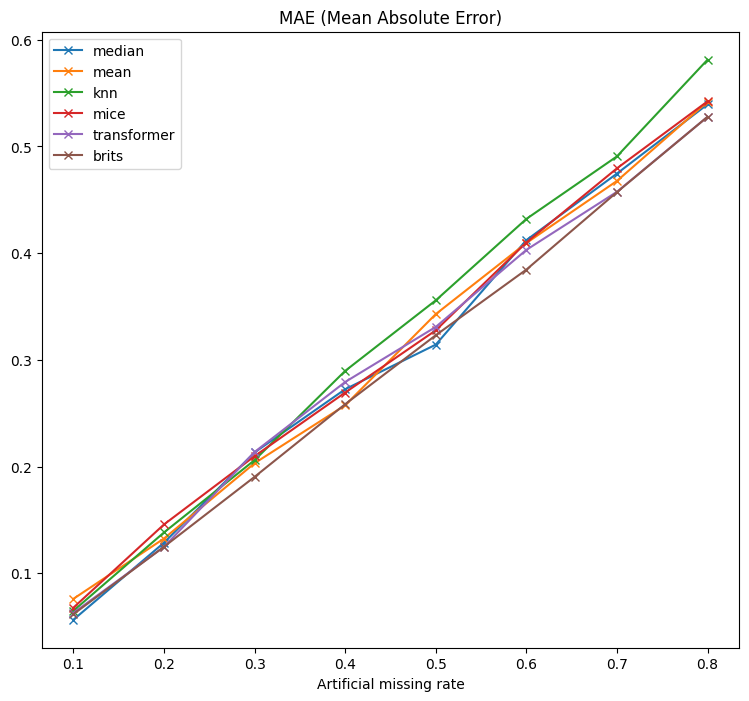

In [ ]:
# MAE
df_mae = pd.read_excel('result/MAE0.1_0.82024-06-27 14:10:07.179376.xlsx')
df_mae.plot(title='MAE (Mean Absolute Error)',x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')

<Axes: title={'center': 'RMSE (Root Mean Squared Error)'}, xlabel='Artificial missing rate'>

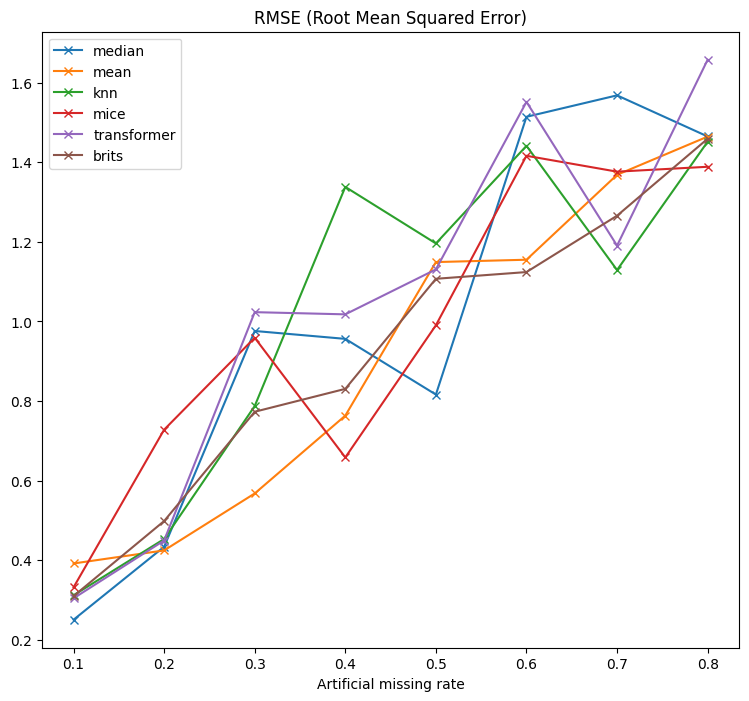

In [ ]:

# RMSE
df_rmse = pd.read_excel('result/RMSE0.1_0.82024-06-27 14:10:07.674452.xlsx')
df_rmse.plot(title='RMSE (Root Mean Squared Error)', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



<Axes: title={'center': 'MSE (Mean Squared Error)'}, xlabel='Artificial missing rate'>

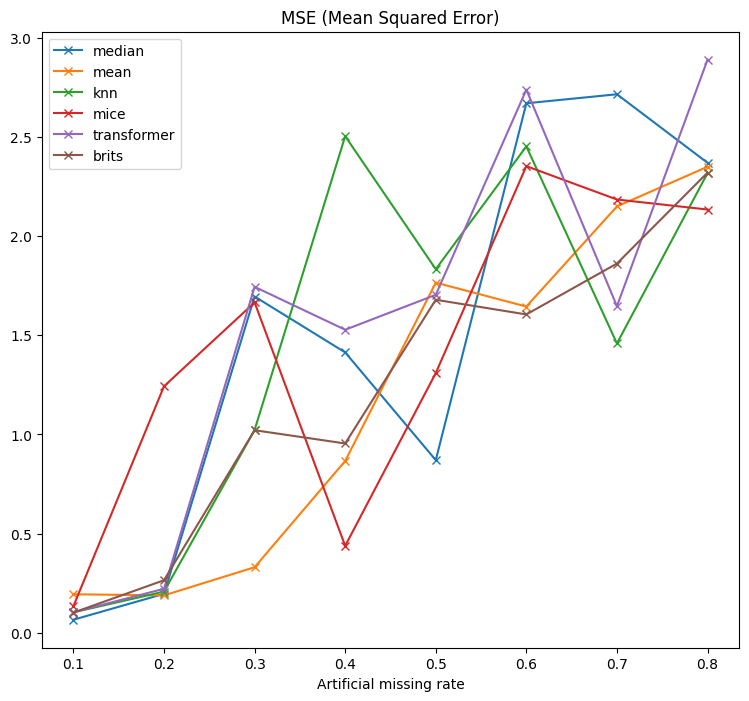

In [ ]:
# RMSE
df_mse = pd.read_excel('result/MSE0.1_0.82024-06-27 14:10:07.639345.xlsx')
df_mse.plot(title='MSE (Mean Squared Error)', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')


<Axes: title={'center': 'Running time'}, xlabel='Artificial missing rate'>

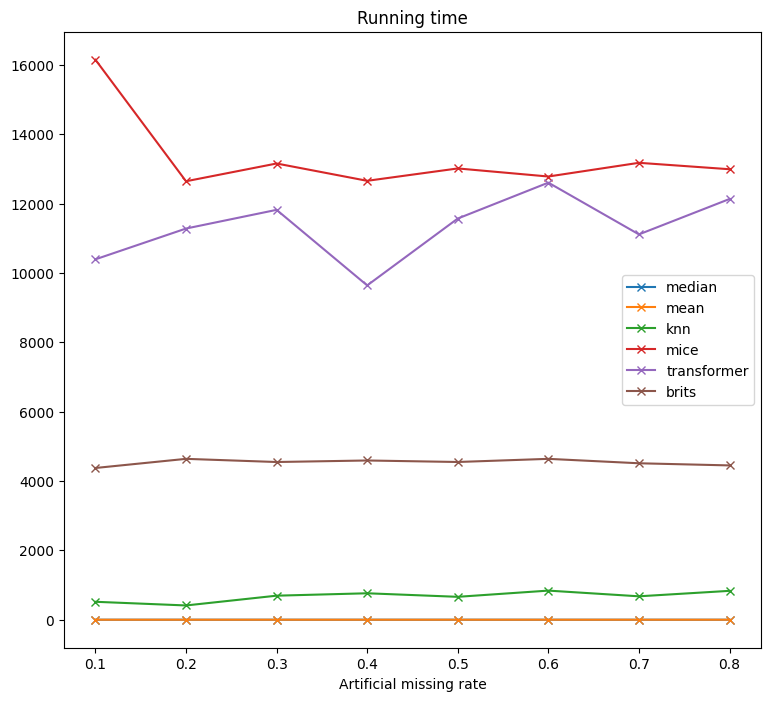

In [ ]:
# RMSE
df_running_time = pd.read_excel('result/RunningTime0.1_0.82024-06-27 14:10:07.715865.xlsx')
df_running_time.plot(title='Running time', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')